# Classifying the news

This project analyzes around 13,000 news articles published in March 2017 by 15 different publishers. The project aims to find out whether it is possible to classify, group or identify articles based on certain characteristics.

## Contents
- Data: This section details the data used as well as the data cleaning and feature engineering steps.
- Clustering: This section groups articles using clustering algorithms, and the results are analyzed to see if publications and authors are grouped together.
- Modeling: This section uses supervised modeling techniques to predict the publication and author of an article based on its text.

## Data

In [1]:
## Packages

## Standard packages
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
from collections import Counter

## Word related packages
import spacy
import re
import gensim
from gensim.models import word2vec, doc2vec
from gensim.test.utils import get_tmpfile
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import nltk
from textblob import TextBlob

## Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

## Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
import itertools

# Neural Nets
from sklearn.neural_network import MLPClassifier

The data for this project came from [Kaggle](https://www.kaggle.com/snapcrack/all-the-news). The original dataset contained about 143,000 articles covering around 5 years. The amount of data was reduced to include March 2017 only in order to decrease model run time. March 2017 was chosen as it was one of the more recent months in the dataset and had a spread of articles across the month.

In [2]:
## Import data

march17news = pd.read_csv('march17news.csv', index_col=0)
march17news.head()

,title,publication,author,date,year,month,url,content,datetime
0,A ‘World Unto Itself’ in New York Area Yeshiva...,New York Times,Corey Kilgannon,2017-03-13,2017,3,NaN,In the basement of a mammoth old building in U...,2017-03-13
1,"Review: ‘The Present’: Even in Russia, It’s Ha...",New York Times,Ben Brantley,2017-03-27,2017,3,NaN,"As is so often the case, the party doesn’t rea...",2017-03-27
2,Danielle Brooks: The First Time I Saw Myself o...,New York Times,Danielle Brooks,2017-03-22,2017,3,NaN,"It was June 2012, and I had just sped out of t...",2017-03-22
3,Samsung Group Leader Is Named a Suspect in Sou...,New York Times,Choe Sang-Hun,2017-03-11,2017,3,NaN,"SEOUL, South Korea — A special prosecutor i...",2017-03-11
4,Australian Drug Maker Has Low Profile but Powe...,New York Times,Katie Thomas,2017-03-22,2017,3,NaN,SAN FRANCISCO — Innate Immunotherapeutics i...,2017-03-22


### Data cleaning
The data was checked to see what it contained and what was missing.

In [3]:
march17news.shape

(9581, 9)

In [4]:
## Find short / empty content

march17news['content_length'] = march17news['content'].apply(len)
march17news.head()

,title,publication,author,date,year,month,url,content,datetime,content_length
0,A ‘World Unto Itself’ in New York Area Yeshiva...,New York Times,Corey Kilgannon,2017-03-13,2017,3,NaN,In the basement of a mammoth old building in U...,2017-03-13,8098
1,"Review: ‘The Present’: Even in Russia, It’s Ha...",New York Times,Ben Brantley,2017-03-27,2017,3,NaN,"As is so often the case, the party doesn’t rea...",2017-03-27,6234
2,Danielle Brooks: The First Time I Saw Myself o...,New York Times,Danielle Brooks,2017-03-22,2017,3,NaN,"It was June 2012, and I had just sped out of t...",2017-03-22,5069
3,Samsung Group Leader Is Named a Suspect in Sou...,New York Times,Choe Sang-Hun,2017-03-11,2017,3,NaN,"SEOUL, South Korea — A special prosecutor i...",2017-03-11,4393
4,Australian Drug Maker Has Low Profile but Powe...,New York Times,Katie Thomas,2017-03-22,2017,3,NaN,SAN FRANCISCO — Innate Immunotherapeutics i...,2017-03-22,10463


In [5]:
march17news.loc[march17news['content_length'] < 50, ]

,title,publication,author,date,year,month,url,content,datetime,content_length
3234,This man dropped out of college twice and now ...,Business Insider,NaN,2017-03-17,2017,3,NaN,’’ ’ ’,2017-03-17,6
3768,Mass Effect: Andromeda Is More About Choice Th...,Atlantic,David Sims,2017-03-20,2017,3,NaN,,2017-03-20,2
4214,21 Of The Most Powerful Photos Of This Week,Buzzfeed News,Gabriel H. Sanchez,2017-03-12,2017,3,https://web.archive.org/web/20170312000259/htt...,,2017-03-12,4


In [6]:
## Find missing publications

march17news.loc[march17news['publication'].isna(), ]

,title,publication,author,date,year,month,url,content,datetime,content_length


In [7]:
## Find how many missing authors

len(march17news.loc[march17news['author'].isna(), ])

494

In [8]:
## Find which publications have missing authors

march17news.loc[march17news['author'].isna(), 'publication'].value_counts()

CNN                    231
Guardian               133
Business Insider        94
Talking Points Memo     20
NPR                     15
New York Times           1
Name: publication, dtype: int64

In [9]:
march17news.loc[:, 'publication'].value_counts()

New York Post          1584
Breitbart              1386
New York Times          994
Reuters                 804
NPR                     737
Guardian                735
Washington Post         660
CNN                     634
Atlantic                588
Buzzfeed News           409
Business Insider        400
Vox                     347
National Review         283
Talking Points Memo      20
Name: publication, dtype: int64

Removing missing authors would remove around one third of CNN articles and all of the Talking Points Memo articles. Articles with missing authors are retained at this stage.

In [10]:
## Remove rows where there is no content

march17news = march17news.loc[~(march17news['content_length'] < 50), ]
march17news.reset_index(drop=True, inplace=True)

In [11]:
## Split into train and test sets

train, test = train_test_split(march17news, random_state=76)
train.reset_index(inplace=True)
train.rename(columns={'index': 'article_id'}, inplace=True)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


### Train models

Five different methods of analyzing text data were considered in this project - overall article vector using doc2vec, the article's average word2vec vector, the article's maximum word2vec vector, spacy tokens and tf-idf. Here the data is converted into these four formats.

#### doc2vec

In [12]:
def create_corpus(data):
    for i in np.arange(0, len(data)):
        yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(data.loc[i, 'content']), [i])

In [13]:
start_time = time.process_time()
train_articles = list(create_corpus(train))
print(time.process_time() - start_time)

9.071335000000001


In [14]:
model_d2v = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=20)
model_d2v.build_vocab(train_articles)
start_time = time.process_time()
model_d2v.train(train_articles, total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)
print(time.process_time() - start_time)

210.568381


In [15]:
## Repeat for test set
test.reset_index(inplace=True)
test.rename(columns={'index': 'article_id'}, inplace=True)
test_articles = list(create_corpus(test))

In [16]:
def d2v_vectors(model):
    docvecs = []
    for i in np.arange(0, len(model)):
        docvecs.append(model[i])
    df = pd.DataFrame(docvecs)
    return df

In [17]:
x_train_d2v = d2v_vectors(model_d2v.docvecs)

In [18]:
def get_vectors(model, new_data):
    docvecs = []
    for i in np.arange(0, len(new_data)):
        docvecs.append(model.infer_vector(new_data[i].words))
    df = pd.DataFrame(docvecs)
    return df

In [19]:
x_test_d2v = get_vectors(model_d2v, test_articles)

#### Google word vectors

In [20]:
# Load Google's pre-trained Word2Vec model.
model_g = gensim.models.KeyedVectors.load_word2vec_format ('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True)
google_wv = model_g.wv

/usr/local/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
print('Downloaded Google model')

Downloaded Google model


In [22]:
## Function to get word vector for each word

def word_vectors(data):
    all_wv = {}
    for row in np.arange(0, len(data)):
        row_wv = []
        article = data.loc[row, 'content'].split(sep=' ')
        for word in article:
            if word in google_wv.vocab:
                row_wv.append(model_g.wv.get_vector(word))
        all_wv[row] = row_wv
    return all_wv

In [23]:
start_time = time.process_time()
train_articles_g = word_vectors(train)
print(time.process_time() - start_time)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


23.168994999999995


In [24]:
## Generate a single vector for each article
## Try two - the average vector and the max vector

def av_max_vectors(data):
    av_vectors_g = []
    max_vectors_g = []
    for i in np.arange(0, len(data)):
        article = data[i]
        article_df = pd.DataFrame(article)
        article_df = article_df.T
        article_df['average'] = article_df.mean(axis=1)
        article_df['max'] = article_df.max(axis=1)
        av_vectors_g.append(np.asarray(article_df['average']))
        max_vectors_g.append(np.asarray(article_df['max']))
    return av_vectors_g, max_vectors_g

In [25]:
start_time = time.process_time()

av_train_g1, max_train_g1 = av_max_vectors(train_articles_g)

time.process_time() - start_time

474.871944

In [26]:
## Repeat for test set

start_time = time.process_time()
test_articles_g = word_vectors(test)
print(time.process_time() - start_time)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


8.693858999999975


In [27]:
start_time = time.process_time()

av_test_g1, max_test_g1 = av_max_vectors(test_articles_g)

time.process_time() - start_time

158.35078499999997

#### Bag of Words with spaCy

In [28]:
nlp = spacy.load('en')
def create_nlp(data):

    nlp_col = []
    for row in data.index:
        nlp_list = []
        nlp_text = nlp(data.loc[row, 'content'])
        for token in nlp_text:
            if not token.is_punct and not token.is_stop:
                nlp_list.append(token)
        nlp_col.append(nlp_list)

    return pd.DataFrame({'article_id': data['article_id'],
                         'publication': data['publication'],
                         'content_nlp': nlp_col})

In [29]:
start_time = time.process_time()

train_nlp = create_nlp(train)

print(time.process_time() - start_time)

949.2551490000001


In [30]:
## Find 2000 most common words

def common_words(data):
    all_words = []
    common_words = []
    for row in np.arange(0, len(data)):
        if (row % 1000 == 0):
            print('Row {} processing'.format(row))
        for token in data.loc[row, 'content_nlp']:
            all_words.append(token.lemma_)
    word_results = [item for item in Counter(all_words).most_common(2000)]
    for word in word_results:
        common_words.append(word[0])

    return common_words

In [31]:
start_time = time.process_time()

nlp_words = common_words(train_nlp)

time.process_time() - start_time

Row 0 processing
Row 1000 processing
Row 2000 processing
Row 3000 processing
Row 4000 processing
Row 5000 processing
Row 6000 processing
Row 7000 processing


7.479597999999896

In [32]:
def create_bow(df, words):

    start_time = time.process_time()
    
    df_bow = pd.DataFrame(columns=words)
    df_bow['content_nlp'] = df['content_nlp']
    df_bow['article_id'] = df['article_id']
    df_bow['publication'] = df['publication']

    for row in df_bow.index:
        allwords = df_bow.loc[row, 'content_nlp']
        allwords_count = [item for item in Counter(allwords).most_common()]
        for word in allwords_count:
            if str(word[0]) in words:
                df_bow.loc[row, str(word[0])] = word[1]
        if row % 1000 == 0:
            print('Processing row {}'.format(row))
            print('Time taken: {}'.format(time.process_time() - start_time))
    
    return df_bow

In [33]:
train_bow = create_bow(train_nlp, nlp_words)

Processing row 0
Time taken: 1.2767739999999321
Processing row 1000
Time taken: 145.03565600000002
Processing row 2000
Time taken: 285.55324999999993
Processing row 3000
Time taken: 430.63002700000015
Processing row 4000
Time taken: 568.0768760000001
Processing row 5000
Time taken: 707.0833440000001
Processing row 6000
Time taken: 840.8918279999998
Processing row 7000
Time taken: 977.8317959999999


In [34]:
train_bow.fillna(0, inplace=True)

In [35]:
x_train_bow = train_bow.drop(['content_nlp', 'article_id', 'publication'], axis=1)

In [36]:
## Repeat for test set

start_time = time.process_time()

test_nlp = create_nlp(test)

print(time.process_time() - start_time)

336.2490310000003


In [37]:
test_bow = create_bow(test_nlp, nlp_words)

Processing row 0
Time taken: 1.0972329999999602
Processing row 1000
Time taken: 117.805969
Processing row 2000
Time taken: 220.4426309999999


In [38]:
test_bow.fillna(0, inplace=True)
x_test_bow = test_bow.drop(['content_nlp', 'article_id', 'publication'], axis=1)

#### tf-idf

In [39]:
train_str = train.loc[:, 'content'].values

In [40]:
vectorizer = TfidfVectorizer(max_df = 0.9,
                            min_df = 10,
                            stop_words='english',
                            use_idf=True,
                             lowercase=False,
                            norm=u'l2',
                            smooth_idf=True)

In [41]:
start_time = time.process_time()

x_train_tfidf_v = vectorizer.fit(train_str)
x_train_tfidf = x_train_tfidf_v.transform(train_str)
print('Number of features: {}'.format(x_train_tfidf.get_shape()[1]))

time.process_time() - start_time

Number of features: 19400


10.299420999999711

In [42]:
test_str = test.loc[:, 'content'].values
x_test_tfidf = x_train_tfidf_v.transform(test_str)

## Clustering

### Clustering by publication

The publications were rearranged into ideological order. This ordering was completed with reference to [mediabiaschart.com](mediabiaschart.com).

In [43]:
ideological_order = ['Vox', 'Buzzfeed News', 'Atlantic', 'Talking Points Memo', 'Washington Post', 'CNN', 'Guardian', 'NPR', 'New York Times', 'Reuters', 'Business Insider', 'New York Post', 'National Review', 'Breitbart']

In [44]:
## Count number of each publication for percentage calculations

pub_counts_train = pd.DataFrame(train['publication'].value_counts())
pub_counts_test = pd.DataFrame(test['publication'].value_counts())

In [45]:
## Formula to convert results into percentages within each cluster

def table_pct(df, totals):
    df_new = pd.DataFrame(columns=ideological_order)
    for row in df.index:
        for pub in totals.index:
            df_new.loc[row, pub] = df.loc[row, pub] / totals.loc[pub, 'publication']
    return df_new

Using the KMeans algorithm, the training data was grouped into 25 clusters. This was done 5 times - once for each data format. The graphs below show the distribution of the publications within each cluster.

#### doc2vec publication clusters

In [46]:
## 25 clusters

kmeans_train_d2v25 = KMeans(n_clusters=25, random_state=76).fit(x_train_d2v)
ypred_train_d2v25 = kmeans_train_d2v25.predict(x_train_d2v)

train_d2v_cl25 = pd.crosstab(ypred_train_d2v25, train['publication'])
train_d2v_cl25pct = table_pct(train_d2v_cl25, pub_counts_train)
train_d2v_cl25pct.reset_index(inplace=True)
train_d2v_cl25pct.rename(columns={'index': 'cluster'}, inplace=True)
train_d2v_cl25pct_long = pd.melt(train_d2v_cl25pct, id_vars='cluster')

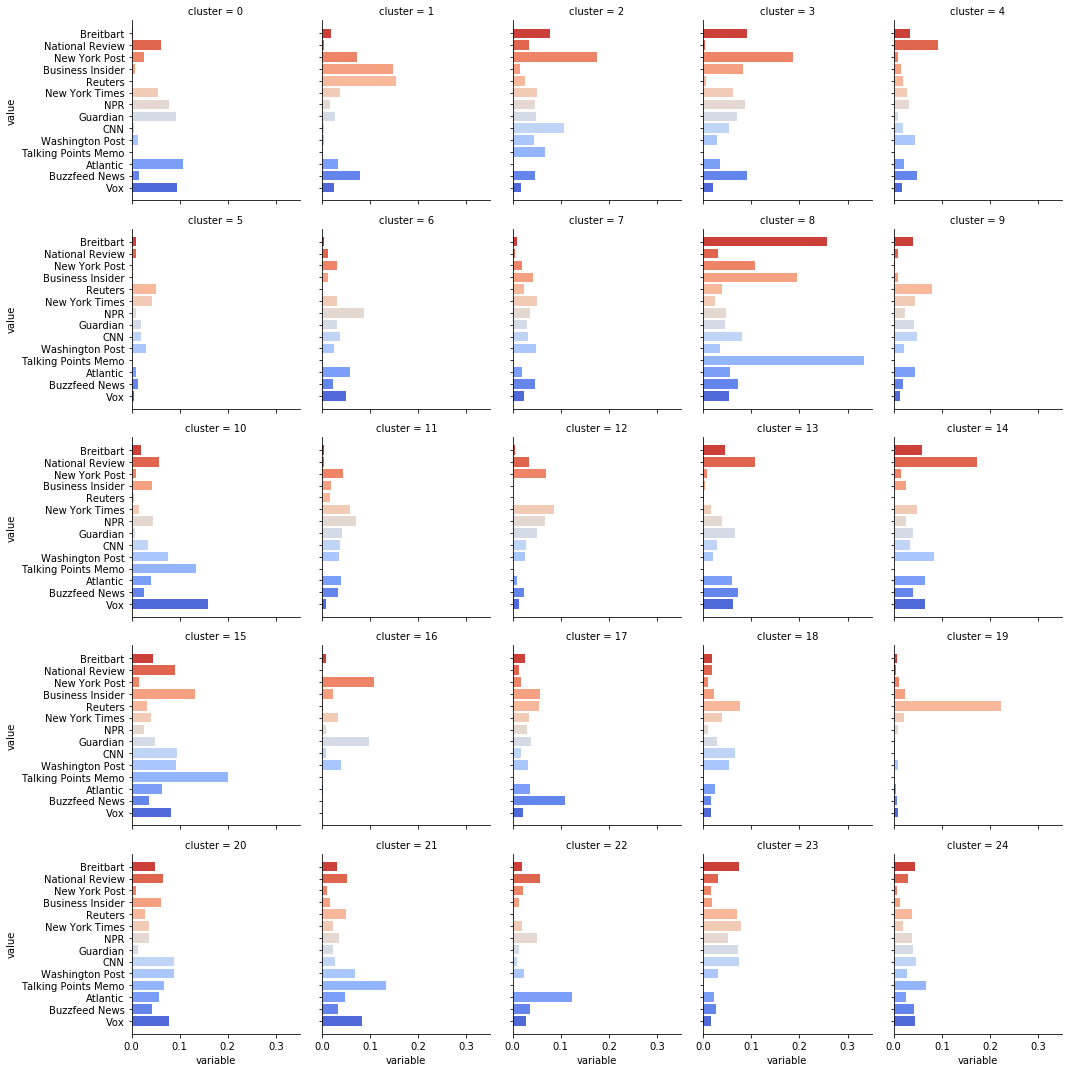

In [47]:
g = sns.FacetGrid(train_d2v_cl25pct_long, col='cluster', col_wrap=5, hue='variable', palette='coolwarm')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

The most noticeable feature of these clusters is that cluster 19 is essentially a 'Reuters' cluster. No other publication stands out on its own in a cluster to such a large extent.

Most publications are distributed fairly evenly between several clusters, suggesting these clusters have not identified meaningful differences between the publications. However, the distribution of some clusters is more skewed, perhaps indicating an ideological bias. For example, cluster 10 appears to favor left-leaning publications, whereas clusters 3, 8 and 14 (aside from Talking Points Memo) are perhaps slightly skewed in the opposite direction. Some of the clusters (e.g. 22) may indicate more biased publications in general, without discriminating between left or right wing. Clusters 5 and 16 by contrast group several articles from publications more in the center ground.

To test whether these clusters are simply random groupings, the same clustering algorithm was used to predict the clusters of the test set. If the clusters do indicate the meanings set out above, the same publications should be found in the same clusters.

In [48]:
## Test doc2vec clusters

ypred_test_d2v25 = kmeans_train_d2v25.predict(x_test_d2v)

test_d2v_cl25 = pd.crosstab(ypred_test_d2v25, test['publication'])
test_d2v_cl25pct = table_pct(test_d2v_cl25, pub_counts_test)
test_d2v_cl25pct.reset_index(inplace=True)
test_d2v_cl25pct.rename(columns={'index': 'cluster'}, inplace=True)
test_d2v_cl25pct_long = pd.melt(test_d2v_cl25pct, id_vars='cluster')

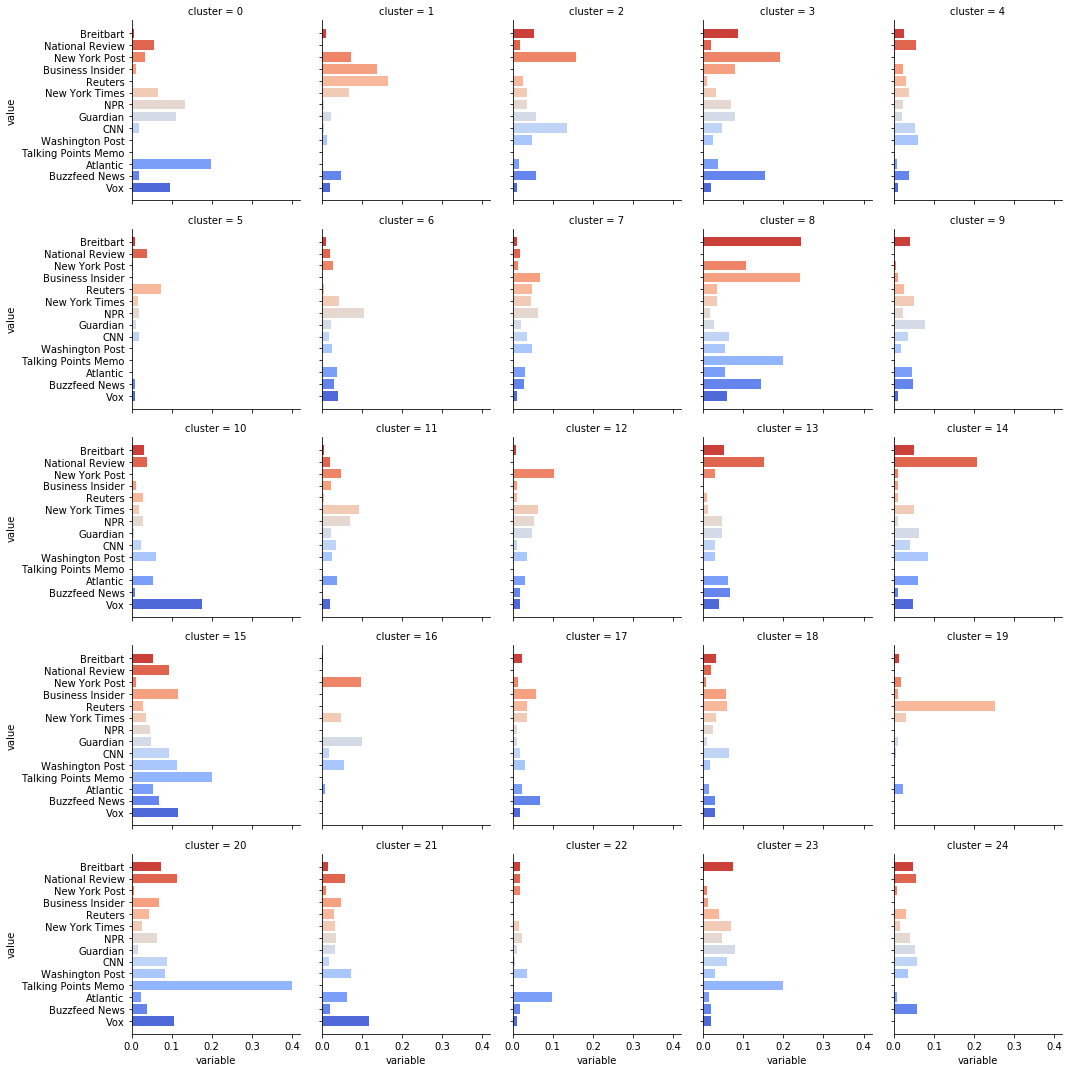

In [49]:
g = sns.FacetGrid(test_d2v_cl25pct_long, col='cluster', col_wrap=5, hue='variable', palette='coolwarm')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

The Reuters cluster appears to be stable as it has accurately grouped Reuters publications again. Cluster 10 has again identified mostly left wing publications, and cluster 14 has mostly right wing ones, but 3 and 8 have a more diverse spread so are unlikely to be accurate predictora. Cluster 22 again does not appear to retain its slight predictive power in finding more ideologically extreme publications. Clusters 5 and 16 do contain mostly centrist publications again, but only a few publications are in these clusters. 

#### word2vec (average vector) publication clusters

In [50]:
## 25 clusters

kmeans_train_av_g1_25 = KMeans(n_clusters=25, random_state=76).fit(av_train_g1)
ypred_train_av_g1_25 = kmeans_train_av_g1_25.predict(av_train_g1)

train_av_g1_cl25 = pd.crosstab(ypred_train_av_g1_25, train['publication'])
train_av_g1_cl25pct = table_pct(train_av_g1_cl25, pub_counts_train)
train_av_g1_cl25pct.reset_index(inplace=True)
train_av_g1_cl25pct.rename(columns={'index': 'cluster'}, inplace=True)
train_av_g1_cl25pct_long = pd.melt(train_av_g1_cl25pct, id_vars='cluster')

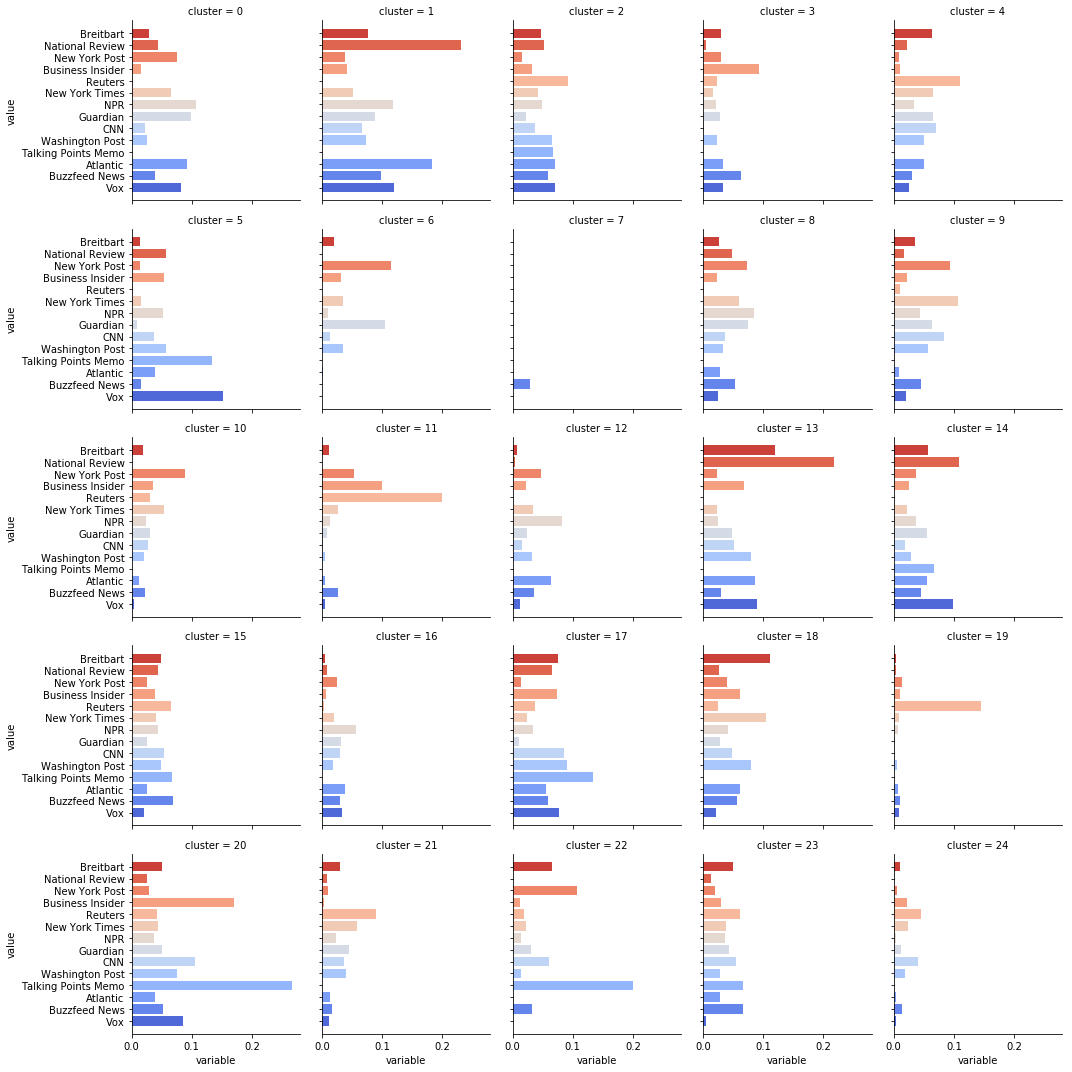

In [51]:
g = sns.FacetGrid(train_av_g1_cl25pct_long, col='cluster', col_wrap=5, hue='variable', palette='coolwarm')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

Similarly to the doc2vec version, the average word2vec data clustering results in a Reuters cluster, this time cluster 19. However, this cluster only contains about 15% of Reuters articles whereas the two clear Reuters clusters previously contained around 40% of the articles between them. There are other clusters in this grouping which contain a significant proportion of Reuters articles, such as clusters 4 and 11, but not in the almost 'exclusive' way seen in cluster 19.

Only Buzzfeed News appears in cluster 7 but this is such a small proportion of total Buzzfeed articles it is basically irrelevant.

It is difficult to discern any clusters which appear to group left or right wing publications togather. Potentially cluster 5 identifies more left wing bias and cluster 13 identifies more right wing bias, but generally the clusters contain a reasonably even spread of publications. Clusters 4, 9 and 10 may been seen as identifying centrist publications.

These potential clusters were tested with the test set.

In [52]:
## 25 clusters

ypred_test_av_g1_25 = kmeans_train_av_g1_25.predict(av_test_g1)

test_av_g1_cl25 = pd.crosstab(ypred_test_av_g1_25, test['publication'])
test_av_g1_cl25pct = table_pct(test_av_g1_cl25, pub_counts_test)
test_av_g1_cl25pct.reset_index(inplace=True)
test_av_g1_cl25pct.rename(columns={'index': 'cluster'}, inplace=True)
test_av_g1_cl25pct_long = pd.melt(test_av_g1_cl25pct, id_vars='cluster')

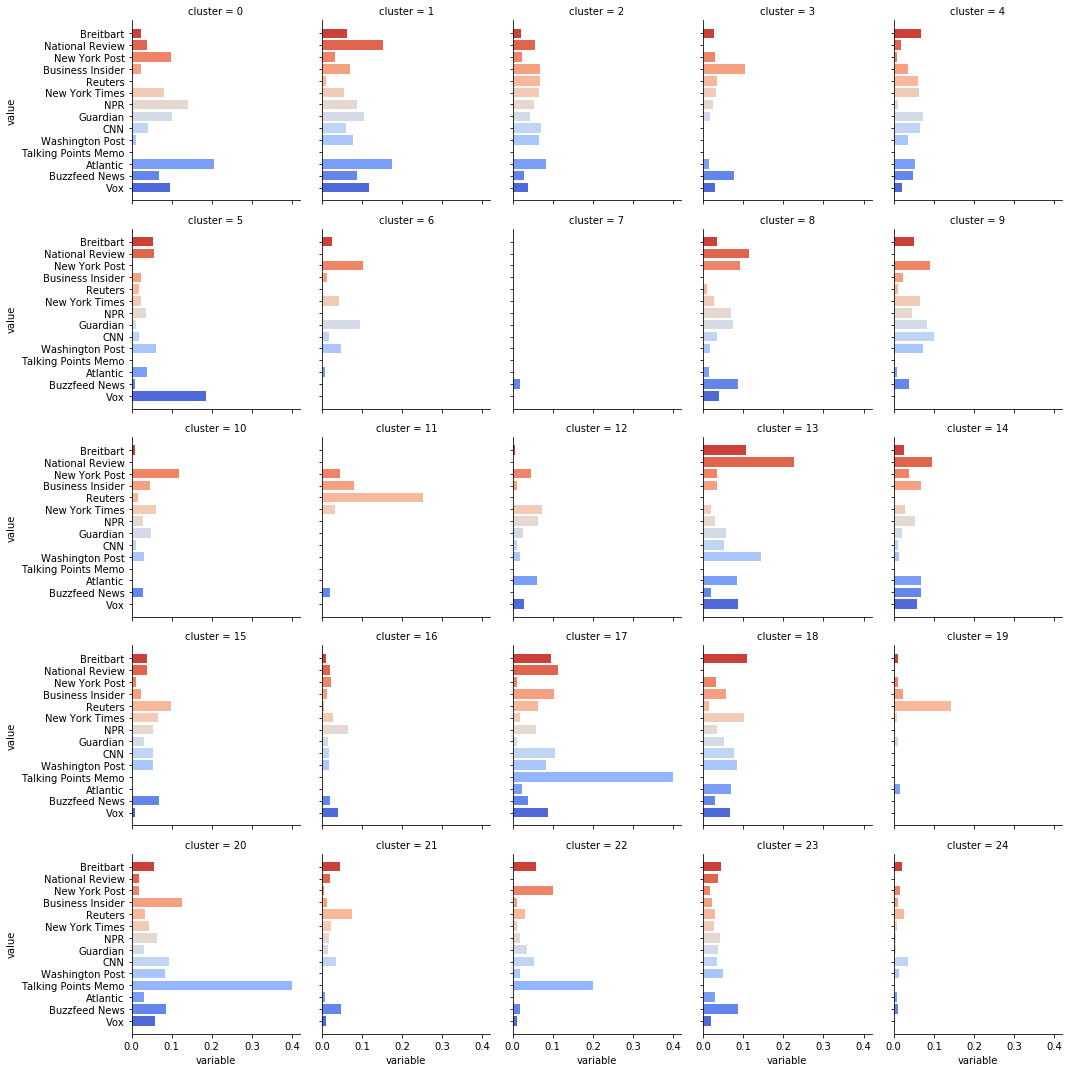

In [53]:
g = sns.FacetGrid(test_av_g1_cl25pct_long, col='cluster', col_wrap=5, hue='variable', palette='coolwarm')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

Cluster 19 is still dominated by Reuters in the test set, and to a lesser extent so is cluster 11. However, the larger Reuters element has disappeared from cluster 4 suggesting it was not a stable predictive cluster.

Clsuter 5 now appears to favor Vox rather than left wing publications in particular, given the change in clustering of Talking Points Memo. Cluster 13 is similarly slightly predictive of right wing publications.

Clusters 9 and 10 do appear to be slightly predictive of centrist publications.

#### word2vec (maximum) publication clusters

In [54]:
## 25 clusters

kmeans_train_max_g1_25 = KMeans(n_clusters=25, random_state=76).fit(max_train_g1)
ypred_train_max_g1_25 = kmeans_train_max_g1_25.predict(max_train_g1)

train_max_g1_cl25 = pd.crosstab(ypred_train_max_g1_25, train['publication'])
train_max_g1_cl25pct = table_pct(train_max_g1_cl25, pub_counts_train)
train_max_g1_cl25pct.reset_index(inplace=True)
train_max_g1_cl25pct.rename(columns={'index': 'cluster'}, inplace=True)
train_max_g1_cl25pct_long = pd.melt(train_max_g1_cl25pct, id_vars='cluster')

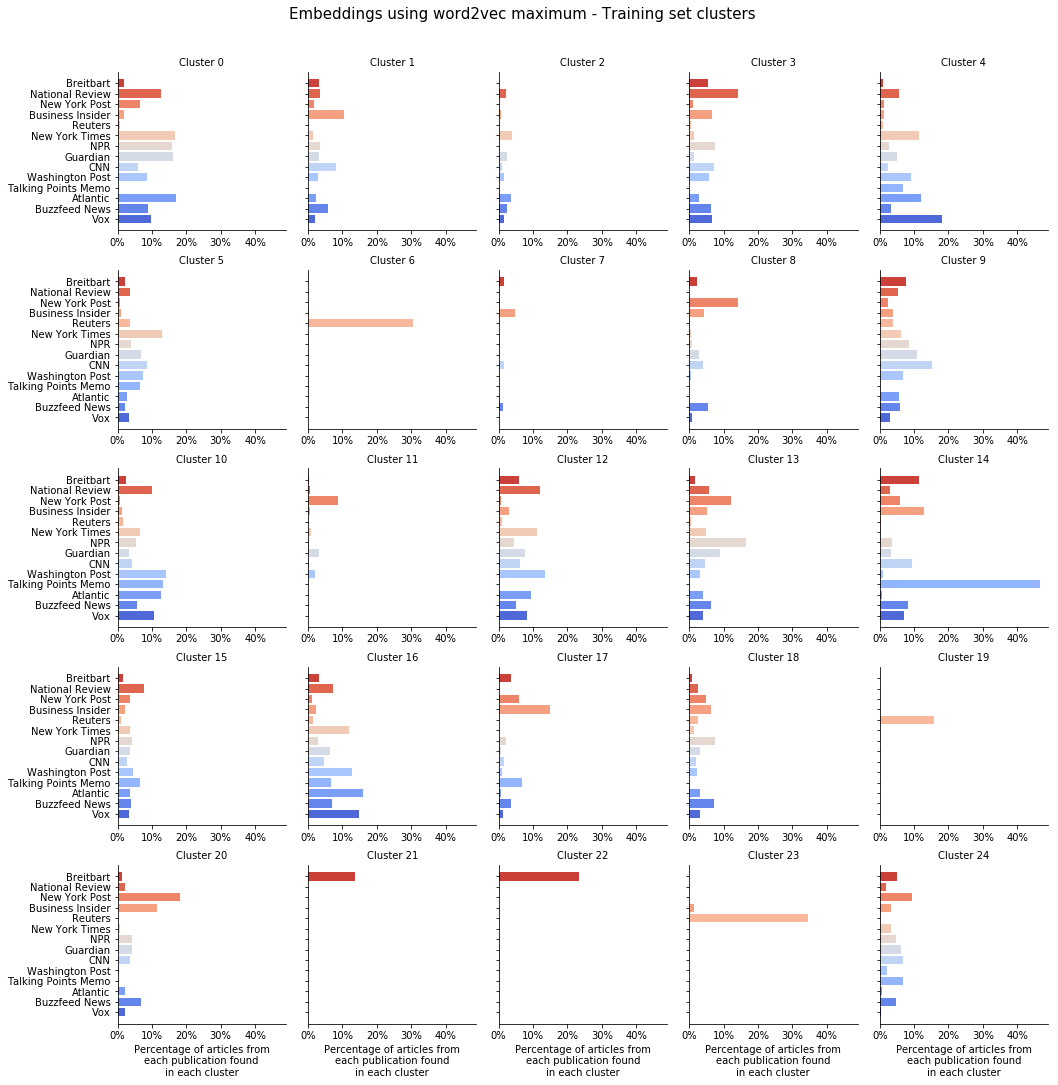

In [459]:
g = sns.FacetGrid(train_max_g1_cl25pct_long, col='cluster', col_wrap=5, hue='variable', palette='coolwarm')
g = g.map(plt.barh, 'variable', 'value')
g.set_ylabels('')
g.set_titles("Cluster {col_name}")
axes = g.axes
for ax in axes:
    _ = plt.setp(ax.get_xticklabels(), visible=True)
    vals = ax.get_xticks()
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
g.set_xlabels('Percentage of articles from\neach publication found\nin each cluster')
plt.subplots_adjust(top=0.92, hspace=0.25)
g.fig.suptitle('Embeddings using word2vec maximum - Training set clusters', fontsize=15)
g.fig.savefig('word2vecmaxpubtrain.png', dpi=300, bbox_inches='tight')
plt.show()

This is exciting. Here there are three Reuters clusters (6, 19 and 23) which together find around 75% of all Reuters articles with almost zero other publications included in these clusters. Around 30% of Breitbart articles are identified in almost solo clusters, 21 and 22. Also, nearly 50% of Talking Points Memo articles are in cluster 14.

Ideological bias also appears to be noticeable towards the left in clusters 4, 10 and 16, and towards the right in 17 and 20. Clusters 5, 9 and 13 may be predictive of a centrist publication.

In [56]:
## 25 clusters - test on test set

ypred_test_max_g1_25 = kmeans_train_max_g1_25.predict(max_test_g1)

test_max_g1_cl25 = pd.crosstab(ypred_test_max_g1_25, test['publication'])
test_max_g1_cl25pct = table_pct(test_max_g1_cl25, pub_counts_test)
test_max_g1_cl25pct.reset_index(inplace=True)
test_max_g1_cl25pct.rename(columns={'index': 'cluster'}, inplace=True)
test_max_g1_cl25pct_long = pd.melt(test_max_g1_cl25pct, id_vars='cluster')

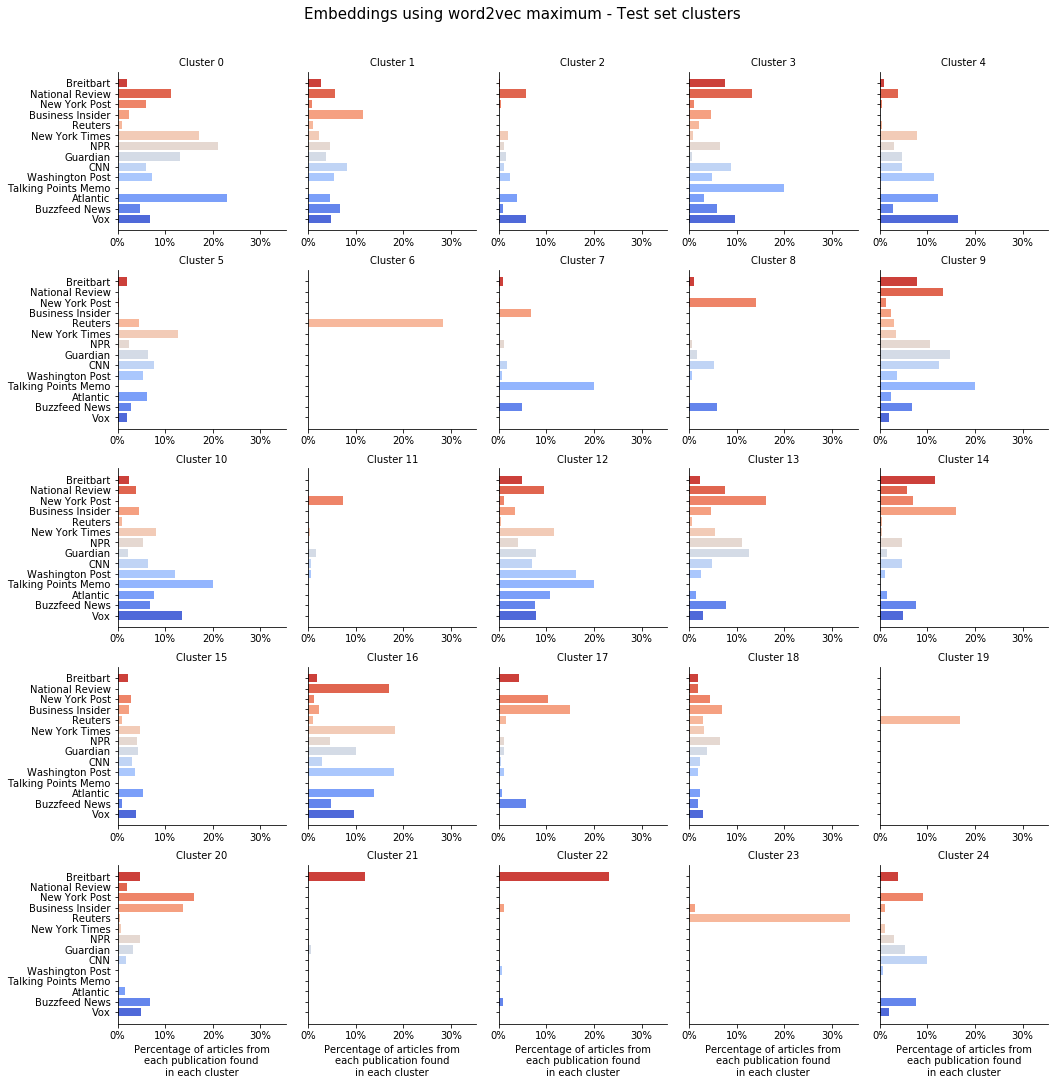

In [434]:
g = sns.FacetGrid(test_max_g1_cl25pct_long, col='cluster', col_wrap=5, hue='variable', palette='coolwarm')
g = g.map(plt.barh, 'variable', 'value')
g.set_ylabels('')
g.set_titles("Cluster {col_name}")
axes = g.axes
for ax in axes:
    _ = plt.setp(ax.get_xticklabels(), visible=True)
    vals = ax.get_xticks()
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
g.set_xlabels('Percentage of articles from\neach publication found\nin each cluster')
plt.subplots_adjust(top=0.92, hspace=0.25)
g.fig.suptitle('Embeddings using word2vec maximum - Test set clusters', fontsize=15)
g.fig.savefig('word2vecmaxpubtest.png', dpi=300, bbox_inches='tight')
plt.show()

The Reuters and the Breitbart clusters have remained, suggesting these are stable clusters. The Talking Points Memo cluster has completely disappeared, suggesting this is not!

Left wing bias is still visible in clusters 4 and 10 but not 16. Clusters 17 and 20 still have some right wing bias. Clusters 5, 9 and 13 are still relatively good at predicting centrist publications.

#### Bag of Words publication clusters

In [58]:
## 25 clusters

kmeans_train_bow_25 = KMeans(n_clusters=25, random_state=76).fit(x_train_bow)
ypred_train_bow_25 = kmeans_train_bow_25.predict(x_train_bow)

train_bow_cl25 = pd.crosstab(ypred_train_bow_25, train['publication'])
train_bow_cl25pct = table_pct(train_bow_cl25, pub_counts_train)
train_bow_cl25pct.reset_index(inplace=True)
train_bow_cl25pct.rename(columns={'index': 'cluster'}, inplace=True)
train_bow_cl25pct_long = pd.melt(train_bow_cl25pct, id_vars='cluster')

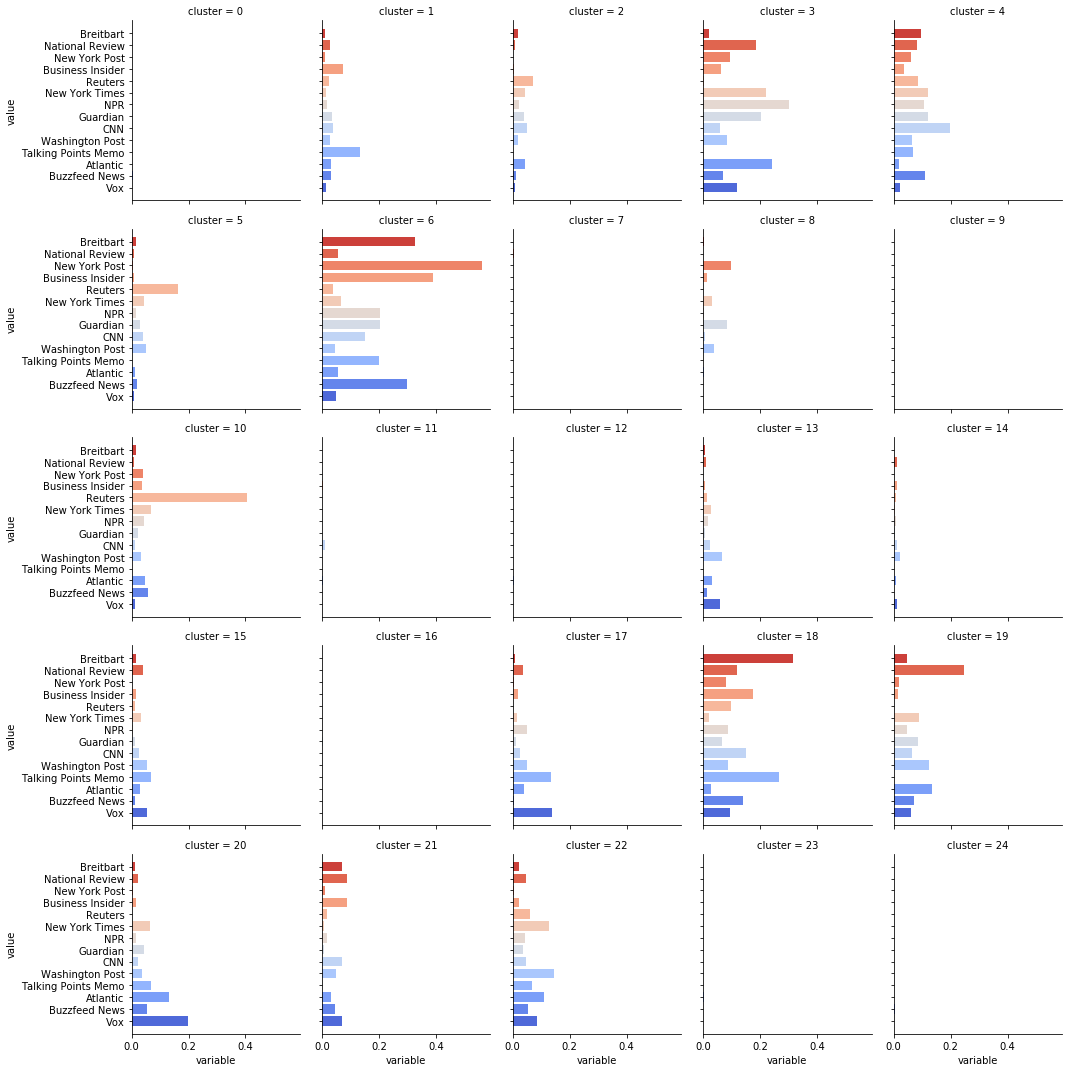

In [59]:
g = sns.FacetGrid(train_bow_cl25pct_long, col='cluster', col_wrap=5, hue='variable', palette='coolwarm')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

Several clusters here have a very tiny number of articles within them. Reuters again stands out in a cluster, number 10, but not to the extent seen in the word2vec max clustering. None of the other publications particularly stand out in a cluster.

Clusters 17 and 20 look to indicate left wing bias and cluster 5 groups centrist publications, but there is limited other information available from these clusters.

In [60]:
## 25 clusters

ypred_test_bow_25 = kmeans_train_bow_25.predict(x_test_bow)

test_bow_cl25 = pd.crosstab(ypred_test_bow_25, test['publication'])
test_bow_cl25pct = table_pct(test_bow_cl25, pub_counts_test)
test_bow_cl25pct.reset_index(inplace=True)
test_bow_cl25pct.rename(columns={'index': 'cluster'}, inplace=True)
test_bow_cl25pct_long = pd.melt(test_bow_cl25pct, id_vars='cluster')

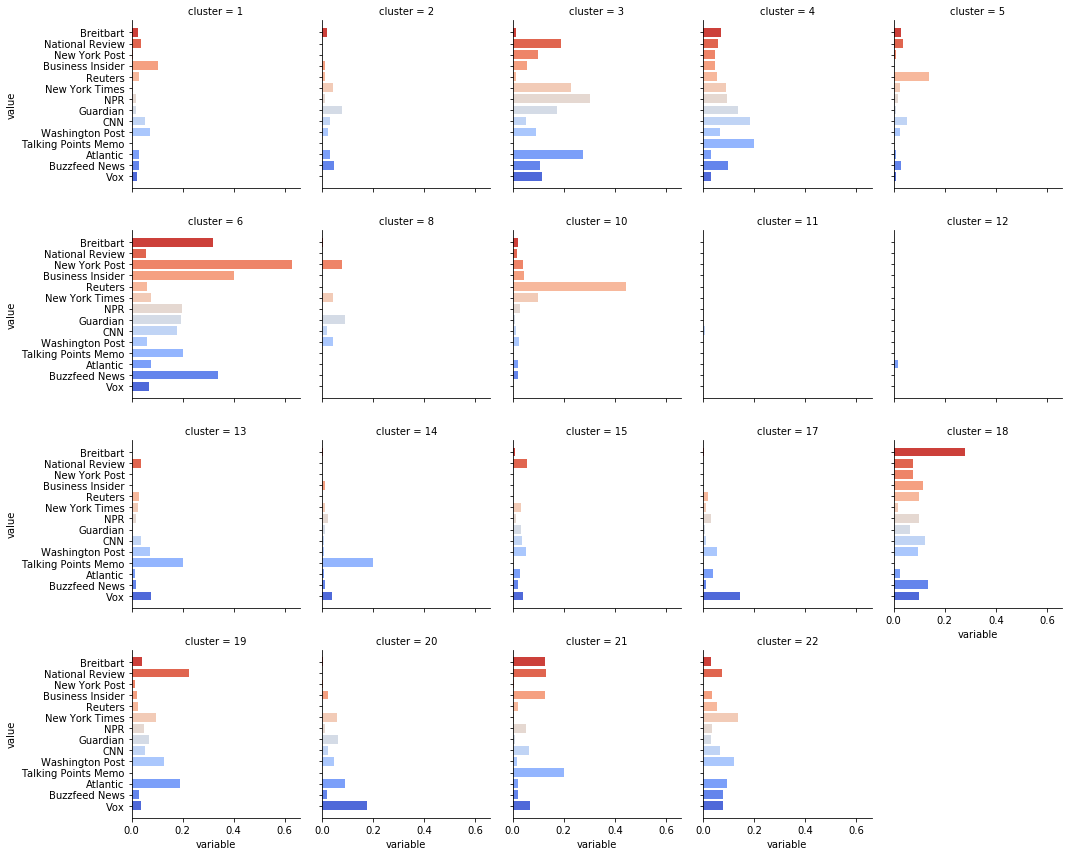

In [61]:
g = sns.FacetGrid(test_bow_cl25pct_long, col='cluster', col_wrap=5, hue='variable', palette='coolwarm')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

Not all the clusters were used in the test set. The Reuters cluster 10 is stable, and there is still left wing predictiveness in clusters 17 and 20 (though mostly relating to Vox specifically), but there are not really any further discriminating clusters.

#### tf-idf publication clusters

In [62]:
## 25 clusters

kmeans_train_tfidf_25 = KMeans(n_clusters=25, random_state=76).fit(x_train_tfidf)
ypred_train_tfidf_25 = kmeans_train_tfidf_25.predict(x_train_tfidf)

train_tfidf_cl25 = pd.crosstab(ypred_train_tfidf_25, train['publication'])
train_tfidf_cl25pct = table_pct(train_tfidf_cl25, pub_counts_train)
train_tfidf_cl25pct.reset_index(inplace=True)
train_tfidf_cl25pct.rename(columns={'index': 'cluster'}, inplace=True)
train_tfidf_cl25pct_long = pd.melt(train_tfidf_cl25pct, id_vars='cluster')

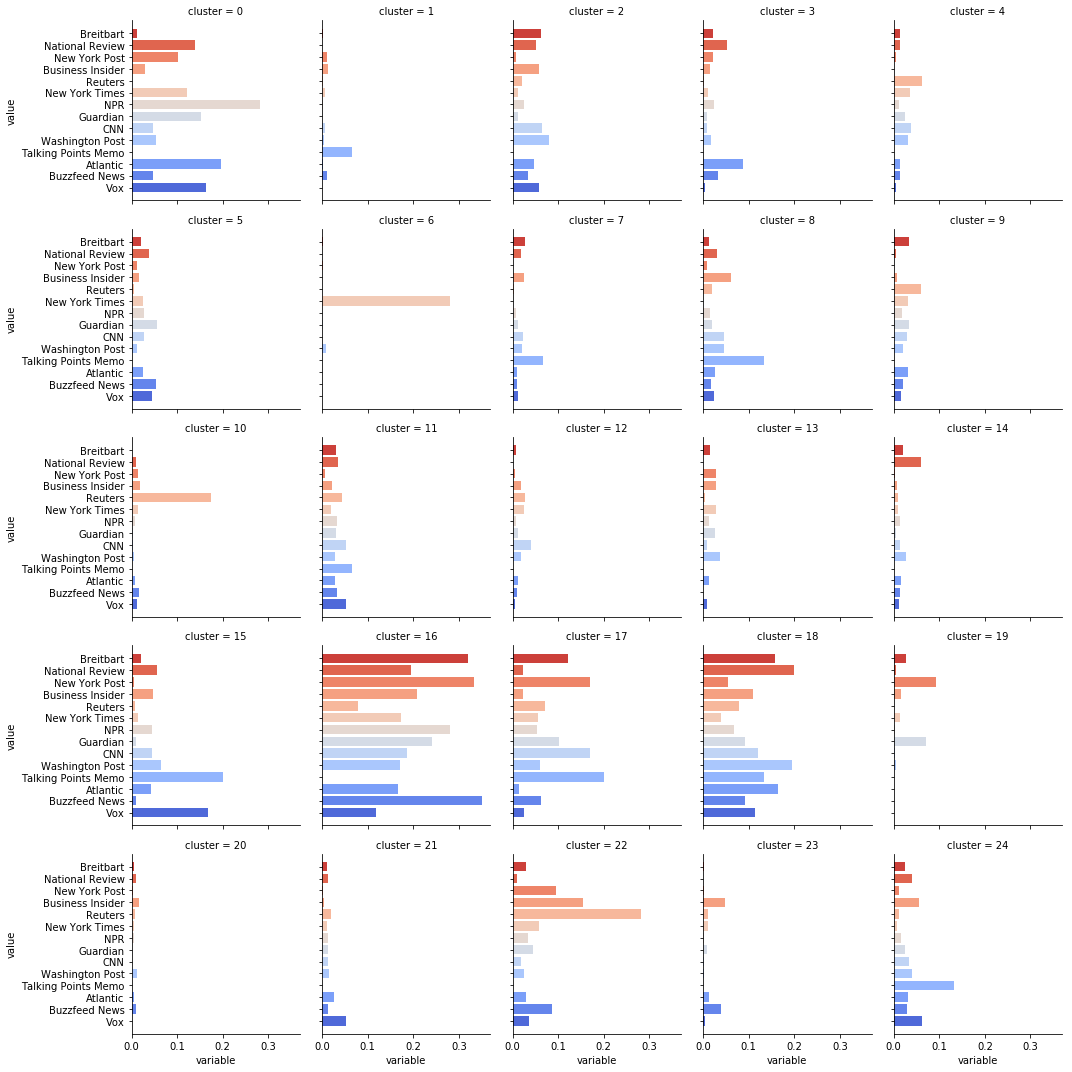

In [63]:
g = sns.FacetGrid(train_tfidf_cl25pct_long, col='cluster', col_wrap=5, hue='variable', palette='coolwarm')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

As usual there is a Reuters cluster (number 10) but surprisingly there is a larger single cluster focused on the New York Times (cluster 6). Cluster 15 may indicate a slight left wing bias and clsuter 22 a slight right wing bias, but the majority of the clusters do not differentiate between different publications well.

In [64]:
## 25 clusters

ypred_test_tfidf_25 = kmeans_train_tfidf_25.predict(x_test_tfidf)

test_tfidf_cl25 = pd.crosstab(ypred_test_tfidf_25, test['publication'])
test_tfidf_cl25pct = table_pct(test_tfidf_cl25, pub_counts_test)
test_tfidf_cl25pct.reset_index(inplace=True)
test_tfidf_cl25pct.rename(columns={'index': 'cluster'}, inplace=True)
test_tfidf_cl25pct_long = pd.melt(test_tfidf_cl25pct, id_vars='cluster')

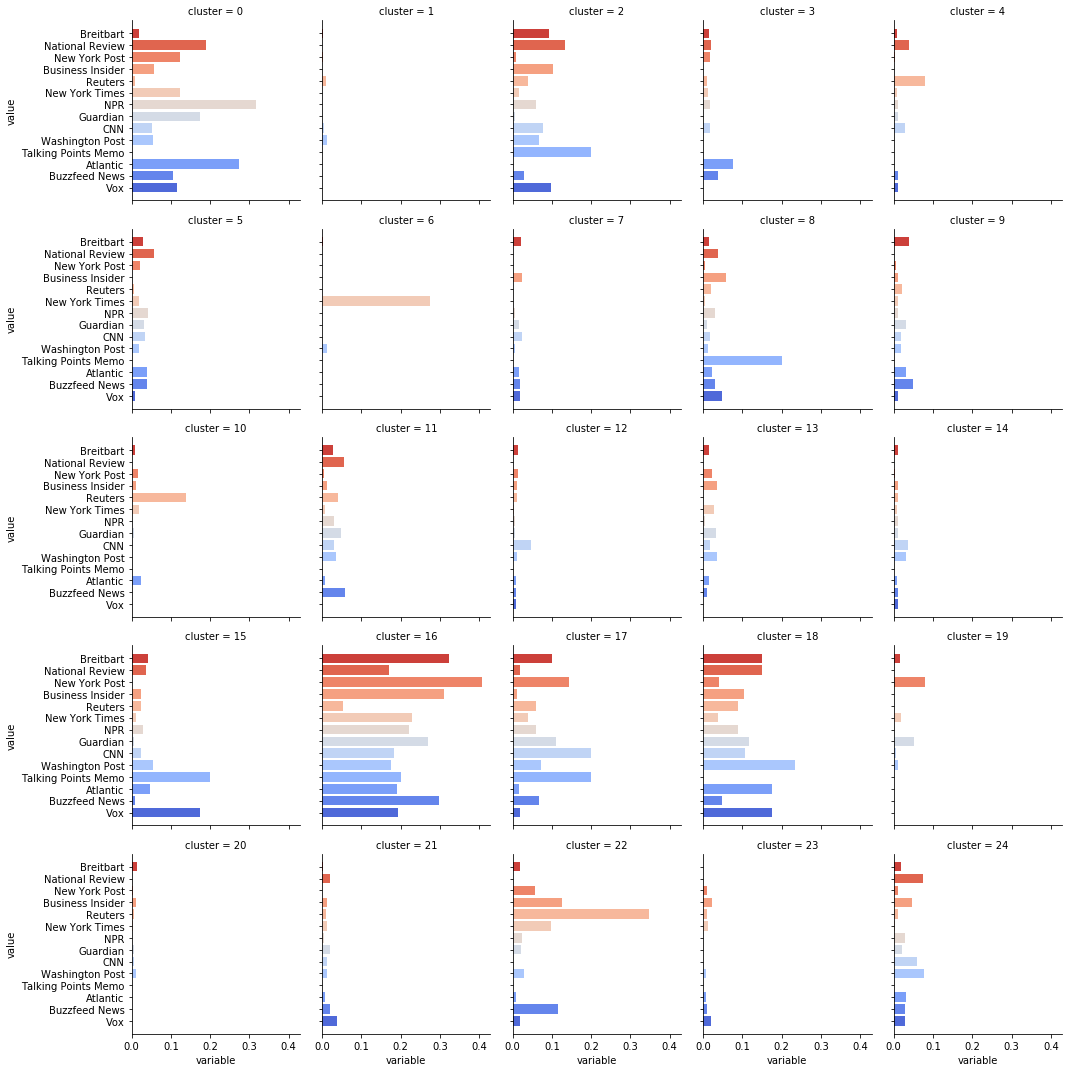

In [65]:
g = sns.FacetGrid(test_tfidf_cl25pct_long, col='cluster', col_wrap=5, hue='variable', palette='coolwarm')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

The Reuters and New York Times clusters have remained in the test set suggesting these are stable clusters. There is also a consistency in the bias shown by clusters 15 and 22.

### Overall comments on publication clusters

When using K-Means to group articles into clusters based on which publication they are from, by far the best method was to process the articles using Google's word2vec algorithm, and then extract the maximum vector for each article.

All methods tested managed to identify a mostly Reuters cluster. However, the maximum word2vec method differentiated nearly 80% of Reuters articles as well as around 40% of Breitbart articles. The method also found some stable clusters which predicted left wing and right wing bias, as well as others which reliably indicated a centrist publication.

Given a single article, currently it would not be easy to predict the publication the article came from, unless it happened to fall into one of around five clusters (the Reuters and Breitbart ones). However, it may be possible to improve on the current clustering by changing the clustering algorithm (e.g. MiniBatchKMeans), the clustering parameters (e.g. more / fewer clusters) or the word vectors themselves (e.g. change the size, or combine with the minimum or average vectors).

### Clustering by author

It would be interesting to know whether it is possible to cluster articles for a single publication by author. If so, this would mean that the method and algorithm could predict which author had written any given article from a publication based on information about the style and content of the article.

To experiment with this, the top 10 authors from Vox were used, consisting of 117 articles in the training set.

#### Selecting the data

In [66]:
## Find the most prolific Vox authors

vox = march17news.loc[march17news['publication'] == 'Vox']
top_vox_authors = pd.DataFrame(vox.author.value_counts().head(10))
top_vox_authors

,author
Matthew Yglesias,27
Andrew Prokop,20
German Lopez,20
Zack Beauchamp,18
Sarah Kliff,17
Julia Belluz,15
Ezra Klein,14
Dylan Matthews,13
Timothy B. Lee,12
Brian Resnick,11


In [67]:
## Select the article id and the corresponding author from the training set

train_authors = train.loc[train['author'].isin(top_vox_authors.index), ['article_id', 'author']]
train_authors.head()

,article_id,author
87,8673,Julia Belluz
110,8909,Sarah Kliff
166,8778,Matthew Yglesias
306,8618,Matthew Yglesias
395,8629,Matthew Yglesias


In [283]:
test_authors = test.loc[test['author'].isin(top_vox_authors.index), ['article_id', 'author']]
test_authors.head()

,article_id,author
78,8729,Timothy B. Lee
79,8866,Matthew Yglesias
93,8805,Zack Beauchamp
106,8787,Brian Resnick
149,8603,Timothy B. Lee


In [284]:
## Count number of articles by each author for percentage calculations

auth_counts_train = pd.DataFrame(train_authors['author'].value_counts())
auth_counts_test = pd.DataFrame(test_authors['author'].value_counts())

In [69]:
## Formula to convert results into percentages within each cluster

def table_auth_pct(df, totals):
    df_new = pd.DataFrame(columns=train_authors['author'])
    for row in df.index:
        for pub in totals.index:
            df_new.loc[row, pub] = df.loc[row, pub] / totals.loc[pub, 'author']
    return df_new

In [311]:
## Select relevant rows from different methods

## doc2vec
x_train_d2v_vox = x_train_d2v.loc[x_train_d2v.index.isin(train_authors.index), ]
x_test_d2v_vox = x_test_d2v.loc[x_test_d2v.index.isin(test_authors.index), ]

## Google word2vec average
av_train_g1 = pd.DataFrame(av_train_g1)
av_train_g1_vox = av_train_g1.loc[av_train_g1.index.isin(train_authors.index), ]
av_test_g1 = pd.DataFrame(av_test_g1)
av_test_g1_vox = av_test_g1.loc[av_test_g1.index.isin(test_authors.index), ]

## Google word2vec max
max_train_g1 = pd.DataFrame(max_train_g1)
max_train_g1_vox = max_train_g1.loc[max_train_g1.index.isin(train_authors.index), ]
max_test_g1 = pd.DataFrame(max_test_g1)
max_test_g1_vox = max_test_g1.loc[max_test_g1.index.isin(test_authors.index), ]

## BoW
x_train_bow_vox = x_train_bow.loc[x_train_bow.index.isin(train_authors.index), ]
x_test_bow_vox = x_test_bow.loc[x_test_bow.index.isin(test_authors.index), ]

## tf-idf
train_vox = train.loc[train.index.isin(train_authors.index), ]
train_str_vox = train_vox.loc[:, 'content'].values
vox_train_tfidf_v = vectorizer.fit(train_str_vox)
vox_train_tfidf = vox_train_tfidf_v.transform(train_str_vox)
print('Number of features: {}'.format(vox_train_tfidf.get_shape()[1]))
test_vox = test.loc[test.index.isin(test_authors.index), ]
test_str_vox = test_vox.loc[:, 'content'].values
vox_test_tfidf = vox_train_tfidf_v.transform(test_str_vox)
print('Number of features: {}'.format(vox_test_tfidf.get_shape()[1]))

Number of features: 1162
Number of features: 1162


To visualize the clusters of articles the features need to be transformed into two dimensions. This has been done using PCA, which is a technique that reduces the information contained in a certain number of features into a smaller number - in this case 2.

In [71]:
## PCA each method to allow plotting in two dimensions

pca_vox_2d = PCA(n_components=2, random_state=76)

## doc2vec
x_train_d2v_vox_pca = pca_vox_2d.fit_transform(x_train_d2v_vox)
x_train_d2v_vox_pca = pd.DataFrame(x_train_d2v_vox_pca)

## Google word2vec average
av_train_g1_vox_pca = pca_vox_2d.fit_transform(av_train_g1_vox)
av_train_g1_vox_pca = pd.DataFrame(av_train_g1_vox_pca)

## Google word2vec max
max_train_g1_vox_pca = pca_vox_2d.fit_transform(max_train_g1_vox)
max_train_g1_vox_pca = pd.DataFrame(max_train_g1_vox_pca)

## BoW
x_train_bow_vox_pca = pca_vox_2d.fit_transform(x_train_bow_vox)
x_train_bow_vox_pca = pd.DataFrame(x_train_bow_vox_pca)

## tfidf - doesn't work for sparse matrices
#vox_train_tfidf_pca = pca_vox_2d.fit_transform(vox_train_tfidf)

#### doc2vec

The actual distribution of authors in two dimensional space using doc2vec and PCA is shown below.

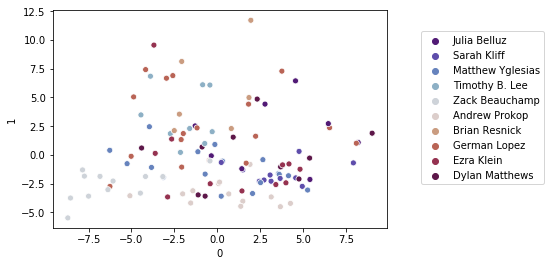

In [72]:
sns.scatterplot(x=x_train_d2v_vox_pca[0], 
                y=x_train_d2v_vox_pca[1], 
                hue=train_authors['author'].values, 
                palette=sns.color_palette('twilight_shifted', 10))
plt.legend(loc=(1.1, 0.2))
plt.show()

Some authors are clearly in one area of the graph, although there are no distinct clusters here. However, this is an approximation of multiple dimensions into two dimensions so the fact that no clusters are clearly discernable does not mean the algorithm won't find any.

In [288]:
## 10 clusters

kmeans_train_d2v_vox_10 = KMeans(n_clusters=10, random_state=76).fit(x_train_d2v_vox)
ypred_train_d2v_vox_10 = kmeans_train_d2v_vox_10.predict(x_train_d2v_vox)

train_d2v_vox_cl10 = pd.crosstab(ypred_train_d2v_vox_10, train_authors['author'])
train_d2v_vox_cl10pct = table_auth_pct(train_d2v_vox_cl10, auth_counts_train)
train_d2v_vox_cl10pct.reset_index(inplace=True)
train_d2v_vox_cl10pct.rename(columns={'index': 'cluster'}, inplace=True)
train_d2v_vox_cl10pct_long = pd.melt(train_d2v_vox_cl10pct, id_vars='cluster')

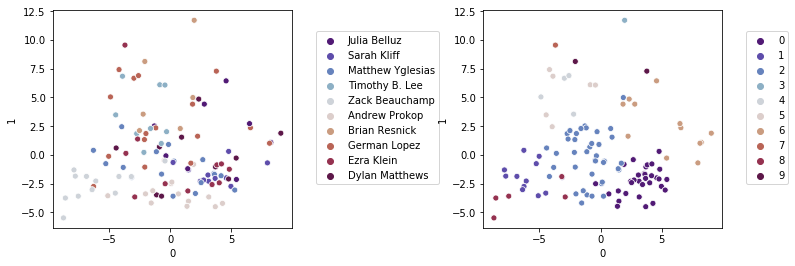

In [289]:
fig = plt.figure(figsize=(12, 4))
plt.subplots_adjust(wspace=0.8)

ax1 = fig.add_subplot(1, 2, 1)
sns.scatterplot(x=x_train_d2v_vox_pca[0], 
                y=x_train_d2v_vox_pca[1], 
                hue=train_authors['author'].values, 
                palette=sns.color_palette('twilight_shifted', 10))
plt.legend(loc=(1.1, 0.2))

ax2 = fig.add_subplot(1, 2, 2)
sns.scatterplot(x=x_train_d2v_vox_pca[0], 
                y=x_train_d2v_vox_pca[1], 
                hue=ypred_train_d2v_vox_10, 
                palette=sns.color_palette('twilight_shifted', 10))
plt.legend(loc=(1.1, 0.2))
plt.show()

The clusters found by the KMeans algorithm correspond to the actual groupings of authors in some places but not in others. The bottom left and middle shows some consistent clustering. This is more clearly seen in the bar charts below.

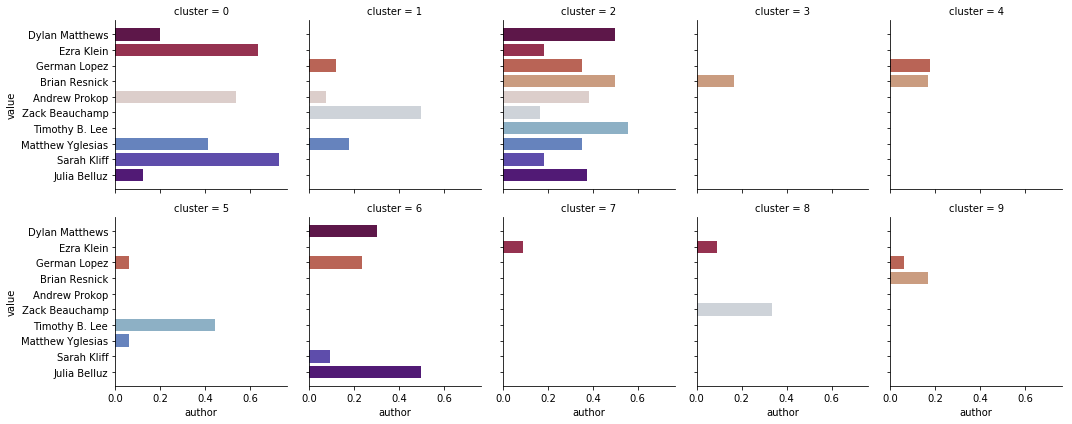

In [290]:
g = sns.FacetGrid(train_d2v_vox_cl10pct_long, col='cluster', col_wrap=5, hue='author', palette='twilight_shifted')
g = g.map(plt.barh, 'author', 'value')
plt.show()

Reasonably good clusters have been found for two authors - Zack Beauchamp (1), and Timothy B Lee (5).

It is possible that ten is not the optimal number of clusters. The graphs below show the results using a different number of clusters - 11, 12, and 9.

In [291]:
## 11 clusters

kmeans_train_d2v_vox_11 = KMeans(n_clusters=11, random_state=76).fit(x_train_d2v_vox)
ypred_train_d2v_vox_11 = kmeans_train_d2v_vox_11.predict(x_train_d2v_vox)

train_d2v_vox_cl11 = pd.crosstab(ypred_train_d2v_vox_11, train_authors['author'])
train_d2v_vox_cl11pct = table_auth_pct(train_d2v_vox_cl11, auth_counts_train)
train_d2v_vox_cl11pct.reset_index(inplace=True)
train_d2v_vox_cl11pct.rename(columns={'index': 'cluster'}, inplace=True)
train_d2v_vox_cl11pct_long = pd.melt(train_d2v_vox_cl11pct, id_vars='cluster')

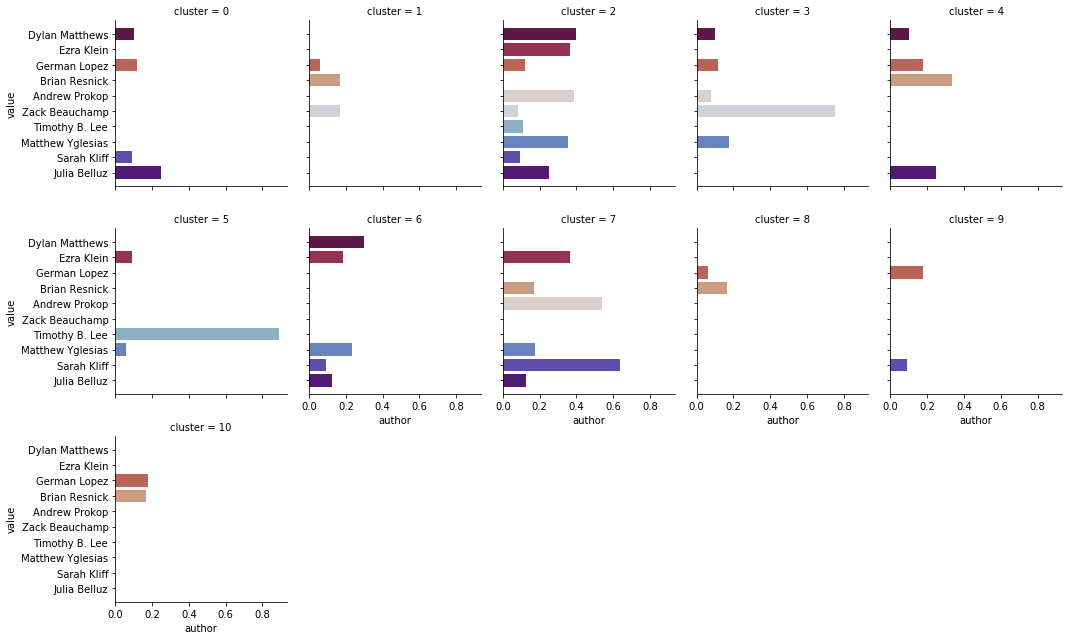

In [292]:
g = sns.FacetGrid(train_d2v_vox_cl11pct_long, col='cluster', col_wrap=5, hue='author', palette='twilight_shifted')
g = g.map(plt.barh, 'author', 'value')
plt.show()

In [78]:
## 12 clusters

kmeans_train_d2v_vox_12 = KMeans(n_clusters=12, random_state=76).fit(x_train_d2v_vox)
ypred_train_d2v_vox_12 = kmeans_train_d2v_vox_12.predict(x_train_d2v_vox)

train_d2v_vox_cl12 = pd.crosstab(ypred_train_d2v_vox_12, train_authors['author'])
train_d2v_vox_cl12pct = table_auth_pct(train_d2v_vox_cl12, auth_counts_train)
train_d2v_vox_cl12pct.reset_index(inplace=True)
train_d2v_vox_cl12pct.rename(columns={'index': 'cluster'}, inplace=True)
train_d2v_vox_cl12pct_long = pd.melt(train_d2v_vox_cl12pct, id_vars='cluster')

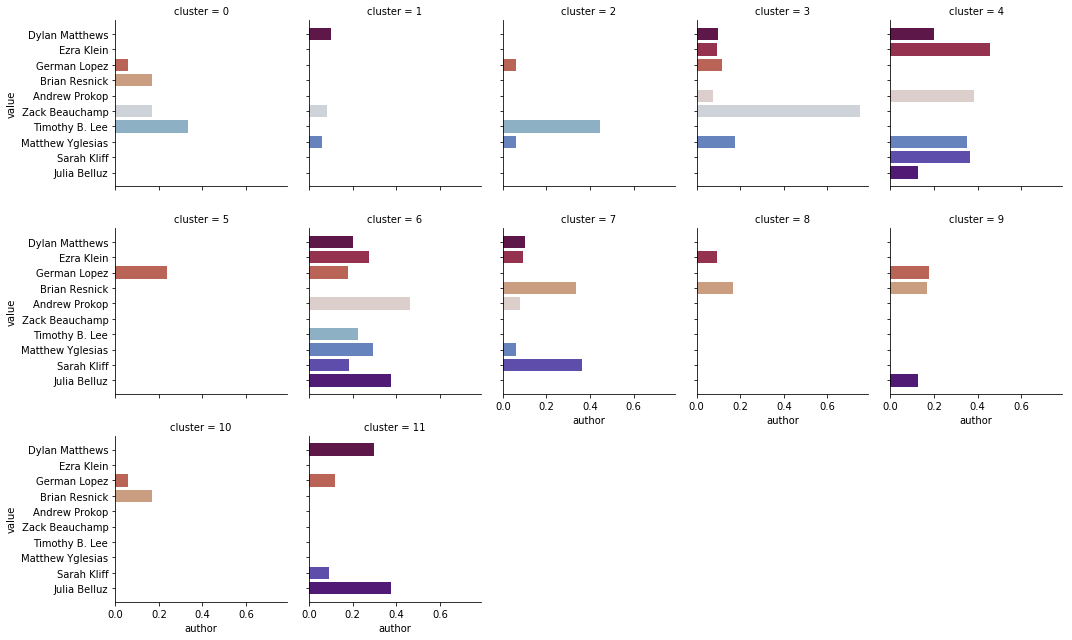

In [79]:
g = sns.FacetGrid(train_d2v_vox_cl12pct_long, col='cluster', col_wrap=5, hue='author', palette='twilight_shifted')
g = g.map(plt.barh, 'author', 'value')
plt.show()

In [80]:
## 9 clusters

kmeans_train_d2v_vox_9 = KMeans(n_clusters=9, random_state=76).fit(x_train_d2v_vox)
ypred_train_d2v_vox_9 = kmeans_train_d2v_vox_9.predict(x_train_d2v_vox)

train_d2v_vox_cl9 = pd.crosstab(ypred_train_d2v_vox_9, train_authors['author'])
train_d2v_vox_cl9pct = table_auth_pct(train_d2v_vox_cl9, auth_counts_train)
train_d2v_vox_cl9pct.reset_index(inplace=True)
train_d2v_vox_cl9pct.rename(columns={'index': 'cluster'}, inplace=True)
train_d2v_vox_cl9pct_long = pd.melt(train_d2v_vox_cl9pct, id_vars='cluster')

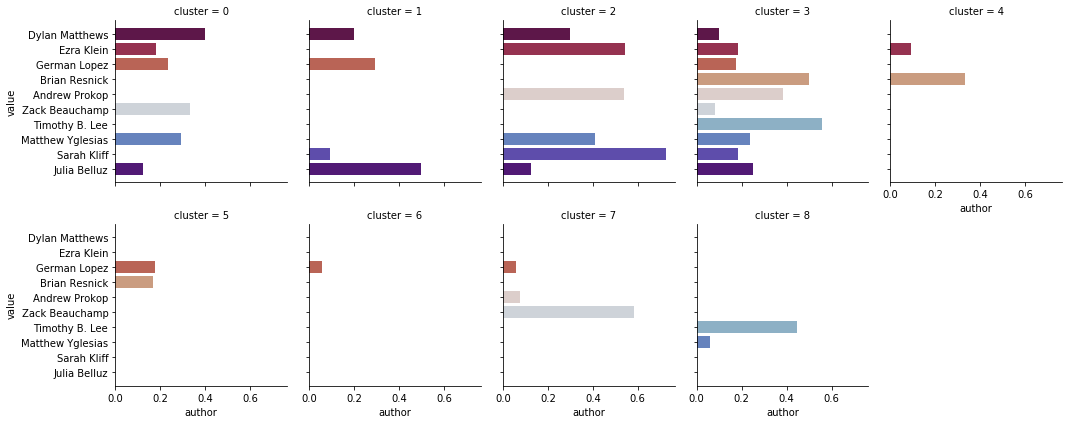

In [81]:
g = sns.FacetGrid(train_d2v_vox_cl9pct_long, col='cluster', col_wrap=5, hue='author', palette='twilight_shifted')
g = g.map(plt.barh, 'author', 'value')
plt.show()

None of these alternative number of clusters clearly differentiate between as many authors as 10 clusters. However, some interesting similarities are seen. Dara Lind is clearly clustered in all variations suggesting that this author writes particularly differently to other authors. The next most clearly defined author is probably Zack Beauchamp.

Dylan Matthews and Ezra Klein are often clustered together (sometimes with other authors), perhaps indicating that these two authors are quite similar.

This clustering technique was tested with the other methods of classifying articles to see if this improved the clusters found.

In [286]:
## Test set - 10 clusters

ypred_test_d2v_vox_10 = kmeans_train_d2v_vox_10.predict(x_test_d2v_vox)

test_d2v_vox_cl10 = pd.crosstab(ypred_test_d2v_vox_10, test_authors['author'])
test_d2v_vox_cl10pct = table_auth_pct(test_d2v_vox_cl10, auth_counts_test)
test_d2v_vox_cl10pct.reset_index(inplace=True)
test_d2v_vox_cl10pct.rename(columns={'index': 'cluster'}, inplace=True)
test_d2v_vox_cl10pct_long = pd.melt(test_d2v_vox_cl10pct, id_vars='cluster')

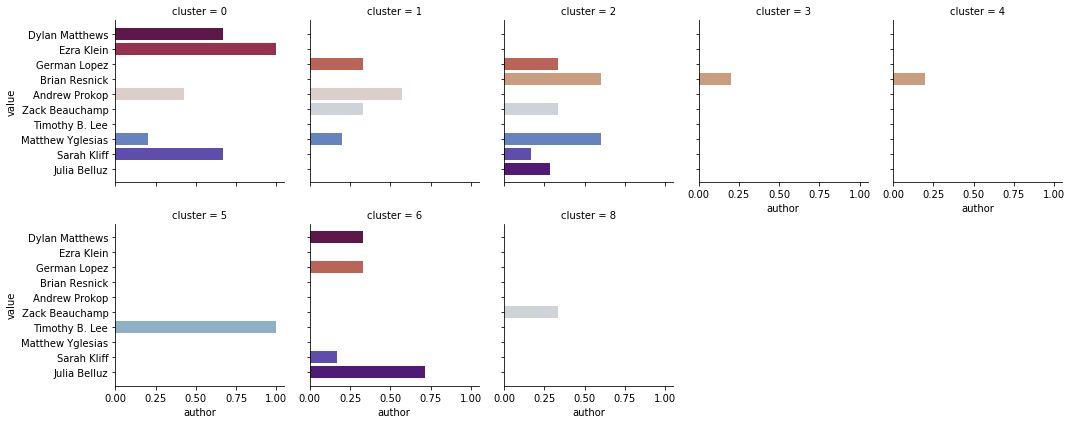

In [287]:
g = sns.FacetGrid(test_d2v_vox_cl10pct_long, col='cluster', col_wrap=5, hue='author', palette='twilight_shifted')
g = g.map(plt.barh, 'author', 'value')
plt.show()

The Timothy B Lee cluster (5) appears stable but the Zack Beauchamp one (2) does not.

#### word2vec average

In [293]:
## 10 clusters

kmeans_train_av_g1_vox_10 = KMeans(n_clusters=10, random_state=76).fit(av_train_g1_vox)
ypred_train_av_g1_vox_10 = kmeans_train_av_g1_vox_10.predict(av_train_g1_vox)

train_av_g1_vox_cl10 = pd.crosstab(ypred_train_av_g1_vox_10, train_authors['author'])
train_av_g1_vox_cl10pct = table_auth_pct(train_av_g1_vox_cl10, auth_counts_train)
train_av_g1_vox_cl10pct.reset_index(inplace=True)
train_av_g1_vox_cl10pct.rename(columns={'index': 'cluster'}, inplace=True)
train_av_g1_vox_cl10pct_long = pd.melt(train_av_g1_vox_cl10pct, id_vars='cluster')

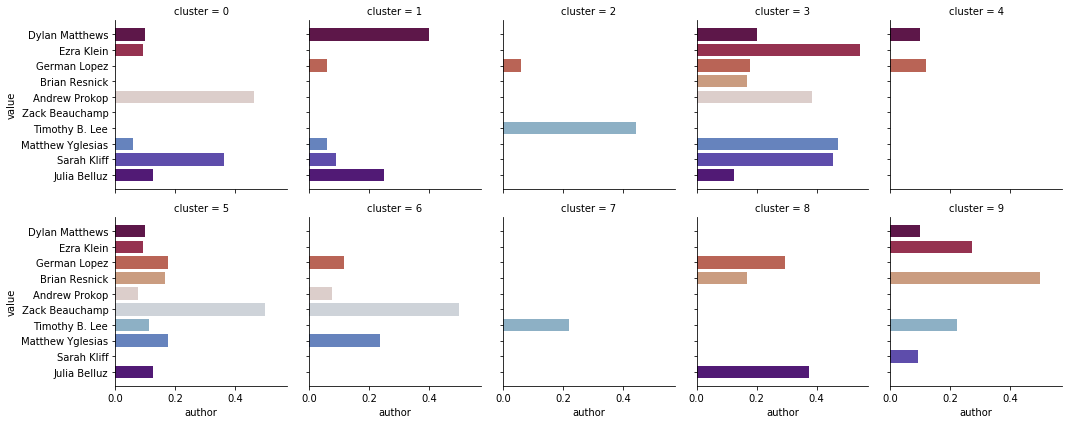

In [294]:
g = sns.FacetGrid(train_av_g1_vox_cl10pct_long, col='cluster', col_wrap=5, hue='author', palette='twilight_shifted')
g = g.map(plt.barh, 'author', 'value')
plt.show()

In [295]:
## Test set - 10 clusters

ypred_test_av_g1_vox_10 = kmeans_train_av_g1_vox_10.predict(av_test_g1_vox)

test_av_g1_vox_cl10 = pd.crosstab(ypred_test_av_g1_vox_10, test_authors['author'])
test_av_g1_vox_cl10pct = table_auth_pct(test_av_g1_vox_cl10, auth_counts_test)
test_av_g1_vox_cl10pct.reset_index(inplace=True)
test_av_g1_vox_cl10pct.rename(columns={'index': 'cluster'}, inplace=True)
test_av_g1_vox_cl10pct_long = pd.melt(test_av_g1_vox_cl10pct, id_vars='cluster')

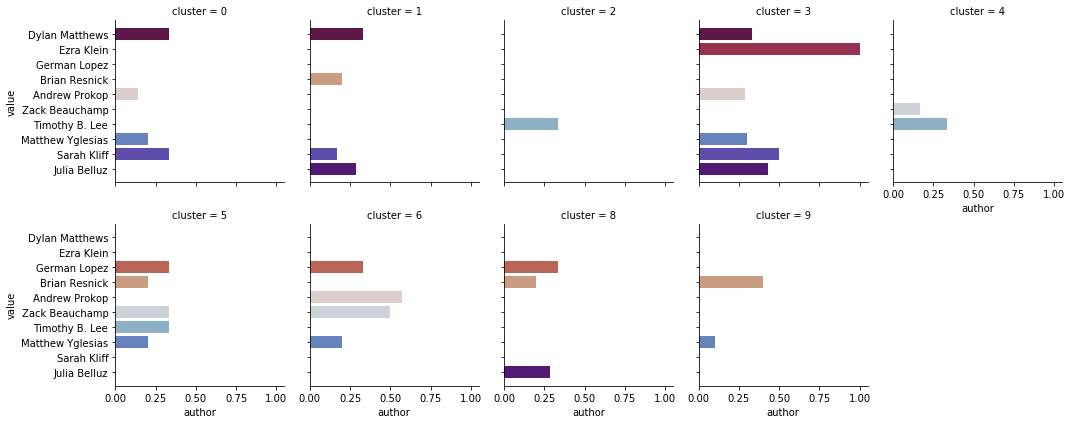

In [296]:
g = sns.FacetGrid(test_av_g1_vox_cl10pct_long, col='cluster', col_wrap=5, hue='author', palette='twilight_shifted')
g = g.map(plt.barh, 'author', 'value')
plt.show()

None of these clusters appear stable.

#### word2vec maximum

In [84]:
## 10 clusters

kmeans_train_max_g1_vox_10 = KMeans(n_clusters=10, random_state=76).fit(max_train_g1_vox)
ypred_train_max_g1_vox_10 = kmeans_train_max_g1_vox_10.predict(max_train_g1_vox)

train_max_g1_vox_cl10 = pd.crosstab(ypred_train_max_g1_vox_10, train_authors['author'])
train_max_g1_vox_cl10pct = table_auth_pct(train_max_g1_vox_cl10, auth_counts_train)
train_max_g1_vox_cl10pct.reset_index(inplace=True)
train_max_g1_vox_cl10pct.rename(columns={'index': 'cluster'}, inplace=True)
train_max_g1_vox_cl10pct_long = pd.melt(train_max_g1_vox_cl10pct, id_vars='cluster')

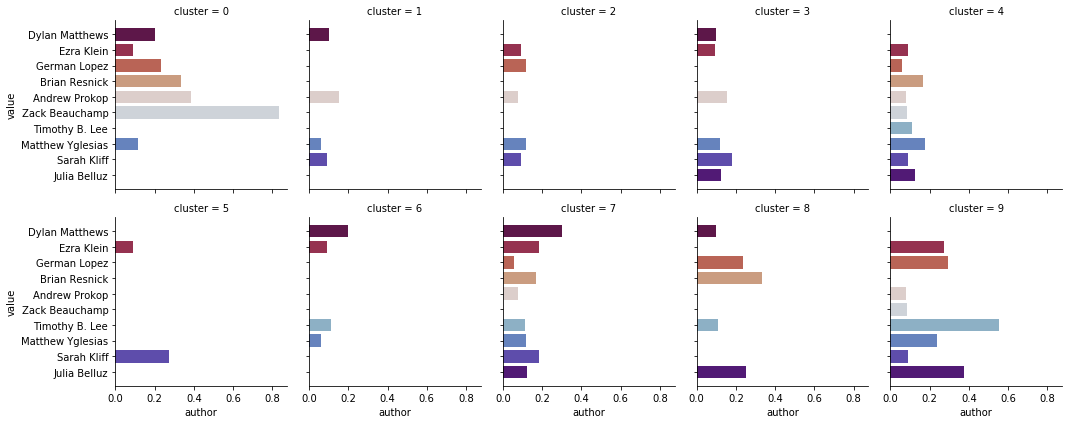

In [85]:
g = sns.FacetGrid(train_max_g1_vox_cl10pct_long, col='cluster', col_wrap=5, hue='author', palette='twilight_shifted')
g = g.map(plt.barh, 'author', 'value')
plt.show()

Interestingly, despite being the best predictor for publications, the maximum word2vec method does not discern well between different authors. Most clusters have a mix of all authors.

This could be because word2vec maximums capture a general theme, or feeling, from an article. This might be a good predictor of a publication because publications have particular topics, or themes, that they return to. For example, more left leaning publications may write more about environmental issues, whereas right leaning ones may write more about business. However, authors for a specific publication may write about a range of different issues, meaning that grouping by themes is not a good way to find groups of authors.

In [306]:
## Test set - 10 clusters

ypred_test_max_g1_vox_10 = kmeans_train_max_g1_vox_10.predict(max_test_g1_vox)

test_max_g1_vox_cl10 = pd.crosstab(ypred_test_max_g1_vox_10, test_authors['author'])
test_max_g1_vox_cl10pct = table_auth_pct(test_max_g1_vox_cl10, auth_counts_test)
test_max_g1_vox_cl10pct.reset_index(inplace=True)
test_max_g1_vox_cl10pct.rename(columns={'index': 'cluster'}, inplace=True)
test_max_g1_vox_cl10pct_long = pd.melt(test_max_g1_vox_cl10pct, id_vars='cluster')

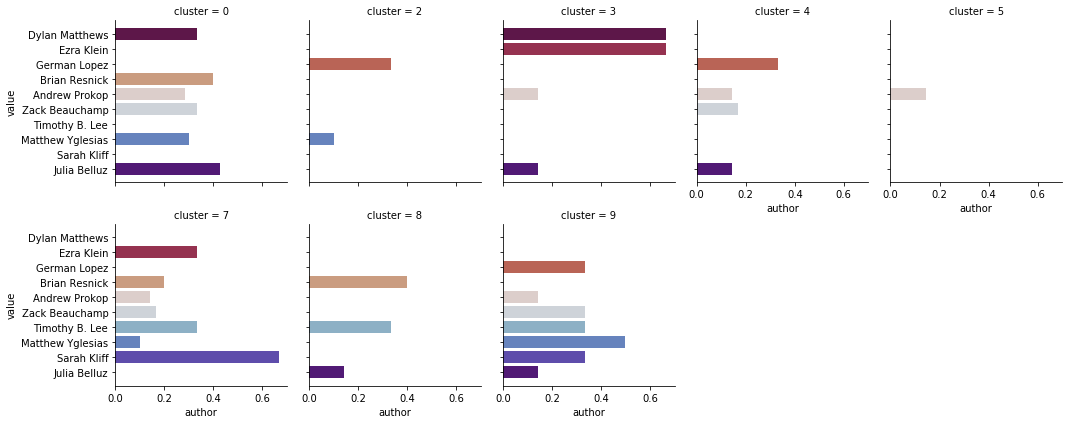

In [307]:
g = sns.FacetGrid(test_max_g1_vox_cl10pct_long, col='cluster', col_wrap=5, hue='author', palette='twilight_shifted')
g = g.map(plt.barh, 'author', 'value')
plt.show()

Not useful clusters.

#### Bag of Words

In [86]:
## 10 clusters

kmeans_train_bow_vox_10 = KMeans(n_clusters=10, random_state=76).fit(x_train_bow_vox)
ypred_train_bow_vox_10 = kmeans_train_bow_vox_10.predict(x_train_bow_vox)

train_bow_vox_cl10 = pd.crosstab(ypred_train_bow_vox_10, train_authors['author'])
train_bow_vox_cl10pct = table_auth_pct(train_bow_vox_cl10, auth_counts_train)
train_bow_vox_cl10pct.reset_index(inplace=True)
train_bow_vox_cl10pct.rename(columns={'index': 'cluster'}, inplace=True)
train_bow_vox_cl10pct_long = pd.melt(train_bow_vox_cl10pct, id_vars='cluster')

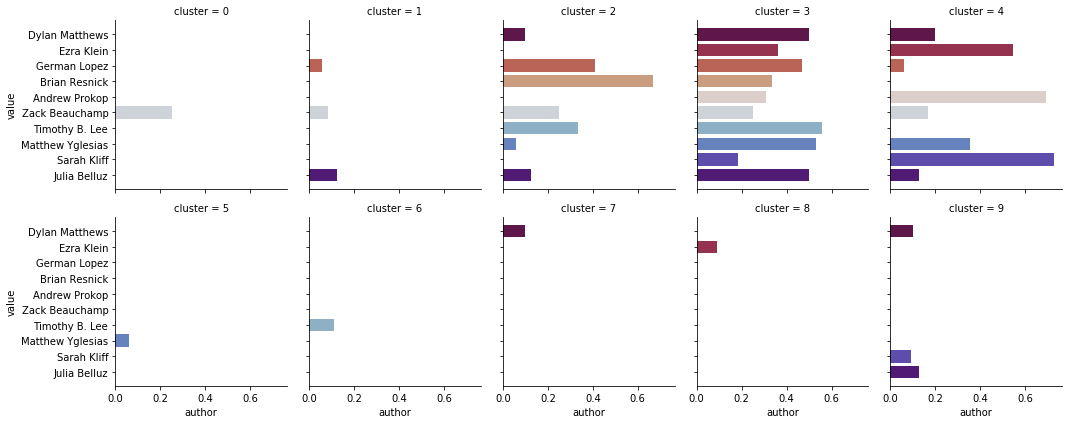

In [87]:
g = sns.FacetGrid(train_bow_vox_cl10pct_long, col='cluster', col_wrap=5, hue='author', palette='twilight_shifted')
g = g.map(plt.barh, 'author', 'value')
plt.show()

Similarly to word2vec maximum, bag of words is not good at differentiating between different authors. Clusters here either have a jumble of many authors, or just contain one or two articles from a single author which is not large enough to be relevant or likely replicable.

In [308]:
## Test set - 10 clusters

ypred_test_bow_vox_10 = kmeans_train_bow_vox_10.predict(x_test_bow_vox)

test_bow_vox_cl10 = pd.crosstab(ypred_test_bow_vox_10, test_authors['author'])
test_bow_vox_cl10pct = table_auth_pct(test_bow_vox_cl10, auth_counts_test)
test_bow_vox_cl10pct.reset_index(inplace=True)
test_bow_vox_cl10pct.rename(columns={'index': 'cluster'}, inplace=True)
test_bow_vox_cl10pct_long = pd.melt(test_bow_vox_cl10pct, id_vars='cluster')

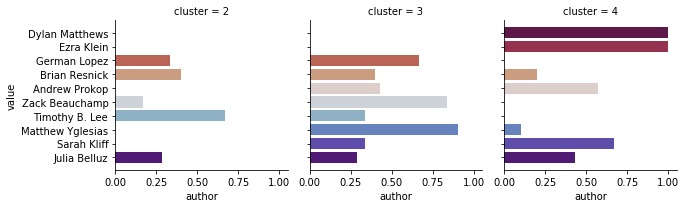

In [309]:
g = sns.FacetGrid(test_bow_vox_cl10pct_long, col='cluster', col_wrap=5, hue='author', palette='twilight_shifted')
g = g.map(plt.barh, 'author', 'value')
plt.show()

Terrible.

#### tf-idf

In [88]:
## 10 clusters

kmeans_train_tfidf_vox_10 = KMeans(n_clusters=10, random_state=76).fit(vox_train_tfidf)
ypred_train_tfidf_vox_10 = kmeans_train_tfidf_vox_10.predict(vox_train_tfidf)

train_tfidf_vox_cl10 = pd.crosstab(ypred_train_tfidf_vox_10, train_authors['author'])
train_tfidf_vox_cl10pct = table_auth_pct(train_tfidf_vox_cl10, auth_counts_train)
train_tfidf_vox_cl10pct.reset_index(inplace=True)
train_tfidf_vox_cl10pct.rename(columns={'index': 'cluster'}, inplace=True)
train_tfidf_vox_cl10pct_long = pd.melt(train_tfidf_vox_cl10pct, id_vars='cluster')

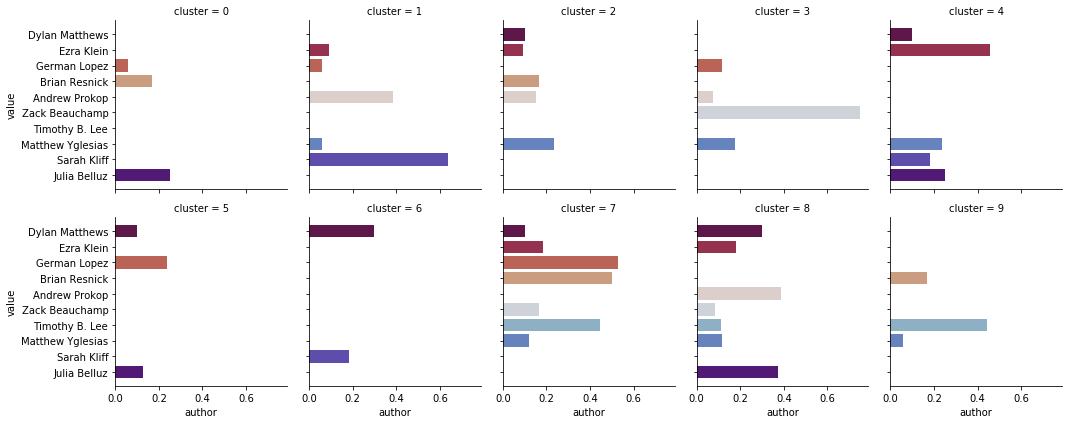

In [89]:
g = sns.FacetGrid(train_tfidf_vox_cl10pct_long, col='cluster', col_wrap=5, hue='author', palette='twilight_shifted')
g = g.map(plt.barh, 'author', 'value')
plt.show()

In [312]:
## Test set - 10 clusters

ypred_test_tfidf_vox_10 = kmeans_train_tfidf_vox_10.predict(vox_test_tfidf)

test_tfidf_vox_cl10 = pd.crosstab(ypred_test_tfidf_vox_10, test_authors['author'])
test_tfidf_vox_cl10pct = table_auth_pct(test_tfidf_vox_cl10, auth_counts_test)
test_tfidf_vox_cl10pct.reset_index(inplace=True)
test_tfidf_vox_cl10pct.rename(columns={'index': 'cluster'}, inplace=True)
test_tfidf_vox_cl10pct_long = pd.melt(test_tfidf_vox_cl10pct, id_vars='cluster')

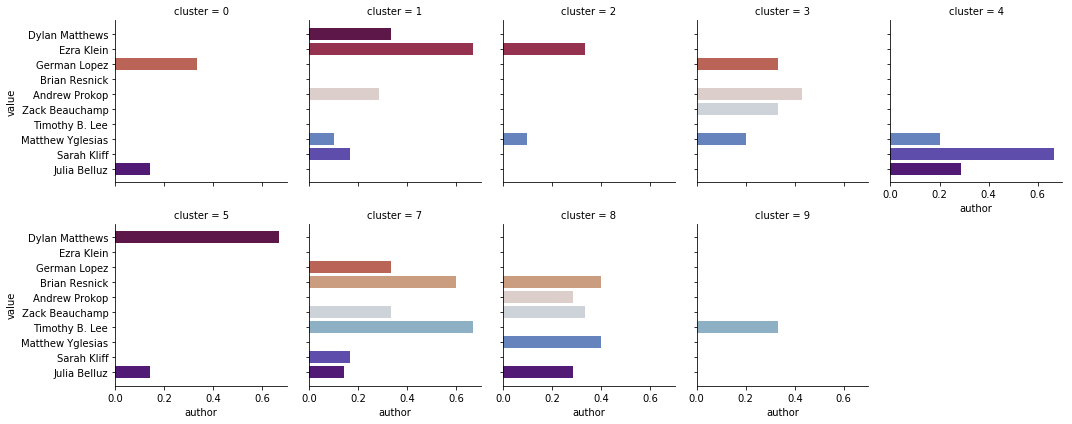

In [313]:
g = sns.FacetGrid(test_tfidf_vox_cl10pct_long, col='cluster', col_wrap=5, hue='author', palette='twilight_shifted')
g = g.map(plt.barh, 'author', 'value')
plt.show()

### Overall comments on author clusters

None of these methods generated reliable and stable clusters.

The best publication clustering method, word2vec maximum, was particularly bad at differentiating between different authors. It is possible that this is because the similarities between articles in a certain publication are different to the similarities between articles written by a certain authors. The different methods used to transform the articles emphasise different features, so this may account for the variation in performance on the two different tasks.

### Further work

This work on clustering looked at five different methods of transforming the articles into modelable data, but only used one clustering algorithm (KMeans). Further work could test different clustering algorithms to see if these improved the clusters found. Additionally, further work could be done exploring the optimal number of clusters to use, as here only a small number of variations were tested.

It would also be interesting to try combining some of the methods to see if this would help the identification of publications and authors. Combining the best publication method (word2vec maximum) and author method (doc2vec / word2vec average) may allow a model to identify both publication and author more successfully and improve both clusters.

## Modeling

### Predicting publication the article is from

Several models were used to test whether it is possible to predict which publication an article was written for based on the content of the article itself. The models were first trained on the training data and then tested on the testing data. This was important because some algorithms, e.g. Random Forest, gave 100% accuracy when predicting on the training set due to overfitting.

In [90]:
y_train = train['publication']
y_test = test['publication']

In [126]:
## doc2vec
## Shift by 10 so no negative numbers (lowest number is -8.25)

x_train_d2v_shift = x_train_d2v + 10
x_test_d2v_shift = x_test_d2v + 10

## word2vec average
## Shift by 1 so no negative numbers (lowest number is -0.36)

av_train_g1_shift = av_train_g1 + 1
av_test_g1_shift = pd.DataFrame(av_test_g1) + 1

## word2vec maximum
## Shift by 1 so no negative numbers (lowest number is -0.36)

max_train_g1_shift = max_train_g1 + 1
max_test_g1_shift = pd.DataFrame(max_test_g1) + 1

#### Multinomial Naive Bayes

In [91]:
mNB = MultinomialNB()

In [214]:
## doc2vec

mNB.fit(x_train_d2v_shift, y_train)

## Cross validation to get accuracy on training set
cv_d2v_mNB = cross_val_score(mNB, x_train_d2v_shift, y_train, cv=5)
cv_d2v_mNB

array([0.31276006, 0.31410702, 0.31615599, 0.328223  , 0.31097135])

In [437]:
cv_d2v_mNB.mean()

0.31644348166446956

In [215]:
ypred_d2v_mNB = mNB.predict(x_test_d2v_shift)
table_d2v_mNB = pd.crosstab(ypred_d2v_mNB, y_test)
test_d2v_mNBpct = table_pct(table_d2v_mNB, pub_counts_test)
test_d2v_mNBpct.reset_index(inplace=True)
test_d2v_mNBpct.rename(columns={'index': 'prediction'}, inplace=True)
test_d2v_mNBpct_long = pd.melt(test_d2v_mNBpct, id_vars='prediction')

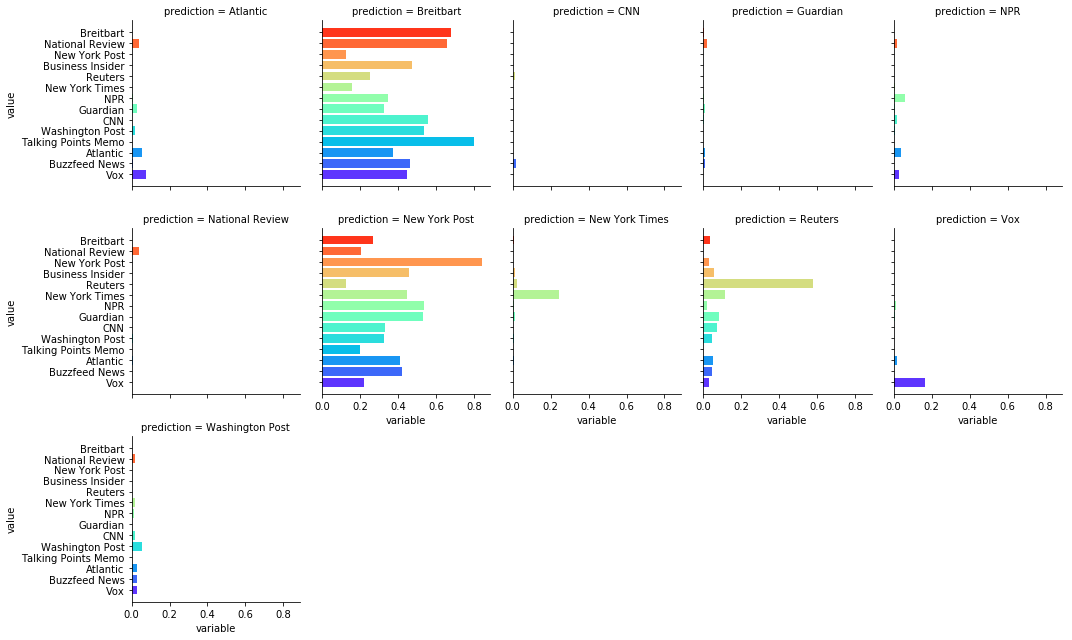

In [216]:
g = sns.FacetGrid(test_d2v_mNBpct_long, col='prediction', col_wrap=5, hue='variable', palette='rainbow')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

In [217]:
## word2vec average

mNB.fit(av_train_g1_shift, y_train)

cv_av_g1_mNB = cross_val_score(mNB, av_train_g1_shift, y_train, cv=5)
cv_av_g1_mNB

array([0.16643551, 0.16678249, 0.16643454, 0.16655052, 0.16701607])

In [438]:
cv_av_g1_mNB.mean()

0.16664382595892285

In [218]:
ypred_av_g1_mNB = mNB.predict(av_test_g1_shift)
table_av_g1_mNB = pd.crosstab(ypred_av_g1_mNB, y_test)
test_av_g1_mNBpct = table_pct(table_av_g1_mNB, pub_counts_test)
test_av_g1_mNBpct.reset_index(inplace=True)
test_av_g1_mNBpct.rename(columns={'index': 'prediction'}, inplace=True)
test_av_g1_mNBpct_long = pd.melt(test_av_g1_mNBpct, id_vars='prediction')

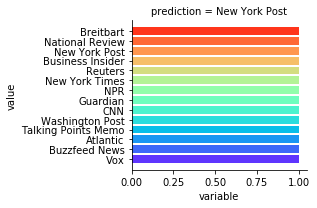

In [219]:
g = sns.FacetGrid(test_av_g1_mNBpct_long, col='prediction', col_wrap=5, hue='variable', palette='rainbow')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

In [220]:
## word2vec maximum

mNB.fit(max_train_g1_shift, y_train)

cv_max_g1_mNB = cross_val_score(mNB, max_train_g1_shift, y_train, cv=5)
cv_max_g1_mNB

array([0.25658807, 0.25851286, 0.26044568, 0.25714286, 0.25366876])

In [439]:
cv_max_g1_mNB.mean()

0.25727164619379855

In [221]:
ypred_max_g1_mNB = mNB.predict(max_test_g1_shift)
table_max_g1_mNB = pd.crosstab(ypred_max_g1_mNB, y_test)
test_max_g1_mNBpct = table_pct(table_max_g1_mNB, pub_counts_test)
test_max_g1_mNBpct.reset_index(inplace=True)
test_max_g1_mNBpct.rename(columns={'index': 'prediction'}, inplace=True)
test_max_g1_mNBpct_long = pd.melt(test_max_g1_mNBpct, id_vars='prediction')

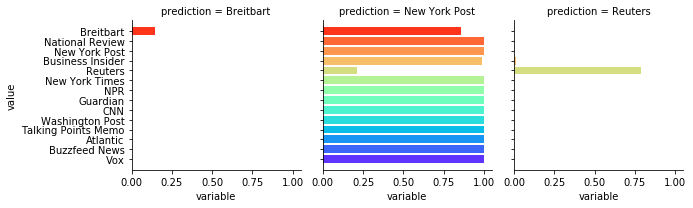

In [222]:
g = sns.FacetGrid(test_max_g1_mNBpct_long, col='prediction', col_wrap=5, hue='variable', palette='rainbow')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

In [223]:
## Bag of Words

mNB.fit(x_train_bow, y_train)

cv_bow_mNB = cross_val_score(mNB, x_train_bow, y_train, cv=5)
cv_bow_mNB

array([0.52565881, 0.53161918, 0.51532033, 0.50731707, 0.49196366])

In [440]:
cv_bow_mNB.mean()

0.5143758112811719

In [224]:
ypred_bow_mNB = mNB.predict(x_test_bow)
table_bow_mNB = pd.crosstab(ypred_bow_mNB, y_test)
test_bow_mNBpct = table_pct(table_bow_mNB, pub_counts_test)
test_bow_mNBpct.reset_index(inplace=True)
test_bow_mNBpct.rename(columns={'index': 'prediction'}, inplace=True)
test_bow_mNBpct_long = pd.melt(test_bow_mNBpct, id_vars='prediction')

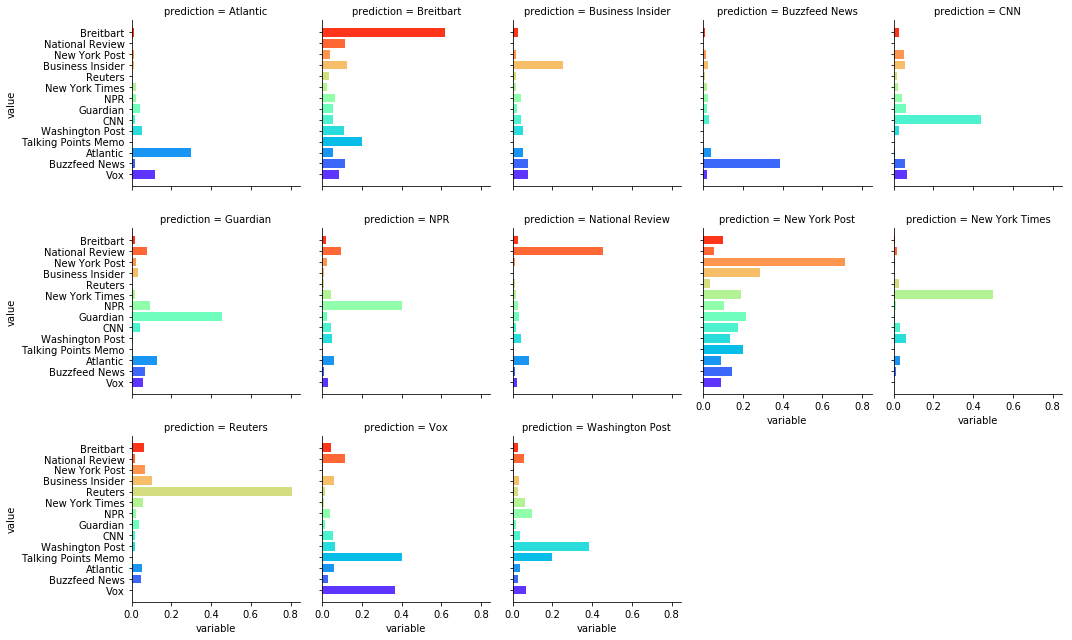

In [225]:
g = sns.FacetGrid(test_bow_mNBpct_long, col='prediction', col_wrap=5, hue='variable', palette='rainbow')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

In [226]:
## tfidf

mNB.fit(x_train_tfidf, y_train)

cv_tfidf_mNB = cross_val_score(mNB, x_train_tfidf, y_train, cv=5)
cv_tfidf_mNB

array([0.39389736, 0.38637943, 0.40041783, 0.40139373, 0.39273235])

In [441]:
cv_tfidf_mNB.mean()

0.39496414108970734

In [227]:
ypred_tfidf_mNB = mNB.predict(x_test_tfidf)
table_tfidf_mNB = pd.crosstab(ypred_tfidf_mNB, y_test)
test_tfidf_mNBpct = table_pct(table_tfidf_mNB, pub_counts_test)
test_tfidf_mNBpct.reset_index(inplace=True)
test_tfidf_mNBpct.rename(columns={'index': 'prediction'}, inplace=True)
test_tfidf_mNBpct_long = pd.melt(test_tfidf_mNBpct, id_vars='prediction')

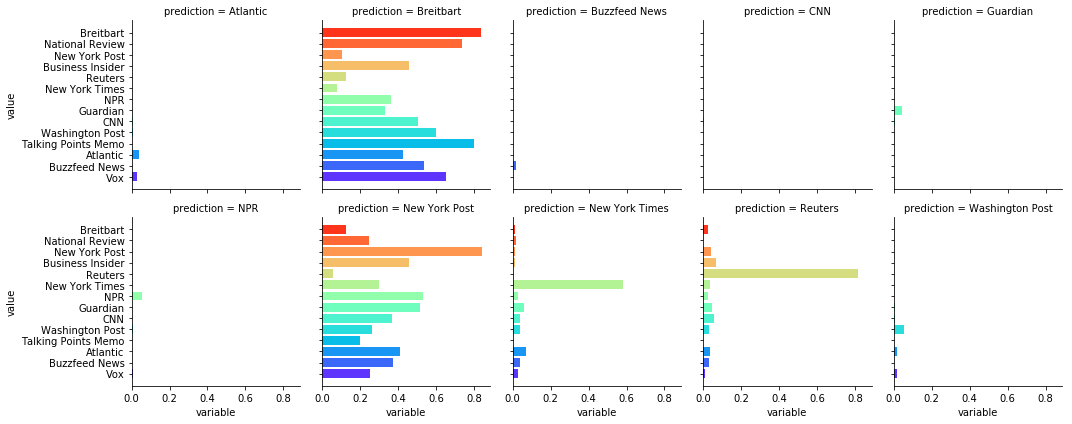

In [228]:
g = sns.FacetGrid(test_tfidf_mNBpct_long, col='prediction', col_wrap=5, hue='variable', palette='rainbow')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

The predictive power of the multinominal Naive Bayes algorithm varies immensely depending on the method used to convert the articles into numeric data.

Using the word2vec average method in this instance was basically useless as the model predicted every article to come from a single publication - the New York Post. However, the bag of words method was excellent, with a predictive accuracy (in the training set) of around 50%. Considering there are 15 different publications this is an impressive rate.

Reuters appears to be the easiest publication to predict, or at least separate from the other publications, as this was predicted over 75% of the time using the word2vec maximum and tfidf methods as well as the bag of words, and around 60% of the time with the doc2vec method. The New York Post appears to be the most difficult to identify - often several other publications are predicted to be the New York Post. This is very likely to be because it is the most common publication in the dataset so the predictions are weighted towards it. (Reuters interestingly is the fourth most common publication in the dataset but does not appear to suffer from a similar issue).

#### Logistic Regression

In [229]:
lr = LogisticRegression(random_state=76, 
                        class_weight='balanced', 
                        solver='lbfgs', 
                        multi_class='multinomial', 
                        max_iter=500)

In [230]:
## doc2vec

lr.fit(x_train_d2v, y_train)

cv_d2v_lr = cross_val_score(lr, x_train_d2v, y_train, cv=5)
cv_d2v_lr

array([0.40291262, 0.38985407, 0.37883008, 0.38327526, 0.39412998])

In [442]:
cv_d2v_lr.mean()

0.389800402121501

In [231]:
ypred_d2v_lr = lr.predict(x_test_d2v)
table_d2v_lr = pd.crosstab(ypred_d2v_lr, y_test)
test_d2v_lrpct = table_pct(table_d2v_lr, pub_counts_test)
test_d2v_lrpct.reset_index(inplace=True)
test_d2v_lrpct.rename(columns={'index': 'prediction'}, inplace=True)
test_d2v_lrpct_long = pd.melt(test_d2v_lrpct, id_vars='prediction')

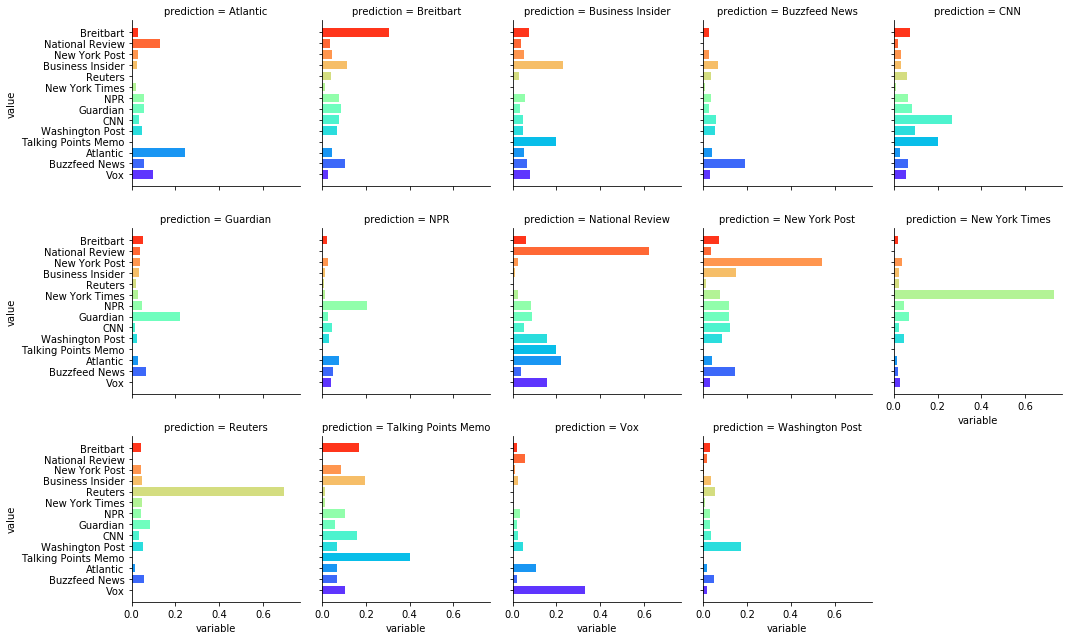

In [232]:
g = sns.FacetGrid(test_d2v_lrpct_long, col='prediction', col_wrap=5, hue='variable', palette='rainbow')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

In [233]:
## word2vec average

lr.fit(av_train_g1, y_train)

cv_av_g1_lr = cross_val_score(lr, av_train_g1, y_train, cv=5)
cv_av_g1_lr

array([0.39320388, 0.40444753, 0.39066852, 0.38815331, 0.39273235])

In [443]:
cv_av_g1_lr.mean()

0.3938411210564191

In [234]:
ypred_av_g1_lr = lr.predict(av_test_g1)
table_av_g1_lr = pd.crosstab(ypred_av_g1_lr, y_test)
test_av_g1_lrpct = table_pct(table_av_g1_lr, pub_counts_test)
test_av_g1_lrpct.reset_index(inplace=True)
test_av_g1_lrpct.rename(columns={'index': 'prediction'}, inplace=True)
test_av_g1_lrpct_long = pd.melt(test_av_g1_lrpct, id_vars='prediction')

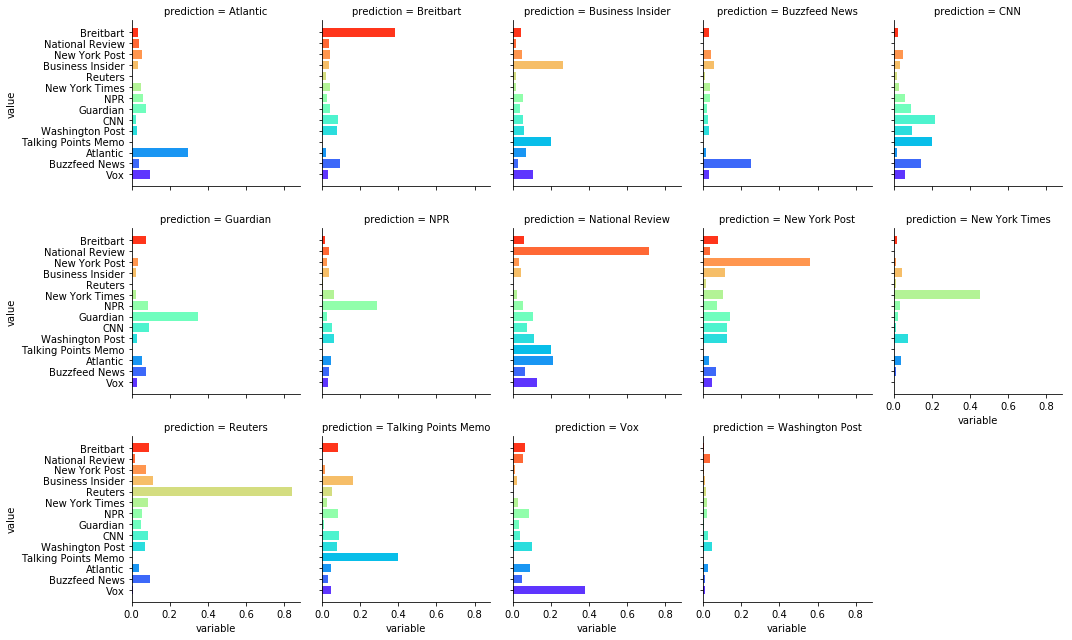

In [235]:
g = sns.FacetGrid(test_av_g1_lrpct_long, col='prediction', col_wrap=5, hue='variable', palette='rainbow')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

In [236]:
## word2vec maximum

lr.fit(max_train_g1, y_train)

cv_max_g1_lr = cross_val_score(lr, max_train_g1, y_train, cv=5)
cv_max_g1_lr

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local

array([0.44174757, 0.44544823, 0.4310585 , 0.43484321, 0.43675751])

In [444]:
cv_max_g1_lr.mean()

0.4379710028754902

In [237]:
ypred_max_g1_lr = lr.predict(max_test_g1)
table_max_g1_lr = pd.crosstab(ypred_max_g1_lr, y_test)
test_max_g1_lrpct = table_pct(table_max_g1_lr, pub_counts_test)
test_max_g1_lrpct.reset_index(inplace=True)
test_max_g1_lrpct.rename(columns={'index': 'prediction'}, inplace=True)
test_max_g1_lrpct_long = pd.melt(test_max_g1_lrpct, id_vars='prediction')

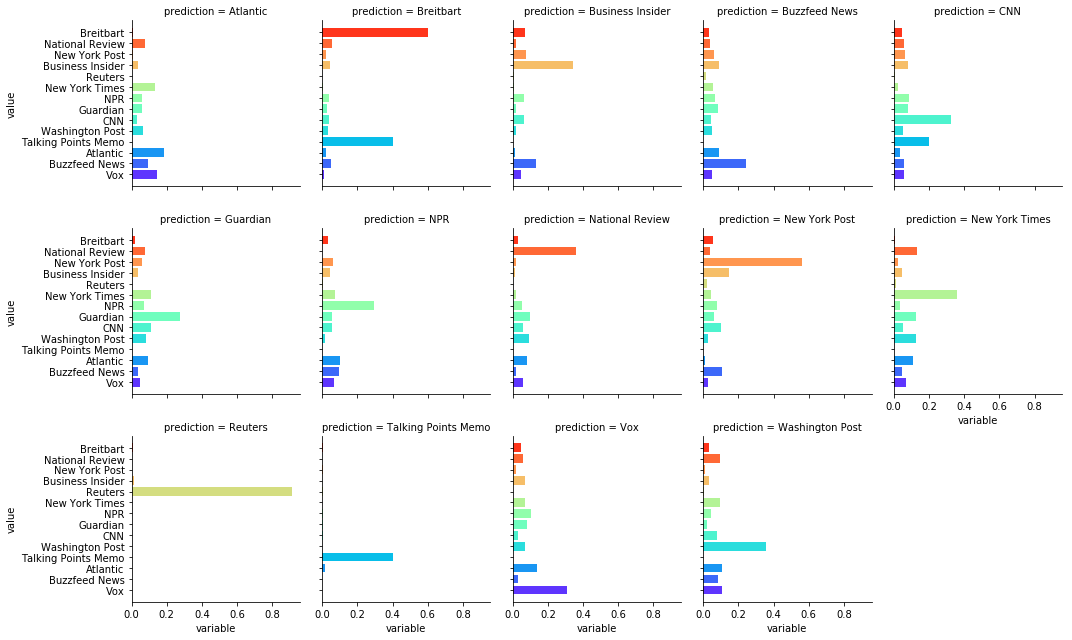

In [238]:
g = sns.FacetGrid(test_max_g1_lrpct_long, col='prediction', col_wrap=5, hue='variable', palette='rainbow')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

In [239]:
## Bag of words

lr.fit(x_train_bow, y_train)

cv_bow_lr = cross_val_score(lr, x_train_bow, y_train, cv=5)
cv_bow_lr

array([0.65950069, 0.67685893, 0.67896936, 0.66759582, 0.69811321])

In [445]:
cv_bow_lr.mean()

0.6762076017975246

In [240]:
ypred_bow_lr = lr.predict(x_test_bow)
table_bow_lr = pd.crosstab(ypred_bow_lr, y_test)
test_bow_lrpct = table_pct(table_bow_lr, pub_counts_test)
test_bow_lrpct.reset_index(inplace=True)
test_bow_lrpct.rename(columns={'index': 'prediction'}, inplace=True)
test_bow_lrpct_long = pd.melt(test_bow_lrpct, id_vars='prediction')

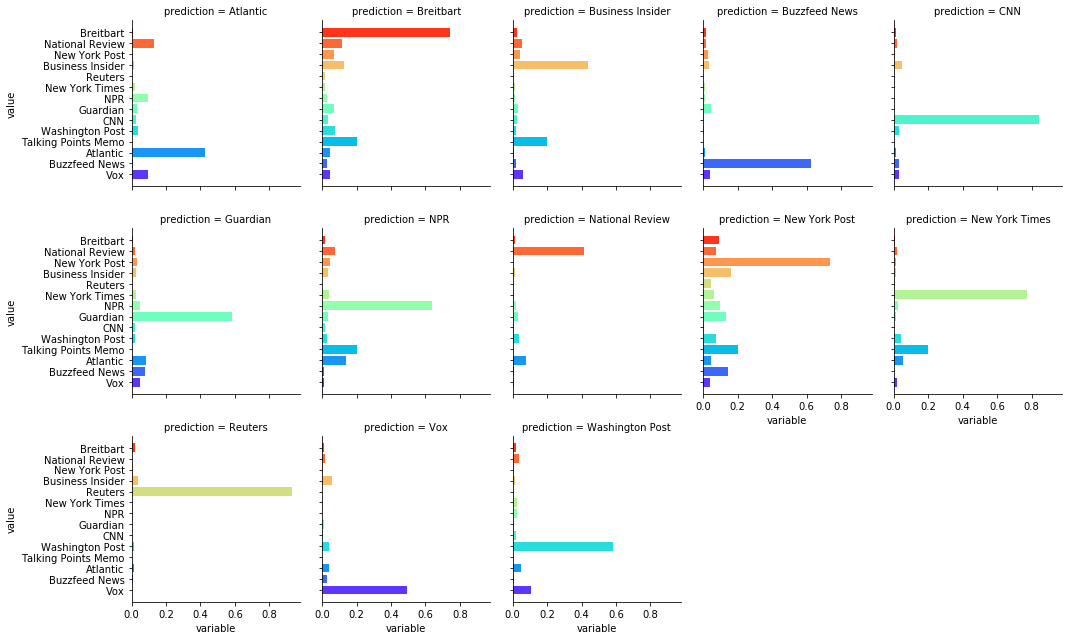

In [241]:
g = sns.FacetGrid(test_bow_lrpct_long, col='prediction', col_wrap=5, hue='variable', palette='rainbow')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

In [242]:
## tfidf

lr.fit(x_train_tfidf, y_train)

cv_tfidf_lr = cross_val_score(lr, x_train_tfidf, y_train, cv=5)
cv_tfidf_lr

array([0.64909847, 0.6400278 , 0.65041783, 0.6369338 , 0.65059399])

In [446]:
cv_tfidf_lr.mean()

0.6454143773693177

In [243]:
ypred_tfidf_lr = lr.predict(x_test_tfidf)
table_tfidf_lr = pd.crosstab(ypred_tfidf_lr, y_test)
test_tfidf_lrpct = table_pct(table_tfidf_lr, pub_counts_test)
test_tfidf_lrpct.reset_index(inplace=True)
test_tfidf_lrpct.rename(columns={'index': 'prediction'}, inplace=True)
test_tfidf_lrpct_long = pd.melt(test_tfidf_lrpct, id_vars='prediction')

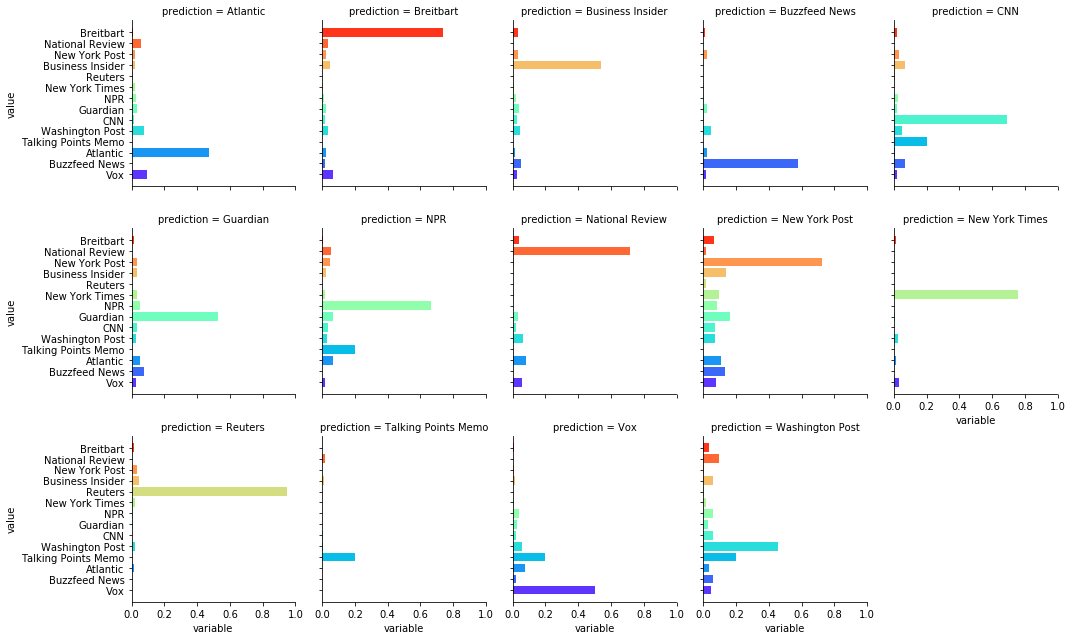

In [244]:
g = sns.FacetGrid(test_tfidf_lrpct_long, col='prediction', col_wrap=5, hue='variable', palette='rainbow')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

Logistic regression has given some incredible results. The cross validation scores show that both the bag of words method and the tfidf method result in a prediction accuracy of around 65%. As with the multinomial Naive Bayes, the bag of words method looks to be the best. However, all methods are significantly improved compared to mNB, with the other three methods predicting with an accuracy of around 40%.

#### Random Forest

In [245]:
rfc = RandomForestClassifier(random_state=76, 
                             n_estimators=100, 
                             criterion='gini', 
                             max_depth=None,
                             n_jobs=-1)

In [246]:
## doc2vec

rfc.fit(x_train_d2v, y_train)

cv_d2v_rfc = cross_val_score(rfc, x_train_d2v, y_train, cv=5)
cv_d2v_rfc

array([0.40291262, 0.39819319, 0.40738162, 0.41672474, 0.39832285])

In [448]:
cv_d2v_rfc.mean()

0.4047070033004374

In [247]:
ypred_d2v_rfc = rfc.predict(x_test_d2v)
table_d2v_rfc = pd.crosstab(ypred_d2v_rfc, y_test)
test_d2v_rfcpct = table_pct(table_d2v_rfc, pub_counts_test)
test_d2v_rfcpct.reset_index(inplace=True)
test_d2v_rfcpct.rename(columns={'index': 'prediction'}, inplace=True)
test_d2v_rfcpct_long = pd.melt(test_d2v_rfcpct, id_vars='prediction')

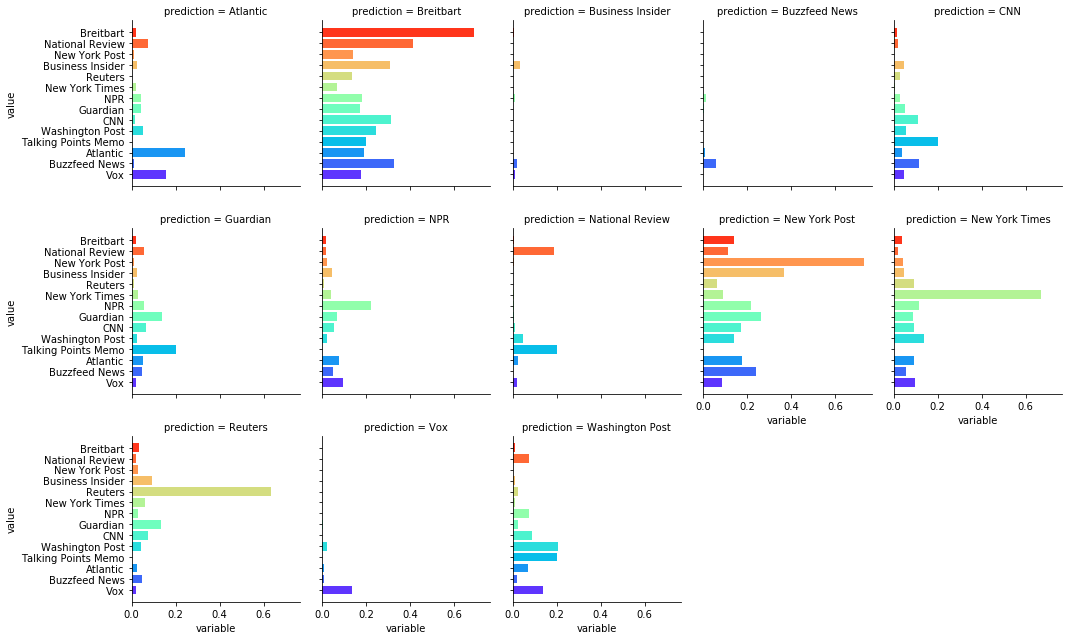

In [248]:
g = sns.FacetGrid(test_d2v_rfcpct_long, col='prediction', col_wrap=5, hue='variable', palette='rainbow')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

In [249]:
## word2vec average

rfc.fit(av_train_g1, y_train)

cv_av_g1_rfc = cross_val_score(rfc, av_train_g1, y_train, cv=5)
cv_av_g1_rfc

array([0.43966713, 0.43641418, 0.41504178, 0.42648084, 0.42278127])

In [449]:
cv_av_g1_rfc.mean()

0.4280770392607197

In [250]:
ypred_av_g1_rfc = rfc.predict(av_test_g1)
table_av_g1_rfc = pd.crosstab(ypred_av_g1_rfc, y_test)
test_av_g1_rfcpct = table_pct(table_av_g1_rfc, pub_counts_test)
test_av_g1_rfcpct.reset_index(inplace=True)
test_av_g1_rfcpct.rename(columns={'index': 'prediction'}, inplace=True)
test_av_g1_rfcpct_long = pd.melt(test_av_g1_rfcpct, id_vars='prediction')

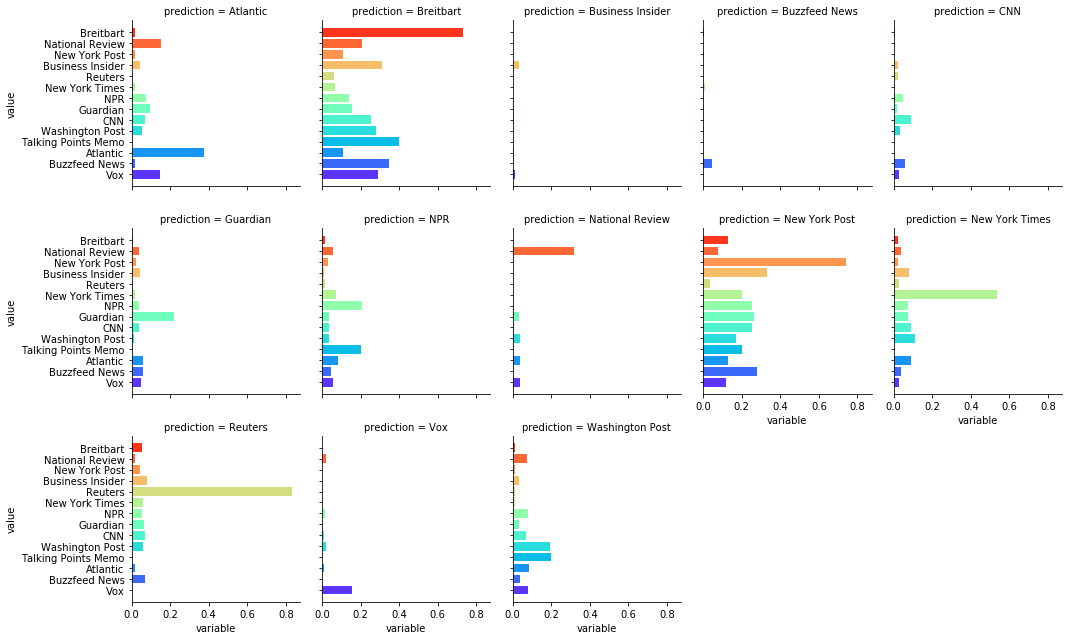

In [251]:
g = sns.FacetGrid(test_av_g1_rfcpct_long, col='prediction', col_wrap=5, hue='variable', palette='rainbow')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

In [252]:
## word2vec maximum

rfc.fit(max_train_g1, y_train)

cv_max_g1_rfc = cross_val_score(rfc, max_train_g1, y_train, cv=5)
cv_max_g1_rfc

array([0.45977809, 0.46212648, 0.45264624, 0.4543554 , 0.45632425])

In [450]:
cv_max_g1_rfc.mean()

0.4570460903479766

In [253]:
ypred_max_g1_rfc = rfc.predict(max_test_g1)
table_max_g1_rfc = pd.crosstab(ypred_max_g1_rfc, y_test)
test_max_g1_rfcpct = table_pct(table_max_g1_rfc, pub_counts_test)
test_max_g1_rfcpct.reset_index(inplace=True)
test_max_g1_rfcpct.rename(columns={'index': 'prediction'}, inplace=True)
test_max_g1_rfcpct_long = pd.melt(test_max_g1_rfcpct, id_vars='prediction')

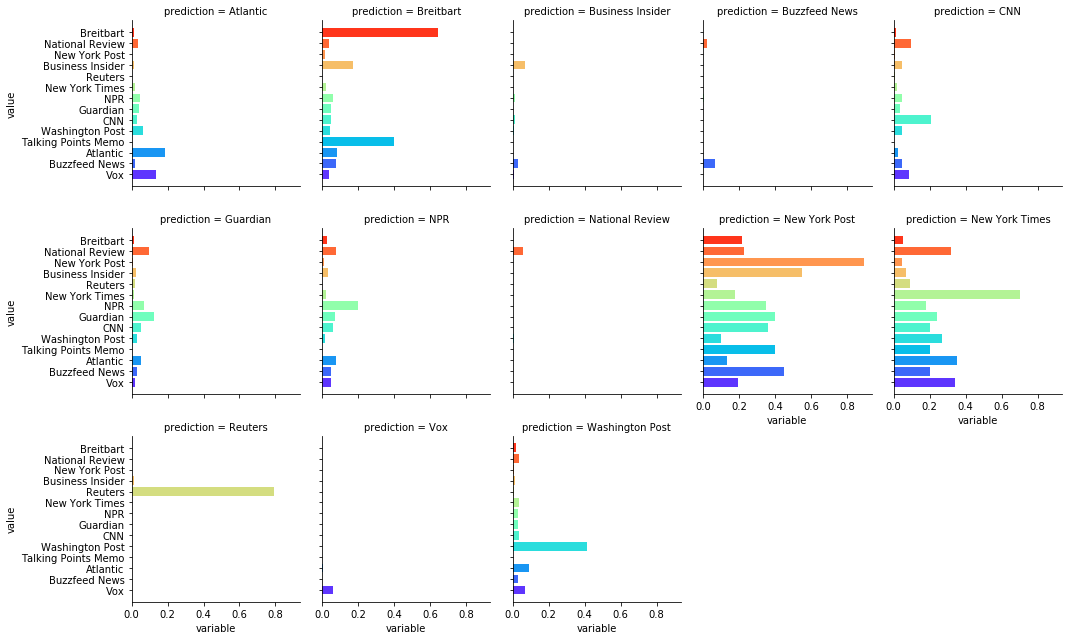

In [254]:
g = sns.FacetGrid(test_max_g1_rfcpct_long, col='prediction', col_wrap=5, hue='variable', palette='rainbow')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

In [255]:
## Bag of words

rfc.fit(x_train_bow, y_train)

cv_bow_rfc = cross_val_score(rfc, x_train_bow, y_train, cv=5)
cv_bow_rfc

array([0.64771151, 0.6143155 , 0.62395543, 0.59651568, 0.63032844])

In [451]:
cv_bow_rfc.mean()

0.6225653123017179

In [256]:
ypred_bow_rfc = rfc.predict(x_test_bow)
table_bow_rfc = pd.crosstab(ypred_bow_rfc, y_test)
test_bow_rfcpct = table_pct(table_bow_rfc, pub_counts_test)
test_bow_rfcpct.reset_index(inplace=True)
test_bow_rfcpct.rename(columns={'index': 'prediction'}, inplace=True)
test_bow_rfcpct_long = pd.melt(test_bow_rfcpct, id_vars='prediction')

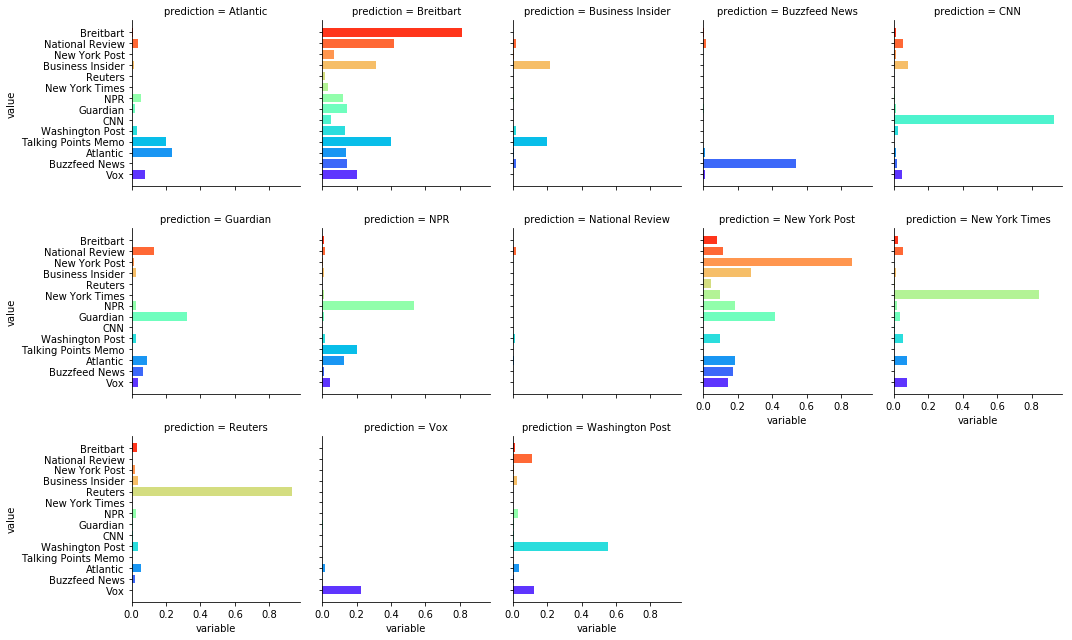

In [257]:
g = sns.FacetGrid(test_bow_rfcpct_long, col='prediction', col_wrap=5, hue='variable', palette='rainbow')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

In [258]:
## tfidf

rfc.fit(x_train_tfidf, y_train)

cv_tfidf_rfc = cross_val_score(rfc, x_train_tfidf, y_train, cv=5)
cv_tfidf_rfc

array([0.610957  , 0.6143155 , 0.61281337, 0.59512195, 0.60237596])

In [452]:
cv_tfidf_rfc.mean()

0.6071167567186585

In [259]:
ypred_tfidf_rfc = rfc.predict(x_test_tfidf)
table_tfidf_rfc = pd.crosstab(ypred_tfidf_rfc, y_test)
test_tfidf_rfcpct = table_pct(table_tfidf_rfc, pub_counts_test)
test_tfidf_rfcpct.reset_index(inplace=True)
test_tfidf_rfcpct.rename(columns={'index': 'prediction'}, inplace=True)
test_tfidf_rfcpct_long = pd.melt(test_tfidf_rfcpct, id_vars='prediction')

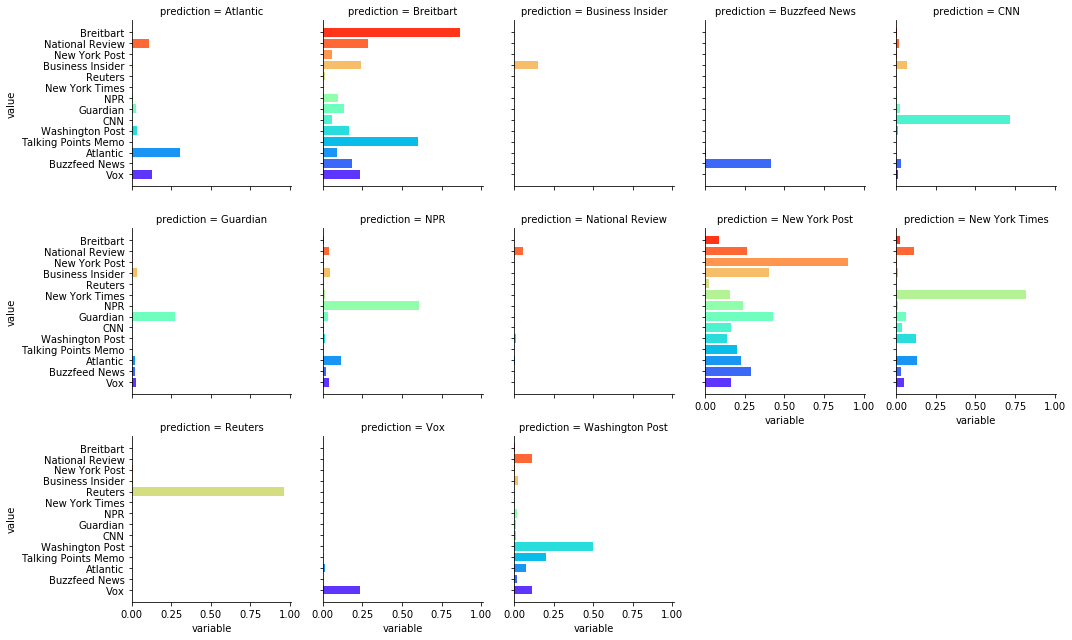

In [260]:
g = sns.FacetGrid(test_tfidf_rfcpct_long, col='prediction', col_wrap=5, hue='variable', palette='rainbow')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

Again here bag of words and tfidf methods performed most strongly, both recording accuracies of around 60%. The correct predictions seem to be more focused on a few publications - in the bag of words model Reuters, New York Post, New York Times and CNN articles are predicted correctly nearly 100% of the time. However, the correct predictions for other publications are lower. Logistic regression does not predict any publication with nearly 100% accuracy, but the correct predictions are spread more evenly across all publications.

#### Gradient boosting

In [267]:
gbc = GradientBoostingClassifier(random_state=76,
                                 n_estimators=50,
                                max_depth=3,
                                verbose=10)

In [268]:
## doc2vec

gbc.fit(x_train_d2v, y_train)

cv_d2v_gbc = cross_val_score(gbc, x_train_d2v, y_train, cv=5)
cv_d2v_gbc

      Iter       Train Loss   Remaining Time 
         1       17757.0667           25.03s
         2       17036.0272           24.01s
         3       16481.1082           23.52s
         4       16011.1914           22.81s
         5       15603.9733           22.24s
         6       15215.4947           21.69s
         7       14877.6720           21.14s
         8       14575.6422           20.73s
         9       14313.4113           20.34s
        10       14055.0107           19.90s
        11       13814.2131           19.37s
        12       13602.5345           18.87s
        13       13396.8192           18.39s
        14       13208.6104           17.87s
        15       13008.0502           17.37s
        16       12840.0122           16.85s
        17       12676.3964           16.35s
        18       12514.8547           15.85s
        19       12376.7689           15.33s
        20       12218.6751           14.84s
        21       12092.4862           14.33s
        2

        29        8599.2542            8.33s
        30        8518.0216            7.92s
        31        8434.8944            7.51s
        32        8347.7631            7.11s
        33        8277.3090            6.71s
        34        8197.9892            6.31s
        35        8123.7719            5.91s
        36        8051.7528            5.52s
        37        7983.1263            5.12s
        38        7916.8730            4.72s
        39        7854.2788            4.33s
        40        7791.9301            3.94s
        41        7732.7896            3.54s
        42        7664.0348            3.15s
        43        7604.4361            2.75s
        44        7538.2845            2.36s
        45        7482.5752            1.96s
        46        7432.5192            1.57s
        47        7384.9215            1.18s
        48        7333.1343            0.78s
        49        7284.7190            0.39s
        50        7231.3779            0.00s
      Iter

array([0.4001387 , 0.38498958, 0.40181058, 0.4097561 , 0.41229909])

In [453]:
cv_d2v_gbc.mean()

0.4017988092826557

In [269]:
ypred_d2v_gbc = gbc.predict(x_test_d2v)
table_d2v_gbc = pd.crosstab(ypred_d2v_gbc, y_test)
test_d2v_gbcpct = table_pct(table_d2v_gbc, pub_counts_test)
test_d2v_gbcpct.reset_index(inplace=True)
test_d2v_gbcpct.rename(columns={'index': 'prediction'}, inplace=True)
test_d2v_gbcpct_long = pd.melt(test_d2v_gbcpct, id_vars='prediction')

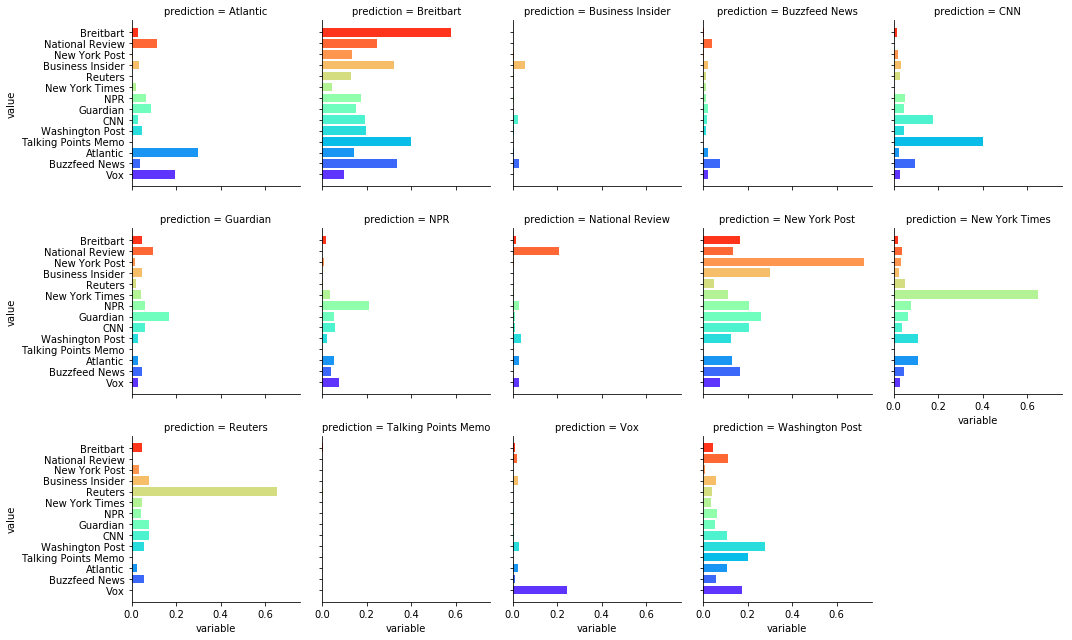

In [270]:
g = sns.FacetGrid(test_d2v_gbcpct_long, col='prediction', col_wrap=5, hue='variable', palette='rainbow')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

In [271]:
## word2vec average

gbc.fit(av_train_g1, y_train)

cv_av_g1_gbc = cross_val_score(gbc, av_train_g1, y_train, cv=5)
cv_av_g1_gbc

      Iter       Train Loss   Remaining Time 
         1       17601.2303            2.80m
         2       16839.4647            2.47m
         3       16199.6381            2.35m
         4       15675.4372            2.33m
         5       15219.1683            2.24m
         6       14813.8700            2.17m
         7       14461.5276            2.12m
         8       14116.4350            2.09m
         9       13821.3608            2.03m
        10       13542.2885            1.98m
        11       13276.4622            1.93m
        12       13019.7352            1.87m
        13       12795.0414            1.81m
        14       12581.9308            1.76m
        15       12364.2117            1.71m
        16       12169.1302            1.66m
        17       11988.6301            1.61m
        18       11810.0141            1.57m
        19       11632.0934            1.52m
        20       11456.5273            1.47m
        21       11284.6828            1.42m
        2

        29        7793.9035           47.89s
        30        7695.7835           45.63s
        31        7599.0595           43.25s
        32        7496.1919           40.90s
        33        7395.2193           38.60s
        34        7310.6066           36.26s
        35        7214.8136           33.96s
        36        7138.4708           31.65s
        37        7061.7358           29.35s
        38        6969.9492           27.08s
        39        6893.9158           24.79s
        40        6811.9160           22.51s
        41        6736.3799           20.24s
        42        6667.7913           17.97s
        43        6600.5066           15.70s
        44        6525.3441           13.45s
        45        6450.7382           11.19s
        46        6381.8214            8.95s
        47        6307.9975            6.70s
        48        6242.2317            4.47s
        49        6181.7192            2.23s
        50        6121.1059            0.00s
      Iter

array([0.44036061, 0.43988881, 0.44289694, 0.44111498, 0.44025157])

In [454]:
cv_av_g1_gbc.mean()

0.4409025825553772

In [272]:
ypred_av_g1_gbc = gbc.predict(av_test_g1)
table_av_g1_gbc = pd.crosstab(ypred_av_g1_gbc, y_test)
test_av_g1_gbcpct = table_pct(table_av_g1_gbc, pub_counts_test)
test_av_g1_gbcpct.reset_index(inplace=True)
test_av_g1_gbcpct.rename(columns={'index': 'prediction'}, inplace=True)
test_av_g1_gbcpct_long = pd.melt(test_av_g1_gbcpct, id_vars='prediction')

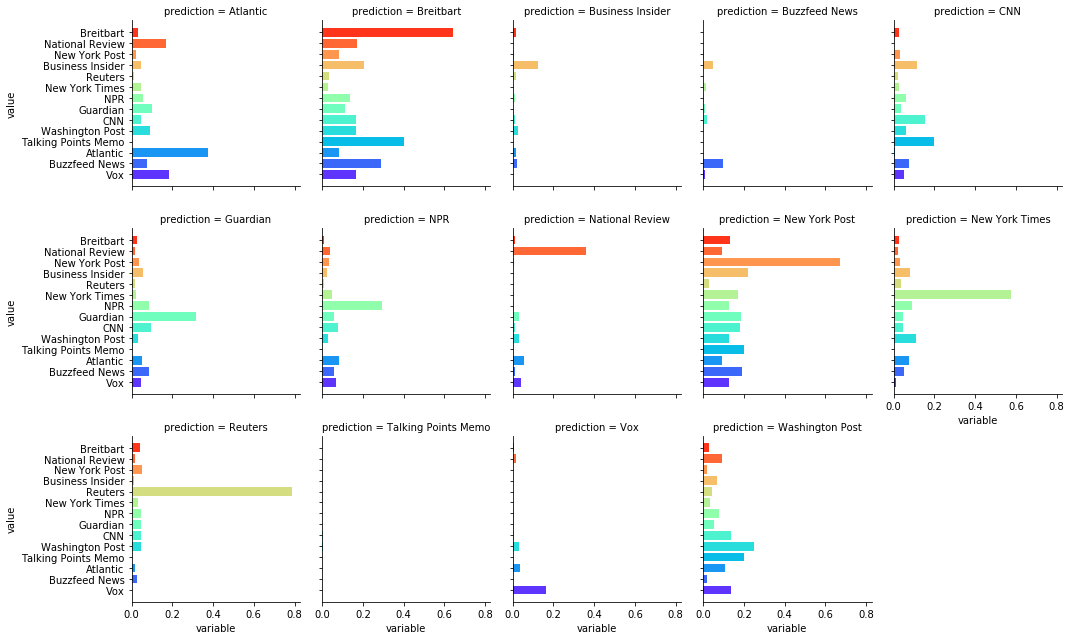

In [273]:
g = sns.FacetGrid(test_av_g1_gbcpct_long, col='prediction', col_wrap=5, hue='variable', palette='rainbow')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

In [274]:
## word2vec maximum

gbc.fit(max_train_g1, y_train)

cv_max_g1_gbc = cross_val_score(gbc, max_train_g1, y_train, cv=5)
cv_max_g1_gbc

      Iter       Train Loss   Remaining Time 
         1       16476.1679           47.81s
         2       15445.1812           46.91s
         3       14705.8224           46.26s
         4       14077.2963           45.28s
         5       13580.5650           44.41s
         6       13164.7830           43.66s
         7       12797.1241           42.77s
         8       12477.0631           41.87s
         9       12170.1167           41.00s
        10       11893.8254           40.25s
        11       11647.1075           39.37s
        12       11418.2889           38.47s
        13       11215.7910           37.56s
        14       11005.8218           37.82s
        15       10825.2421           37.24s
        16       10628.7065           36.60s
        17       10470.7806           35.55s
        18       10307.6880           34.64s
        19       10150.8432           33.92s
        20       10000.2726           32.80s
        21        9860.1124           31.66s
        2

        29        6873.4907           18.29s
        30        6770.0308           17.45s
        31        6693.0492           16.51s
        32        6606.6735           15.65s
        33        6531.7007           14.79s
        34        6456.7255           13.92s
        35        6385.2278           13.02s
        36        6314.6153           12.15s
        37        6241.1948           11.28s
        38        6163.9796           10.41s
        39        6091.7889            9.59s
        40        6026.2644            8.69s
        41        5964.8539            7.82s
        42        5891.4904            6.95s
        43        5836.3153            6.07s
        44        5767.3672            5.21s
        45        5711.7207            4.33s
        46        5650.1779            3.46s
        47        5601.8427            2.59s
        48        5548.8807            1.73s
        49        5498.4474            0.86s
        50        5446.1408            0.00s
      Iter

array([0.52912621, 0.52328006, 0.52367688, 0.51777003, 0.51991614])

In [455]:
cv_max_g1_gbc.mean()

0.5227538653620188

In [275]:
ypred_max_g1_gbc = gbc.predict(max_test_g1)
table_max_g1_gbc = pd.crosstab(ypred_max_g1_gbc, y_test)
test_max_g1_gbcpct = table_pct(table_max_g1_gbc, pub_counts_test)
test_max_g1_gbcpct.reset_index(inplace=True)
test_max_g1_gbcpct.rename(columns={'index': 'prediction'}, inplace=True)
test_max_g1_gbcpct_long = pd.melt(test_max_g1_gbcpct, id_vars='prediction')

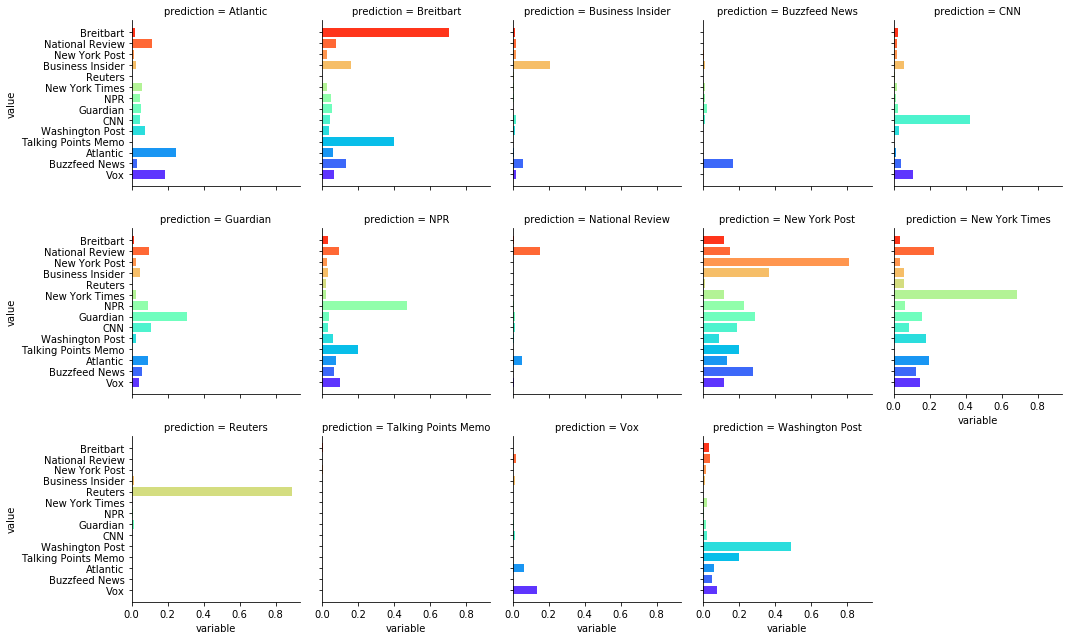

In [276]:
g = sns.FacetGrid(test_max_g1_gbcpct_long, col='prediction', col_wrap=5, hue='variable', palette='rainbow')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

In [277]:
## Bag of words

gbc.fit(x_train_bow, y_train)

cv_bow_gbc = cross_val_score(gbc, x_train_bow, y_train, cv=5)
cv_bow_gbc

      Iter       Train Loss   Remaining Time 
         1       15908.5209            3.20m
         2       14523.8754            3.23m
         3       13549.8914            3.26m
         4       12823.0513            3.33m
         5       12205.7035            3.42m
         6       11691.1386            3.30m
         7       11245.8813            3.23m
         8       10858.5922            3.11m
         9       10517.5272            3.02m
        10       10214.3846            2.92m
        11        9949.4716            2.82m
        12        9677.4178            2.72m
        13        9455.2301            2.64m
        14        9233.5473            2.56m
        15        9038.1552            2.48m
        16        8860.6757            2.40m
        17        8687.9413            2.32m
        18        8528.2077            2.24m
        19        8382.7846            2.16m
        20        8243.0620            2.08m
        21        8098.0834            2.00m
        2

        29        5604.0193            1.16m
        30        5519.5241            1.11m
        31        5446.1911            1.05m
        32        5369.2631           59.24s
        33        5291.8548           55.86s
        34        5226.2920           52.48s
        35        5160.3126           49.17s
        36        5088.7556           46.02s
        37        5020.5772           42.80s
        38        4953.0682           39.47s
        39        4897.9052           36.10s
        40        4836.8302           32.92s
        41        4781.1259           29.65s
        42        4720.2793           26.41s
        43        4663.9988           23.14s
        44        4610.3302           19.79s
        45        4555.9139           16.50s
        46        4505.4715           13.16s
        47        4455.0593            9.87s
        48        4401.3399            6.57s
        49        4351.0424            3.28s
        50        4305.6707            0.00s
      Iter

array([0.67475728, 0.65323141, 0.67479109, 0.65574913, 0.68273934])

In [456]:
cv_bow_gbc.mean()

0.6682536501285623

In [278]:
ypred_bow_gbc = gbc.predict(x_test_bow)
table_bow_gbc = pd.crosstab(ypred_bow_gbc, y_test)
test_bow_gbcpct = table_pct(table_bow_gbc, pub_counts_test)
test_bow_gbcpct.reset_index(inplace=True)
test_bow_gbcpct.rename(columns={'index': 'prediction'}, inplace=True)
test_bow_gbcpct_long = pd.melt(test_bow_gbcpct, id_vars='prediction')

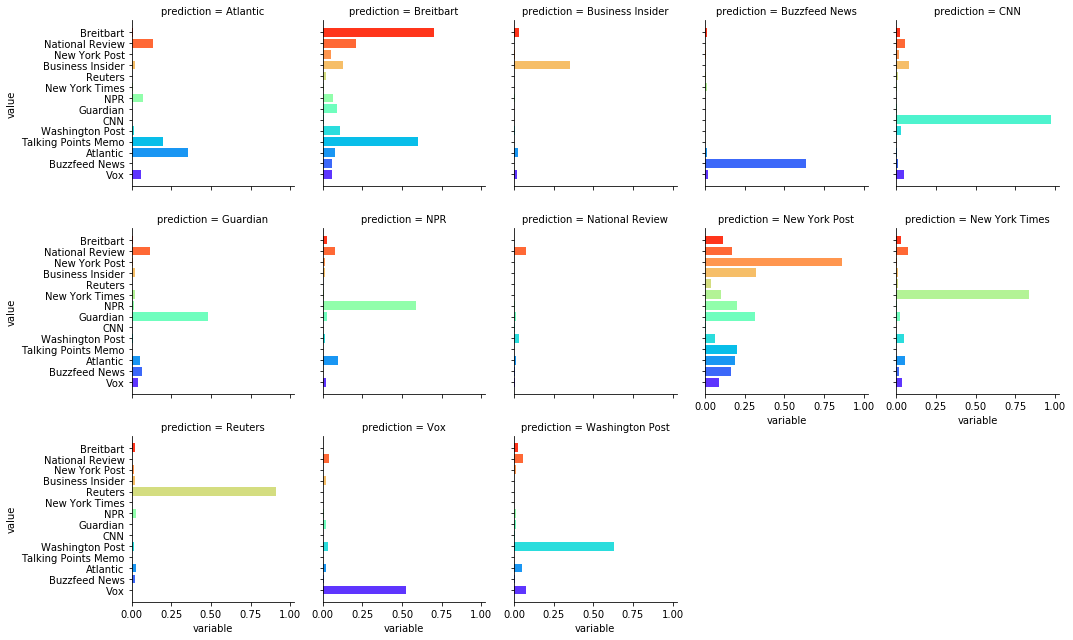

In [279]:
g = sns.FacetGrid(test_bow_gbcpct_long, col='prediction', col_wrap=5, hue='variable', palette='rainbow')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

In [280]:
## tfidf

gbc.fit(x_train_tfidf, y_train)

cv_tfidf_gbc = cross_val_score(gbc, x_train_tfidf, y_train, cv=5)
cv_tfidf_gbc

      Iter       Train Loss   Remaining Time 
         1       15006.7182            6.00m
         2       13487.7979            5.86m
         3       12438.0998            5.74m
         4       11614.8479            5.62m
         5       10962.4305            5.49m
         6       10426.6869            5.39m
         7        9962.7811            5.26m
         8        9550.6875            5.14m
         9        9173.8968            5.02m
        10        8841.6323            4.90m
        11        8558.5706            4.78m
        12        8303.9583            4.67m
        13        8038.5269            4.55m
        14        7825.5934            4.42m
        15        7625.4472            4.30m
        16        7457.8545            4.19m
        17        7286.3532            4.07m
        18        7105.3297            3.95m
        19        6954.7175            3.82m
        20        6804.9388            3.70m
        21        6675.4731            3.57m
        2

        29        4490.0688            2.06m
        30        4416.5180            1.96m
        31        4351.3693            1.86m
        32        4292.1835            1.76m
        33        4225.3681            1.66m
        34        4161.6606            1.57m
        35        4101.3353            1.47m
        36        4056.0769            1.37m
        37        4002.7215            1.27m
        38        3946.8240            1.17m
        39        3890.3787            1.07m
        40        3845.3729           58.62s
        41        3787.1846           52.74s
        42        3742.4298           46.86s
        43        3696.9820           40.99s
        44        3658.0664           35.10s
        45        3618.7883           29.26s
        46        3580.9683           23.55s
        47        3541.6698           17.68s
        48        3498.5103           11.79s
        49        3459.5854            5.91s
        50        3420.8105            0.00s
      Iter

array([0.69694868, 0.68102849, 0.69637883, 0.69268293, 0.69881202])

In [457]:
cv_tfidf_gbc.mean()

0.6931701901746969

In [281]:
ypred_tfidf_gbc = gbc.predict(x_test_tfidf)
table_tfidf_gbc = pd.crosstab(ypred_tfidf_gbc, y_test)
test_tfidf_gbcpct = table_pct(table_tfidf_gbc, pub_counts_test)
test_tfidf_gbcpct.reset_index(inplace=True)
test_tfidf_gbcpct.rename(columns={'index': 'prediction'}, inplace=True)
test_tfidf_gbcpct_long = pd.melt(test_tfidf_gbcpct, id_vars='prediction')

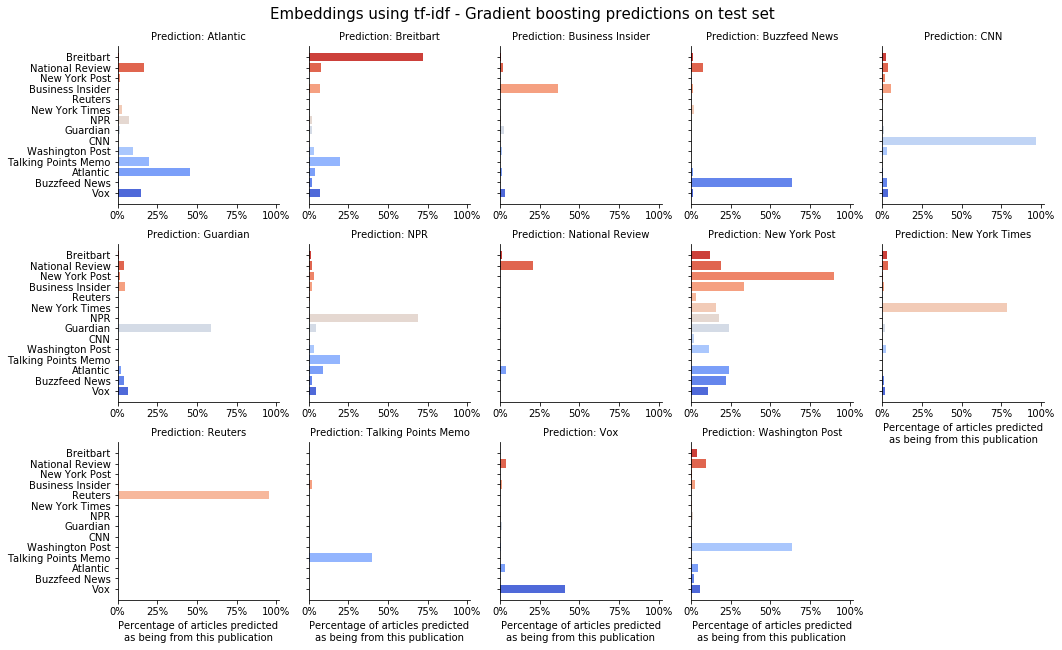

In [461]:
g = sns.FacetGrid(test_tfidf_gbcpct_long, col='prediction', col_wrap=5, hue='variable', palette='coolwarm')
g = g.map(plt.barh, 'variable', 'value')
g.set_ylabels('')
g.set_titles("Prediction: {col_name}")
axes = g.axes
for ax in axes:
    _ = plt.setp(ax.get_xticklabels(), visible=True)
    vals = ax.get_xticks()
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
g.set_xlabels('Percentage of articles predicted\nas being from this publication')
plt.subplots_adjust(top=0.92, hspace=0.25)
g.fig.suptitle('Embeddings using tf-idf - Gradient boosting predictions on test set', fontsize=15)
g.fig.savefig('tfidfpubtestsup.png', dpi=300, bbox_inches='tight')
plt.show()

Gradient boosting has resulted in the greatest accuracy, around 69%. The algorithm appears particularly strong at predicted Reuters, the New York Times and CNN, and moderately good at predicting Breitbart, BuzzFeed, the Guardian, NPR and the Washington Post. Most of the New York Post articles are also correctly classified but there are also a large number of non-New York Post articles categorized as such.

The algorithms appears to find it difficult to categorize National Review articles as the predictions for these articles are spread across many publications. Vox is similarly quite difficult to classify.

### Predicting Vox author

In [315]:
y_train_vox = train_authors['author']
y_test_vox = test_authors['author']

In [316]:
## doc2vec
## Shift by 10 so no negative numbers

x_train_d2v_vox_shift = x_train_d2v_vox + 10
x_test_d2v_vox_shift = x_test_d2v_vox + 10

## word2vec average
## Shift by 1 so no negative numbers 

av_train_g1_vox_shift = av_train_g1_vox + 1
av_test_g1_vox_shift = pd.DataFrame(av_test_g1_vox) + 1

## word2vec maximum
## Shift by 1 so no negative numbers

max_train_g1_vox_shift = max_train_g1_vox + 1
max_test_g1_vox_shift = pd.DataFrame(max_test_g1_vox) + 1

#### Multinominal NB

In [317]:
mNB_vox = MultinomialNB()

In [318]:
## doc2vec

mNB_vox.fit(x_train_d2v_vox_shift, y_train_vox)

## Cross validation to get accuracy on training set
cv_d2v_vox_mNB = cross_val_score(mNB_vox, x_train_d2v_vox_shift, y_train_vox, cv=5)
cv_d2v_vox_mNB

array([0.21428571, 0.56      , 0.5       , 0.5       , 0.63157895])

In [321]:
ypred_d2v_vox_mNB = mNB_vox.predict(x_test_d2v_vox_shift)
table_d2v_vox_mNB = pd.crosstab(ypred_d2v_vox_mNB, y_test_vox)
test_d2v_vox_mNBpct = table_auth_pct(table_d2v_vox_mNB, auth_counts_test)
test_d2v_vox_mNBpct.reset_index(inplace=True)
test_d2v_vox_mNBpct.rename(columns={'index': 'prediction'}, inplace=True)
test_d2v_vox_mNBpct_long = pd.melt(test_d2v_vox_mNBpct, id_vars='prediction')

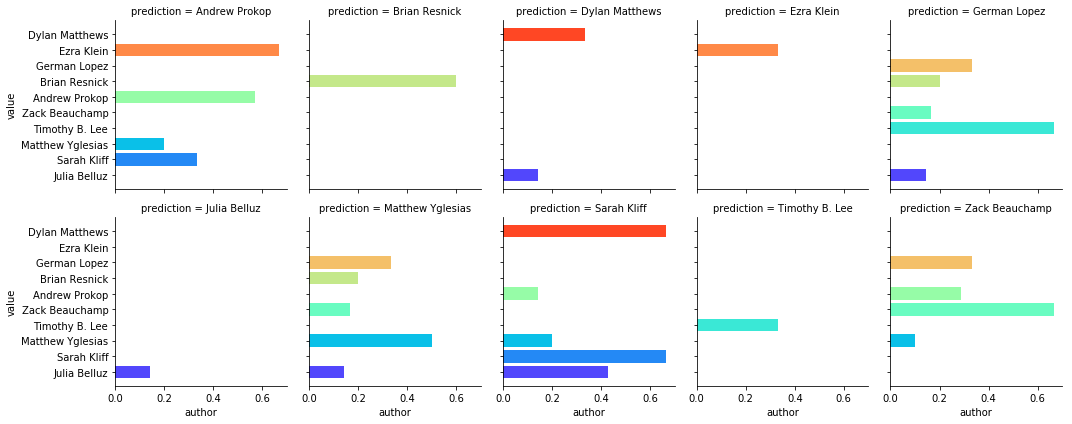

In [324]:
g = sns.FacetGrid(test_d2v_vox_mNBpct_long, col='prediction', col_wrap=5, hue='author', palette='rainbow')
g = g.map(plt.barh, 'author', 'value')
plt.show()

In [325]:
## word2vec average

mNB_vox.fit(av_train_g1_vox_shift, y_train_vox)

## Cross validation to get accuracy on training set
cv_av_g1_vox_mNB = cross_val_score(mNB_vox, av_train_g1_vox_shift, y_train_vox, cv=5)
cv_av_g1_vox_mNB

array([0.10714286, 0.28      , 0.27272727, 0.2       , 0.26315789])

In [327]:
ypred_av_g1_vox_mNB = mNB_vox.predict(av_test_g1_vox_shift)
table_av_g1_vox_mNB = pd.crosstab(ypred_av_g1_vox_mNB, y_test_vox)
test_av_g1_vox_mNBpct = table_auth_pct(table_av_g1_vox_mNB, auth_counts_test)
test_av_g1_vox_mNBpct.reset_index(inplace=True)
test_av_g1_vox_mNBpct.rename(columns={'index': 'prediction'}, inplace=True)
test_av_g1_vox_mNBpct_long = pd.melt(test_av_g1_vox_mNBpct, id_vars='prediction')

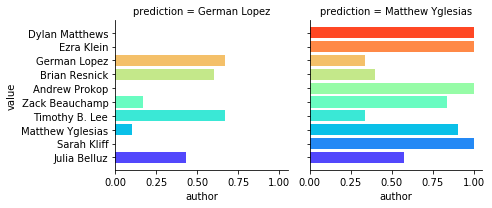

In [328]:
g = sns.FacetGrid(test_av_g1_vox_mNBpct_long, col='prediction', col_wrap=5, hue='author', palette='rainbow')
g = g.map(plt.barh, 'author', 'value')
plt.show()

In [329]:
## word2vec maximum

mNB_vox.fit(max_train_g1_vox_shift, y_train_vox)

## Cross validation to get accuracy on training set
cv_max_g1_vox_mNB = cross_val_score(mNB_vox, max_train_g1_vox_shift, y_train_vox, cv=5)
cv_max_g1_vox_mNB

array([0.14285714, 0.28      , 0.27272727, 0.2       , 0.26315789])

In [330]:
ypred_max_g1_vox_mNB = mNB_vox.predict(max_test_g1_vox_shift)
table_max_g1_vox_mNB = pd.crosstab(ypred_max_g1_vox_mNB, y_test_vox)
test_max_g1_vox_mNBpct = table_auth_pct(table_max_g1_vox_mNB, auth_counts_test)
test_max_g1_vox_mNBpct.reset_index(inplace=True)
test_max_g1_vox_mNBpct.rename(columns={'index': 'prediction'}, inplace=True)
test_max_g1_vox_mNBpct_long = pd.melt(test_max_g1_vox_mNBpct, id_vars='prediction')

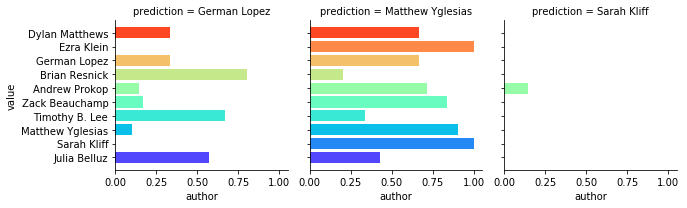

In [331]:
g = sns.FacetGrid(test_max_g1_vox_mNBpct_long, col='prediction', col_wrap=5, hue='author', palette='rainbow')
g = g.map(plt.barh, 'author', 'value')
plt.show()

In [332]:
## bow

mNB_vox.fit(x_train_bow_vox, y_train_vox)

## Cross validation to get accuracy on training set
cv_bow_vox_mNB = cross_val_score(mNB_vox, x_train_bow_vox, y_train_vox, cv=5)
cv_bow_vox_mNB

array([0.42857143, 0.56      , 0.63636364, 0.5       , 0.52631579])

In [333]:
ypred_bow_vox_mNB = mNB_vox.predict(x_test_bow_vox)
table_bow_vox_mNB = pd.crosstab(ypred_bow_vox_mNB, y_test_vox)
test_bow_vox_mNBpct = table_auth_pct(table_bow_vox_mNB, auth_counts_test)
test_bow_vox_mNBpct.reset_index(inplace=True)
test_bow_vox_mNBpct.rename(columns={'index': 'prediction'}, inplace=True)
test_bow_vox_mNBpct_long = pd.melt(test_bow_vox_mNBpct, id_vars='prediction')

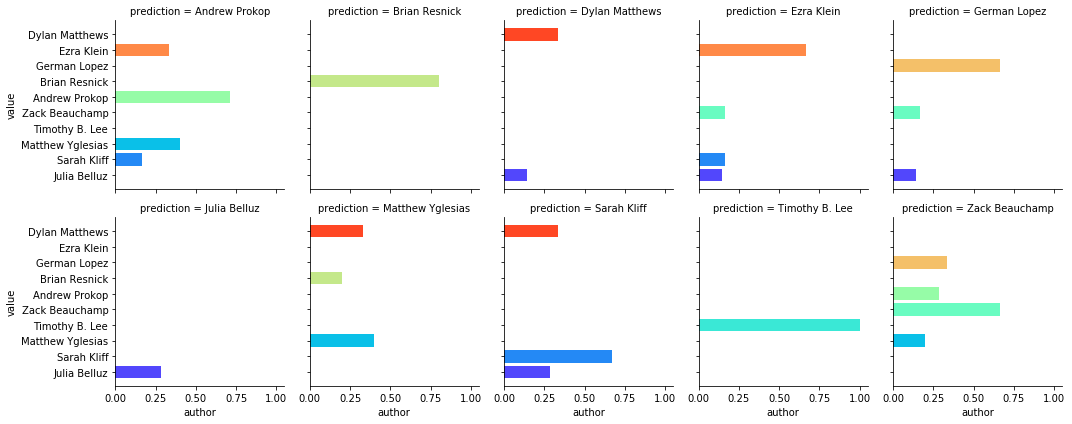

In [334]:
g = sns.FacetGrid(test_bow_vox_mNBpct_long, col='prediction', col_wrap=5, hue='author', palette='rainbow')
g = g.map(plt.barh, 'author', 'value')
plt.show()

In [336]:
## tfidf

mNB_vox.fit(vox_train_tfidf, y_train_vox)

## Cross validation to get accuracy on training set
cv_tfidf_vox_mNB = cross_val_score(mNB_vox, vox_train_tfidf, y_train_vox, cv=5)
cv_tfidf_vox_mNB

array([0.35714286, 0.48      , 0.40909091, 0.45      , 0.42105263])

In [338]:
ypred_tfidf_vox_mNB = mNB_vox.predict(vox_test_tfidf)
table_tfidf_vox_mNB = pd.crosstab(ypred_tfidf_vox_mNB, y_test_vox)
test_tfidf_vox_mNBpct = table_auth_pct(table_tfidf_vox_mNB, auth_counts_test)
test_tfidf_vox_mNBpct.reset_index(inplace=True)
test_tfidf_vox_mNBpct.rename(columns={'index': 'prediction'}, inplace=True)
test_tfidf_vox_mNBpct_long = pd.melt(test_tfidf_vox_mNBpct, id_vars='prediction')

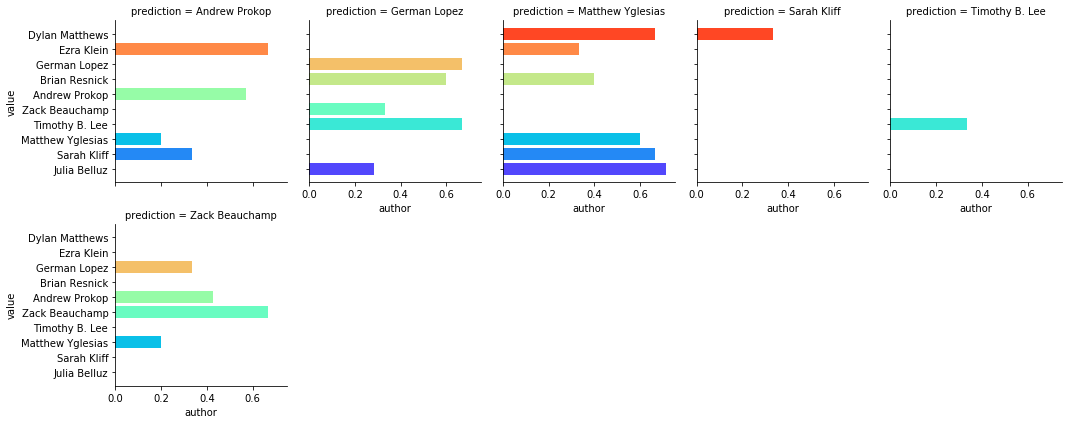

In [339]:
g = sns.FacetGrid(test_tfidf_vox_mNBpct_long, col='prediction', col_wrap=5, hue='author', palette='rainbow')
g = g.map(plt.barh, 'author', 'value')
plt.show()

Bag of words is definitely best here.

#### Logistic Regression

In [343]:
lr_vox = LogisticRegression(random_state=76, 
                        class_weight='balanced', 
                        solver='lbfgs', 
                        multi_class='multinomial', 
                        max_iter=1000)

In [344]:
## doc2vec

lr_vox.fit(x_train_d2v_vox_shift, y_train_vox)

## Cross validation to get accuracy on training set
cv_d2v_vox_lr = cross_val_score(lr_vox, x_train_d2v_vox_shift, y_train_vox, cv=5)
cv_d2v_vox_lr

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


array([0.42857143, 0.6       , 0.59090909, 0.65      , 0.57894737])

In [345]:
ypred_d2v_vox_lr = lr_vox.predict(x_test_d2v_vox_shift)
table_d2v_vox_lr = pd.crosstab(ypred_d2v_vox_lr, y_test_vox)
test_d2v_vox_lrpct = table_auth_pct(table_d2v_vox_lr, auth_counts_test)
test_d2v_vox_lrpct.reset_index(inplace=True)
test_d2v_vox_lrpct.rename(columns={'index': 'prediction'}, inplace=True)
test_d2v_vox_lrpct_long = pd.melt(test_d2v_vox_lrpct, id_vars='prediction')

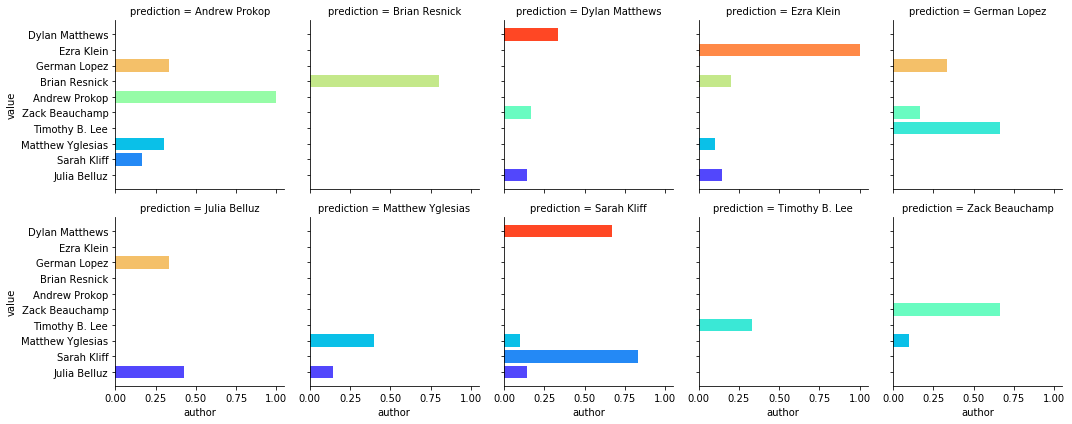

In [346]:
g = sns.FacetGrid(test_d2v_vox_lrpct_long, col='prediction', col_wrap=5, hue='author', palette='rainbow')
g = g.map(plt.barh, 'author', 'value')
plt.show()

In [347]:
## word2vec average

lr_vox.fit(av_train_g1_vox_shift, y_train_vox)

## Cross validation to get accuracy on training set
cv_av_g1_vox_lr = cross_val_score(lr_vox, av_train_g1_vox_shift, y_train_vox, cv=5)
cv_av_g1_vox_lr

array([0.46428571, 0.48      , 0.5       , 0.45      , 0.47368421])

In [348]:
ypred_av_g1_vox_lr = lr_vox.predict(av_test_g1_vox_shift)
table_av_g1_vox_lr = pd.crosstab(ypred_av_g1_vox_lr, y_test_vox)
test_av_g1_vox_lrpct = table_auth_pct(table_av_g1_vox_lr, auth_counts_test)
test_av_g1_vox_lrpct.reset_index(inplace=True)
test_av_g1_vox_lrpct.rename(columns={'index': 'prediction'}, inplace=True)
test_av_g1_vox_lrpct_long = pd.melt(test_av_g1_vox_lrpct, id_vars='prediction')

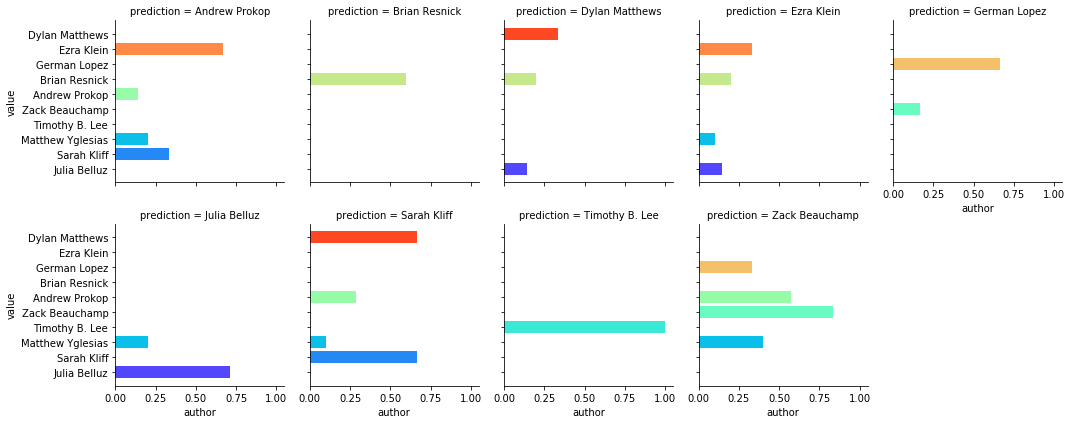

In [349]:
g = sns.FacetGrid(test_av_g1_vox_lrpct_long, col='prediction', col_wrap=5, hue='author', palette='rainbow')
g = g.map(plt.barh, 'author', 'value')
plt.show()

In [350]:
## word2vec maximum

lr_vox.fit(max_train_g1_vox_shift, y_train_vox)

## Cross validation to get accuracy on training set
cv_max_g1_vox_lr = cross_val_score(lr_vox, max_train_g1_vox_shift, y_train_vox, cv=5)
cv_max_g1_vox_lr

array([0.35714286, 0.44      , 0.31818182, 0.5       , 0.42105263])

In [351]:
ypred_max_g1_vox_lr = lr_vox.predict(max_test_g1_vox_shift)
table_max_g1_vox_lr = pd.crosstab(ypred_max_g1_vox_lr, y_test_vox)
test_max_g1_vox_lrpct = table_auth_pct(table_max_g1_vox_lr, auth_counts_test)
test_max_g1_vox_lrpct.reset_index(inplace=True)
test_max_g1_vox_lrpct.rename(columns={'index': 'prediction'}, inplace=True)
test_max_g1_vox_lrpct_long = pd.melt(test_max_g1_vox_lrpct, id_vars='prediction')

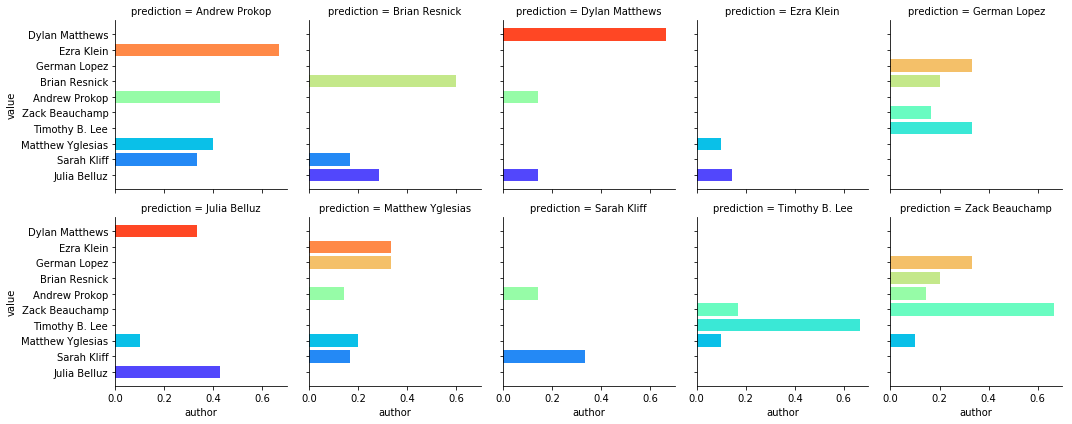

In [352]:
g = sns.FacetGrid(test_max_g1_vox_lrpct_long, col='prediction', col_wrap=5, hue='author', palette='rainbow')
g = g.map(plt.barh, 'author', 'value')
plt.show()

In [353]:
## bow

lr_vox.fit(x_train_bow_vox, y_train_vox)

## Cross validation to get accuracy on training set
cv_bow_vox_lr = cross_val_score(lr_vox, x_train_bow_vox, y_train_vox, cv=5)
cv_bow_vox_lr

array([0.46428571, 0.68      , 0.68181818, 0.4       , 0.57894737])

In [354]:
ypred_bow_vox_lr = lr_vox.predict(x_test_bow_vox)
table_bow_vox_lr = pd.crosstab(ypred_bow_vox_lr, y_test_vox)
test_bow_vox_lrpct = table_auth_pct(table_bow_vox_lr, auth_counts_test)
test_bow_vox_lrpct.reset_index(inplace=True)
test_bow_vox_lrpct.rename(columns={'index': 'prediction'}, inplace=True)
test_bow_vox_lrpct_long = pd.melt(test_bow_vox_lrpct, id_vars='prediction')

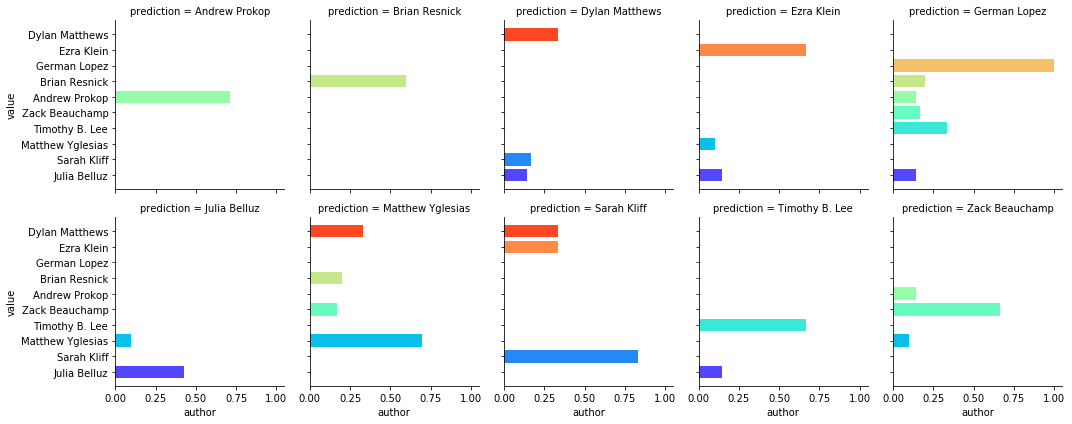

In [355]:
g = sns.FacetGrid(test_bow_vox_lrpct_long, col='prediction', col_wrap=5, hue='author', palette='rainbow')
g = g.map(plt.barh, 'author', 'value')
plt.show()

In [356]:
## tfidf

lr_vox.fit(vox_train_tfidf, y_train_vox)

## Cross validation to get accuracy on training set
cv_tfidf_vox_lr = cross_val_score(lr_vox, vox_train_tfidf, y_train_vox, cv=5)
cv_tfidf_vox_lr

array([0.5       , 0.56      , 0.40909091, 0.45      , 0.47368421])

In [358]:
ypred_tfidf_vox_lr = lr_vox.predict(vox_test_tfidf)
table_tfidf_vox_lr = pd.crosstab(ypred_tfidf_vox_lr, y_test_vox)
test_tfidf_vox_lrpct = table_auth_pct(table_tfidf_vox_lr, auth_counts_test)
test_tfidf_vox_lrpct.reset_index(inplace=True)
test_tfidf_vox_lrpct.rename(columns={'index': 'prediction'}, inplace=True)
test_tfidf_vox_lrpct_long = pd.melt(test_tfidf_vox_lrpct, id_vars='prediction')

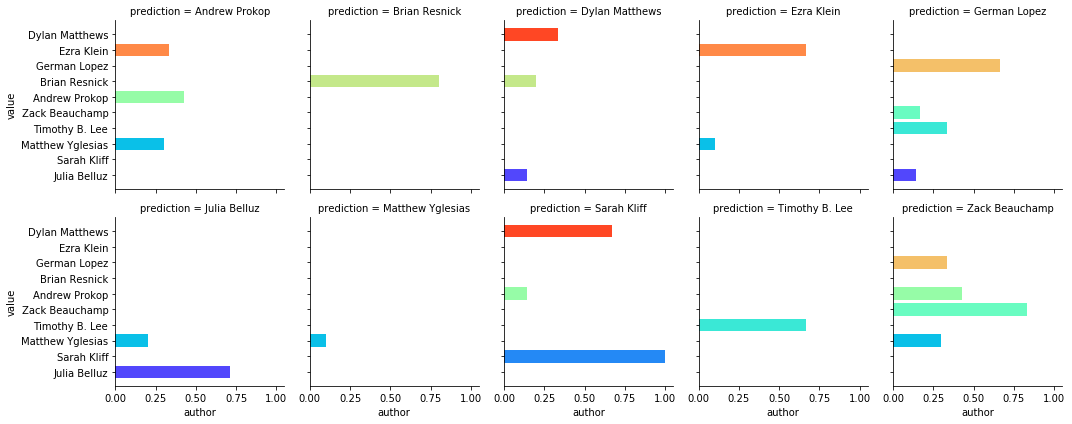

In [359]:
g = sns.FacetGrid(test_tfidf_vox_lrpct_long, col='prediction', col_wrap=5, hue='author', palette='rainbow')
g = g.map(plt.barh, 'author', 'value')
plt.show()

Bag of words probably best here but doc2vec not too far behind. Some authors consistently found - Brian Resnick, Timothy B Lee.

#### Random Forest

In [360]:
rfc_vox = RandomForestClassifier(random_state=76, 
                             n_estimators=100, 
                             criterion='gini', 
                             max_depth=None,
                             n_jobs=-1)

In [361]:
## doc2vec

rfc_vox.fit(x_train_d2v_vox_shift, y_train_vox)

## Cross validation to get accuracy on training set
cv_d2v_vox_rfc = cross_val_score(rfc_vox, x_train_d2v_vox_shift, y_train_vox, cv=5)
cv_d2v_vox_rfc

array([0.32142857, 0.48      , 0.45454545, 0.6       , 0.57894737])

In [362]:
ypred_d2v_vox_rfc = rfc_vox.predict(x_test_d2v_vox_shift)
table_d2v_vox_rfc = pd.crosstab(ypred_d2v_vox_rfc, y_test_vox)
test_d2v_vox_rfcpct = table_auth_pct(table_d2v_vox_rfc, auth_counts_test)
test_d2v_vox_rfcpct.reset_index(inplace=True)
test_d2v_vox_rfcpct.rename(columns={'index': 'prediction'}, inplace=True)
test_d2v_vox_rfcpct_long = pd.melt(test_d2v_vox_rfcpct, id_vars='prediction')

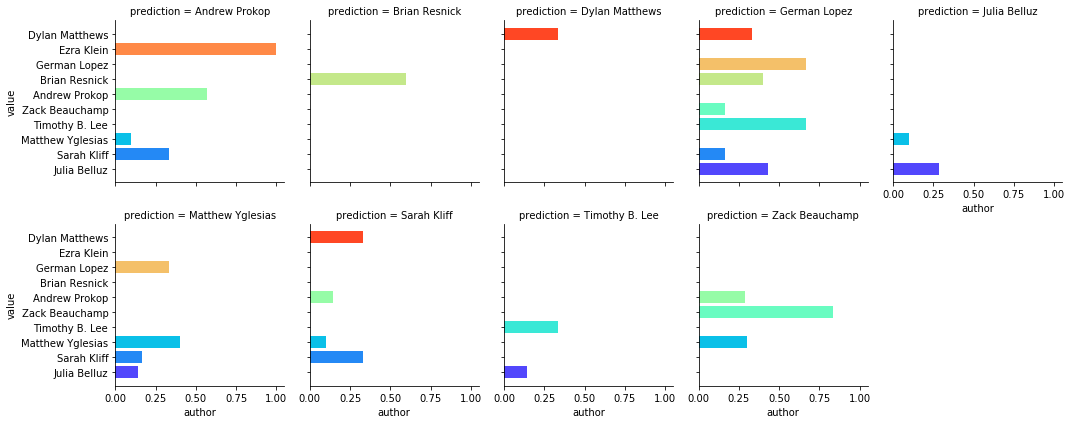

In [363]:
g = sns.FacetGrid(test_d2v_vox_rfcpct_long, col='prediction', col_wrap=5, hue='author', palette='rainbow')
g = g.map(plt.barh, 'author', 'value')
plt.show()

In [364]:
## word2vec average

rfc_vox.fit(av_train_g1_vox_shift, y_train_vox)

## Cross validation to get accuracy on training set
cv_av_g1_vox_rfc = cross_val_score(rfc_vox, av_train_g1_vox_shift, y_train_vox, cv=5)
cv_av_g1_vox_rfc

array([0.35714286, 0.56      , 0.54545455, 0.4       , 0.63157895])

In [365]:
ypred_av_g1_vox_rfc = rfc_vox.predict(av_test_g1_vox_shift)
table_av_g1_vox_rfc = pd.crosstab(ypred_av_g1_vox_rfc, y_test_vox)
test_av_g1_vox_rfcpct = table_auth_pct(table_av_g1_vox_rfc, auth_counts_test)
test_av_g1_vox_rfcpct.reset_index(inplace=True)
test_av_g1_vox_rfcpct.rename(columns={'index': 'prediction'}, inplace=True)
test_av_g1_vox_rfcpct_long = pd.melt(test_av_g1_vox_rfcpct, id_vars='prediction')

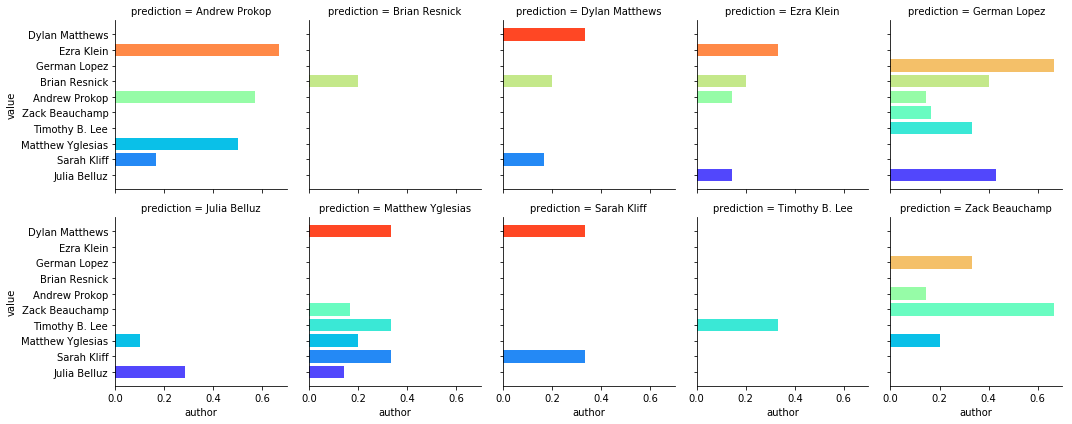

In [366]:
g = sns.FacetGrid(test_av_g1_vox_rfcpct_long, col='prediction', col_wrap=5, hue='author', palette='rainbow')
g = g.map(plt.barh, 'author', 'value')
plt.show()

In [367]:
## word2vec maximum

rfc_vox.fit(max_train_g1_vox_shift, y_train_vox)

## Cross validation to get accuracy on training set
cv_max_g1_vox_rfc = cross_val_score(rfc_vox, max_train_g1_vox_shift, y_train_vox, cv=5)
cv_max_g1_vox_rfc

array([0.28571429, 0.44      , 0.45454545, 0.35      , 0.36842105])

In [368]:
ypred_max_g1_vox_rfc = rfc_vox.predict(max_test_g1_vox_shift)
table_max_g1_vox_rfc = pd.crosstab(ypred_max_g1_vox_rfc, y_test_vox)
test_max_g1_vox_rfcpct = table_auth_pct(table_max_g1_vox_rfc, auth_counts_test)
test_max_g1_vox_rfcpct.reset_index(inplace=True)
test_max_g1_vox_rfcpct.rename(columns={'index': 'prediction'}, inplace=True)
test_max_g1_vox_rfcpct_long = pd.melt(test_max_g1_vox_rfcpct, id_vars='prediction')

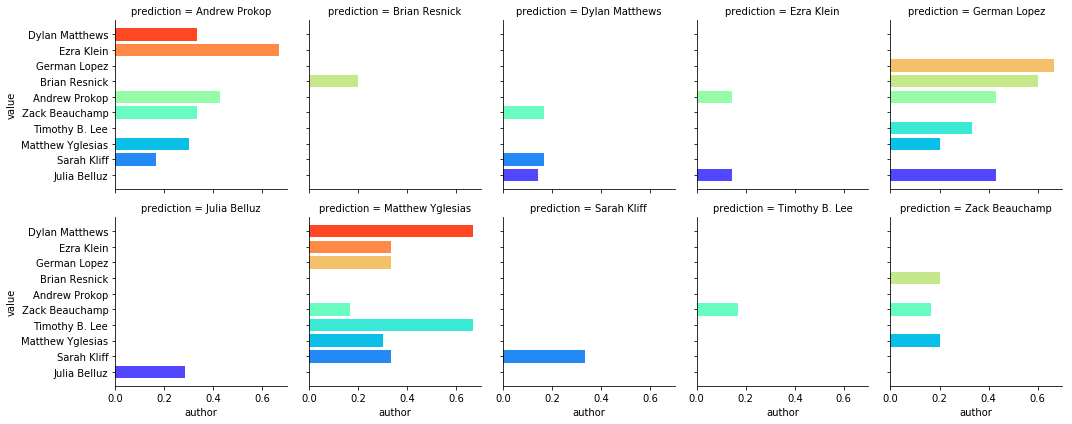

In [369]:
g = sns.FacetGrid(test_max_g1_vox_rfcpct_long, col='prediction', col_wrap=5, hue='author', palette='rainbow')
g = g.map(plt.barh, 'author', 'value')
plt.show()

In [370]:
## bow

rfc_vox.fit(x_train_bow_vox, y_train_vox)

## Cross validation to get accuracy on training set
cv_bow_vox_rfc = cross_val_score(rfc_vox, x_train_bow_vox, y_train_vox, cv=5)
cv_bow_vox_rfc

array([0.39285714, 0.44      , 0.5       , 0.3       , 0.42105263])

In [371]:
ypred_bow_vox_rfc = rfc_vox.predict(x_test_bow_vox)
table_bow_vox_rfc = pd.crosstab(ypred_bow_vox_rfc, y_test_vox)
test_bow_vox_rfcpct = table_auth_pct(table_bow_vox_rfc, auth_counts_test)
test_bow_vox_rfcpct.reset_index(inplace=True)
test_bow_vox_rfcpct.rename(columns={'index': 'prediction'}, inplace=True)
test_bow_vox_rfcpct_long = pd.melt(test_bow_vox_rfcpct, id_vars='prediction')

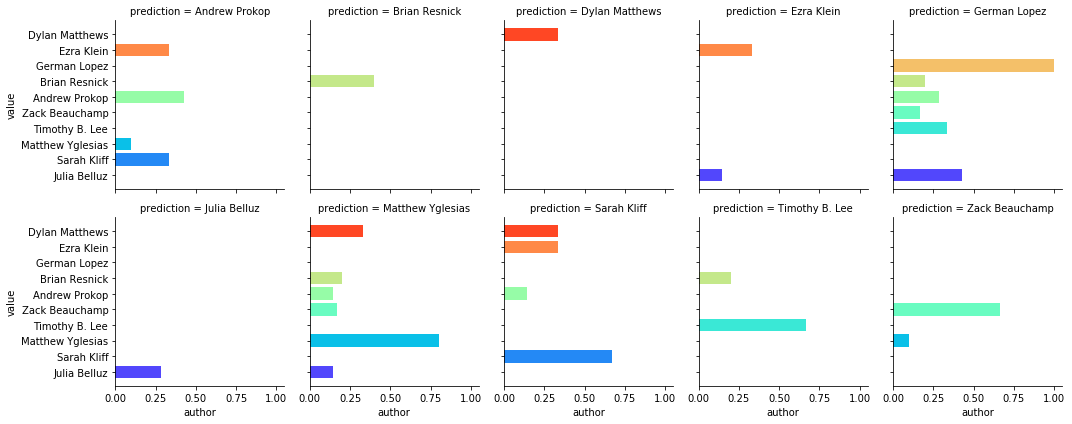

In [372]:
g = sns.FacetGrid(test_bow_vox_rfcpct_long, col='prediction', col_wrap=5, hue='author', palette='rainbow')
g = g.map(plt.barh, 'author', 'value')
plt.show()

In [374]:
## tfidf

rfc_vox.fit(vox_train_tfidf, y_train_vox)

## Cross validation to get accuracy on training set
cv_tfidf_vox_rfc = cross_val_score(rfc_vox, vox_train_tfidf, y_train_vox, cv=5)
cv_tfidf_vox_rfc

array([0.35714286, 0.48      , 0.45454545, 0.3       , 0.52631579])

In [375]:
ypred_tfidf_vox_rfc = rfc_vox.predict(vox_test_tfidf)
table_tfidf_vox_rfc = pd.crosstab(ypred_tfidf_vox_rfc, y_test_vox)
test_tfidf_vox_rfcpct = table_auth_pct(table_tfidf_vox_rfc, auth_counts_test)
test_tfidf_vox_rfcpct.reset_index(inplace=True)
test_tfidf_vox_rfcpct.rename(columns={'index': 'prediction'}, inplace=True)
test_tfidf_vox_rfcpct_long = pd.melt(test_tfidf_vox_rfcpct, id_vars='prediction')

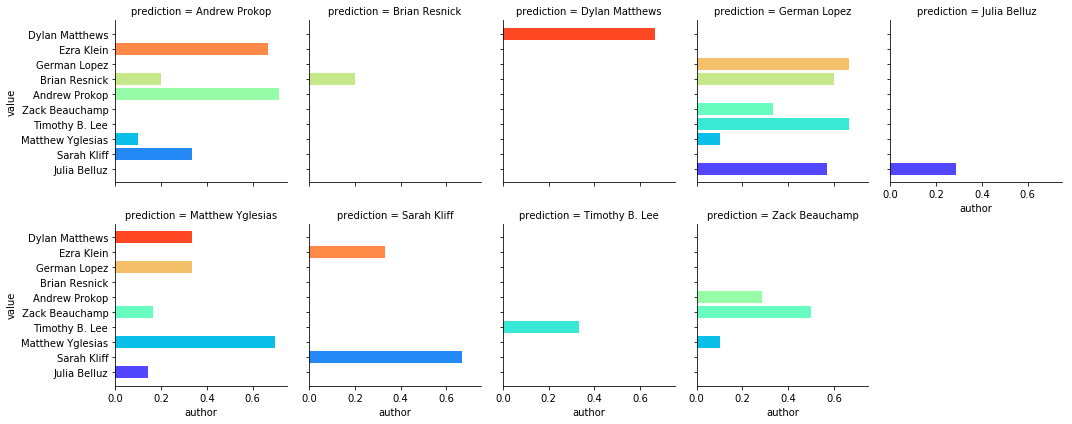

In [376]:
g = sns.FacetGrid(test_tfidf_vox_rfcpct_long, col='prediction', col_wrap=5, hue='author', palette='rainbow')
g = g.map(plt.barh, 'author', 'value')
plt.show()

None of these are great.

#### Gradient Boosting

In [379]:
gbc_vox = GradientBoostingClassifier(random_state=76,
                                 n_estimators=50,
                                max_depth=3,
                                verbose=10)

In [383]:
## doc2vec

gbc_vox.fit(x_train_d2v_vox, y_train_vox)

cv_d2v_gbc_vox = cross_val_score(gbc_vox, x_train_d2v_vox, y_train_vox, cv=5)
cv_d2v_gbc_vox

      Iter       Train Loss   Remaining Time 
         1         191.4198            0.88s
         2         155.5401            0.74s
         3         127.4472            0.68s
         4         106.9199            0.65s
         5          90.1831            0.62s
         6          76.7104            0.60s
         7          66.1140            0.63s
         8          56.7119            0.64s
         9          48.7092            0.62s
        10          41.6297            0.64s
        11          35.9056            0.62s
        12          31.0275            0.59s
        13          26.9419            0.56s
        14          23.3439            0.55s
        15          20.4732            0.56s
        16          17.7208            0.53s
        17          15.5552            0.51s
        18          13.7532            0.49s
        19          12.0342            0.46s
        20          10.4906            0.44s
        21           9.2819            0.42s
        2

        38           0.3966            0.11s
        39           0.3402            0.10s
        40           0.2960            0.09s
        41           0.2535            0.09s
        42           0.2247            0.08s
        43           0.1997            0.07s
        44           0.1770            0.06s
        45           0.1597            0.05s
        46           0.1443            0.04s
        47           0.1327            0.03s
        48           0.1215            0.02s
        49           0.1103            0.01s
        50           0.1018            0.00s
      Iter       Train Loss   Remaining Time 
         1         153.1219            0.59s
         2         123.8075            0.60s
         3         101.9679            0.65s
         4          86.3398            0.65s
         5          74.0545            0.65s
         6          63.1649            0.66s
         7          53.5227            0.64s
         8          45.8326            0.61s
         

array([0.17857143, 0.36      , 0.36363636, 0.3       , 0.42105263])

In [384]:
ypred_d2v_gbc_vox = gbc_vox.predict(x_test_d2v_vox)
table_d2v_gbc_vox = pd.crosstab(ypred_d2v_gbc_vox, y_test_vox)
test_d2v_gbcpct_vox = table_auth_pct(table_d2v_gbc_vox, auth_counts_test)
test_d2v_gbcpct_vox.reset_index(inplace=True)
test_d2v_gbcpct_vox.rename(columns={'index': 'prediction'}, inplace=True)
test_d2v_gbcpct_long_vox = pd.melt(test_d2v_gbcpct_vox, id_vars='prediction')

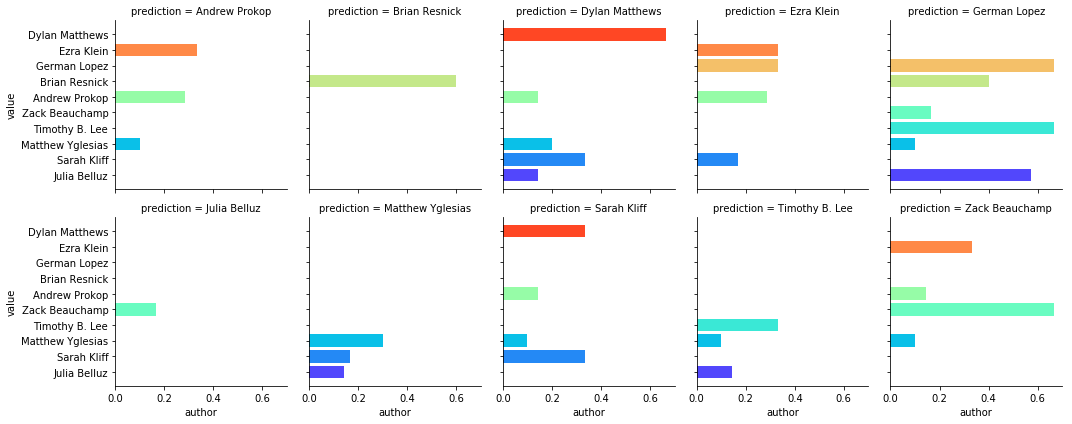

In [386]:
g = sns.FacetGrid(test_d2v_gbcpct_long_vox, col='prediction', col_wrap=5, hue='author', palette='rainbow')
g = g.map(plt.barh, 'author', 'value')
plt.show()

In [387]:
## word2vec average

gbc_vox.fit(av_train_g1_vox, y_train_vox)

cv_av_g1_gbc_vox = cross_val_score(gbc_vox, av_train_g1_vox, y_train_vox, cv=5)
cv_av_g1_gbc_vox

      Iter       Train Loss   Remaining Time 
         1         182.9036            2.88s
         2         146.1525            2.45s
         3         121.8458            2.22s
         4         102.8948            2.18s
         5          86.5591            2.23s
         6          73.1586            2.15s
         7          61.9075            2.05s
         8          52.4112            1.93s
         9          44.4121            1.82s
        10          37.2430            1.73s
        11          31.3750            1.66s
        12          26.7035            1.59s
        13          22.5655            1.52s
        14          19.2351            1.47s
        15          16.4182            1.42s
        16          14.0589            1.37s
        17          12.0225            1.32s
        18          10.2034            1.30s
        19           8.6669            1.27s
        20           7.4411            1.24s
        21           6.3663            1.21s
        2

        32           0.6376            0.50s
        33           0.5390            0.47s
        34           0.4554            0.44s
        35           0.3867            0.41s
        36           0.3300            0.38s
        37           0.2786            0.35s
        38           0.2390            0.33s
        39           0.2049            0.30s
        40           0.1746            0.27s
        41           0.1523            0.24s
        42           0.1350            0.21s
        43           0.1192            0.18s
        44           0.1065            0.16s
        45           0.0956            0.13s
        46           0.0915            0.10s
        47           0.0867            0.08s
        48           0.0831            0.05s
        49           0.0806            0.02s
        50           0.0787            0.00s
      Iter       Train Loss   Remaining Time 
         1         146.5588            1.25s
         2         115.5913            1.26s
         

array([0.25      , 0.36      , 0.36363636, 0.15      , 0.36842105])

In [388]:
ypred_av_g1_gbc_vox = gbc_vox.predict(av_test_g1_vox)
table_av_g1_gbc_vox = pd.crosstab(ypred_av_g1_gbc_vox, y_test_vox)
test_av_g1_gbcpct_vox = table_auth_pct(table_av_g1_gbc_vox, auth_counts_test)
test_av_g1_gbcpct_vox.reset_index(inplace=True)
test_av_g1_gbcpct_vox.rename(columns={'index': 'prediction'}, inplace=True)
test_av_g1_gbcpct_long_vox = pd.melt(test_av_g1_gbcpct_vox, id_vars='prediction')

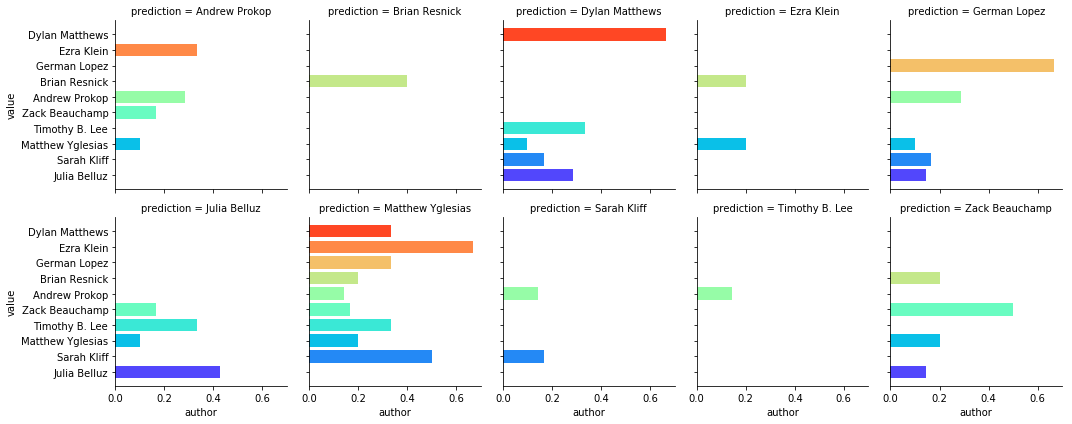

In [389]:
g = sns.FacetGrid(test_av_g1_gbcpct_long_vox, col='prediction', col_wrap=5, hue='author', palette='rainbow')
g = g.map(plt.barh, 'author', 'value')
plt.show()

In [390]:
## word2vec max

gbc_vox.fit(max_train_g1_vox, y_train_vox)

cv_max_g1_gbc_vox = cross_val_score(gbc_vox, max_train_g1_vox, y_train_vox, cv=5)
cv_max_g1_gbc_vox

      Iter       Train Loss   Remaining Time 
         1         190.1843            1.68s
         2         152.0757            1.67s
         3         123.8199            1.58s
         4         103.2466            1.51s
         5          87.0089            1.47s
         6          74.5041            1.47s
         7          63.6430            1.47s
         8          54.6549            1.45s
         9          46.8736            1.40s
        10          40.5387            1.34s
        11          35.0762            1.27s
        12          30.6054            1.21s
        13          26.3715            1.16s
        14          22.8755            1.11s
        15          19.8071            1.07s
        16          17.2006            1.03s
        17          15.0084            0.99s
        18          13.2008            0.95s
        19          11.5631            0.91s
        20          10.3214            0.87s
        21           9.1681            0.83s
        2

        38           0.5709            0.26s
        39           0.5011            0.24s
        40           0.4425            0.21s
        41           0.3833            0.19s
        42           0.3366            0.17s
        43           0.3006            0.15s
        44           0.2682            0.13s
        45           0.2444            0.11s
        46           0.2199            0.08s
        47           0.2012            0.06s
        48           0.1833            0.04s
        49           0.1681            0.02s
        50           0.1544            0.00s
      Iter       Train Loss   Remaining Time 
         1         153.1982            1.67s
         2         121.5295            1.42s
         3          99.5806            1.29s
         4          83.2392            1.19s
         5          68.9751            1.14s
         6          58.2542            1.09s
         7          49.1721            1.04s
         8          42.0825            1.00s
         

array([0.21428571, 0.28      , 0.36363636, 0.3       , 0.15789474])

In [391]:
ypred_max_g1_gbc_vox = gbc_vox.predict(max_test_g1_vox)
table_max_g1_gbc_vox = pd.crosstab(ypred_max_g1_gbc_vox, y_test_vox)
test_max_g1_gbcpct_vox = table_auth_pct(table_max_g1_gbc_vox, auth_counts_test)
test_max_g1_gbcpct_vox.reset_index(inplace=True)
test_max_g1_gbcpct_vox.rename(columns={'index': 'prediction'}, inplace=True)
test_max_g1_gbcpct_long_vox = pd.melt(test_max_g1_gbcpct_vox, id_vars='prediction')

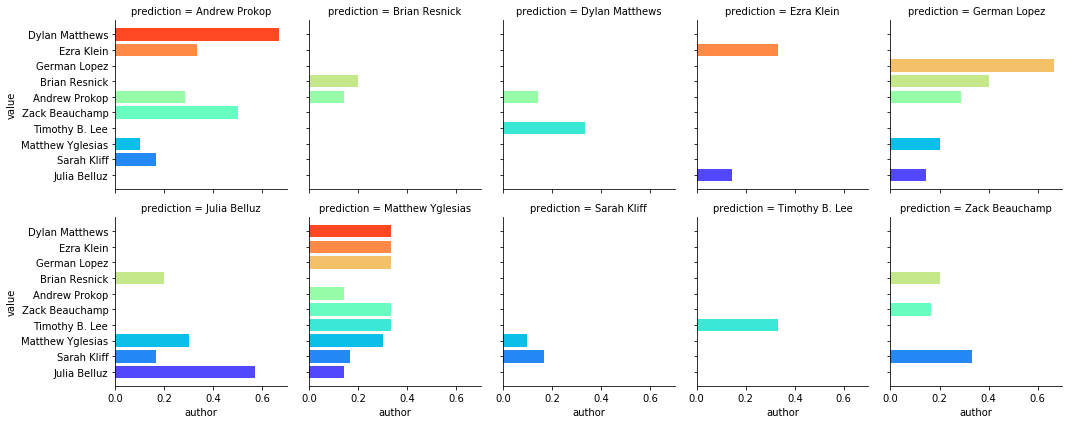

In [392]:
g = sns.FacetGrid(test_max_g1_gbcpct_long_vox, col='prediction', col_wrap=5, hue='author', palette='rainbow')
g = g.map(plt.barh, 'author', 'value')
plt.show()

In [393]:
## bow

gbc_vox.fit(x_train_bow_vox, y_train_vox)

cv_bow_gbc_vox = cross_val_score(gbc_vox, x_train_bow_vox, y_train_vox, cv=5)
cv_bow_gbc_vox

      Iter       Train Loss   Remaining Time 
         1         192.5408            2.49s
         2         158.6766            2.34s
         3         132.0956            2.34s
         4         114.1353            2.40s
         5          98.5678            2.43s
         6          85.9409            2.36s
         7          75.9250            2.19s
         8          67.4948            2.05s
         9          59.8552            1.96s
        10          52.9240            1.89s
        11          47.4014            1.79s
        12          42.2835            1.72s
        13          37.7485            1.64s
        14          34.2556            1.58s
        15          30.8694            1.53s
        16          28.1575            1.49s
        17          25.9571            1.46s
        18          23.5377            1.44s
        19          21.3180            1.42s
        20          19.4566            1.38s
        21          17.7249            1.33s
        2

        32           2.3012            0.71s
        33           2.0486            0.67s
        34           1.8299            0.62s
        35           1.6535            0.58s
        36           1.4866            0.54s
        37           1.3409            0.49s
        38           1.1978            0.45s
        39           1.0712            0.41s
        40           0.9559            0.37s
        41           0.8662            0.34s
        42           0.7805            0.30s
        43           0.7060            0.26s
        44           0.6277            0.22s
        45           0.5678            0.18s
        46           0.5105            0.14s
        47           0.4655            0.11s
        48           0.4250            0.07s
        49           0.3908            0.04s
        50           0.3558            0.00s
      Iter       Train Loss   Remaining Time 
         1         158.4281            1.23s
         2         129.7657            1.24s
         

array([0.28571429, 0.28      , 0.31818182, 0.25      , 0.21052632])

In [394]:
ypred_bow_gbc_vox = gbc_vox.predict(x_test_bow_vox)
table_bow_gbc_vox = pd.crosstab(ypred_bow_gbc_vox, y_test_vox)
test_bow_gbcpct_vox = table_auth_pct(table_bow_gbc_vox, auth_counts_test)
test_bow_gbcpct_vox.reset_index(inplace=True)
test_bow_gbcpct_vox.rename(columns={'index': 'prediction'}, inplace=True)
test_bow_gbcpct_long_vox = pd.melt(test_bow_gbcpct_vox, id_vars='prediction')

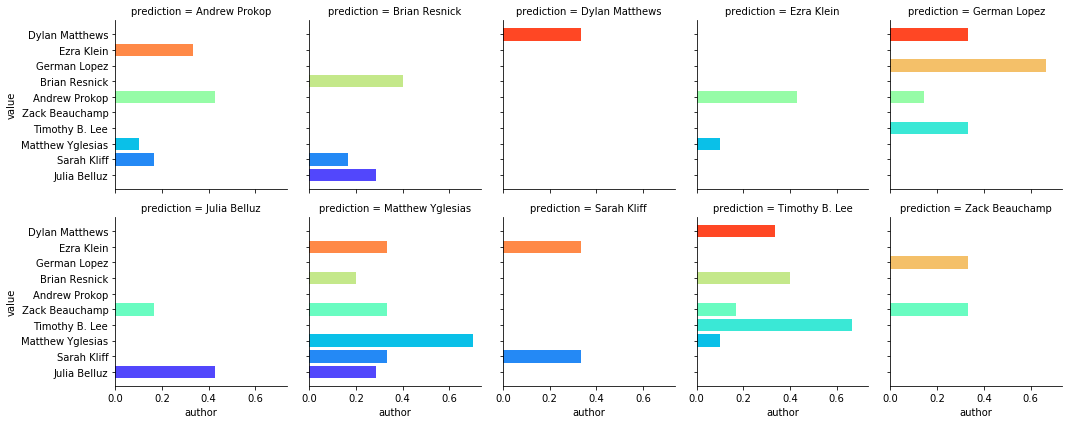

In [395]:
g = sns.FacetGrid(test_bow_gbcpct_long_vox, col='prediction', col_wrap=5, hue='author', palette='rainbow')
g = g.map(plt.barh, 'author', 'value')
plt.show()

In [396]:
## tfidf

gbc_vox.fit(vox_train_tfidf, y_train_vox)

cv_tfidf_gbc_vox = cross_val_score(gbc_vox, vox_train_tfidf, y_train_vox, cv=5)
cv_tfidf_gbc_vox

      Iter       Train Loss   Remaining Time 
         1         185.0807            3.98s
         2         147.1380            3.62s
         3         120.8613            3.73s
         4         100.5015            3.75s
         5          85.0795            3.47s
         6          73.2078            3.26s
         7          62.6246            3.12s
         8          53.7658            2.98s
         9          46.2058            2.88s
        10          40.1499            2.84s
        11          35.0867            2.89s
        12          30.5489            2.86s
        13          27.0839            2.81s
        14          23.5956            2.70s
        15          20.5299            2.60s
        16          18.0654            2.51s
        17          16.0520            2.45s
        18          14.1092            2.35s
        19          12.2833            2.26s
        20          10.7760            2.20s
        21           9.4794            2.17s
        2

        32           0.9043            0.92s
        33           0.7792            0.87s
        34           0.6790            0.81s
        35           0.5928            0.76s
        36           0.5141            0.71s
        37           0.4465            0.66s
        38           0.3888            0.61s
        39           0.3365            0.55s
        40           0.2945            0.50s
        41           0.2573            0.45s
        42           0.2288            0.39s
        43           0.2016            0.34s
        44           0.1802            0.29s
        45           0.1637            0.24s
        46           0.1496            0.19s
        47           0.1368            0.14s
        48           0.1286            0.09s
        49           0.1203            0.05s
        50           0.1134            0.00s
      Iter       Train Loss   Remaining Time 
         1         146.4342            2.60s
         2         114.4974            2.76s
         

array([0.32142857, 0.4       , 0.36363636, 0.3       , 0.21052632])

In [397]:
ypred_tfidf_gbc_vox = gbc_vox.predict(vox_test_tfidf)
table_tfidf_gbc_vox = pd.crosstab(ypred_tfidf_gbc_vox, y_test_vox)
test_tfidf_gbcpct_vox = table_auth_pct(table_tfidf_gbc_vox, auth_counts_test)
test_tfidf_gbcpct_vox.reset_index(inplace=True)
test_tfidf_gbcpct_vox.rename(columns={'index': 'prediction'}, inplace=True)
test_tfidf_gbcpct_long_vox = pd.melt(test_tfidf_gbcpct_vox, id_vars='prediction')

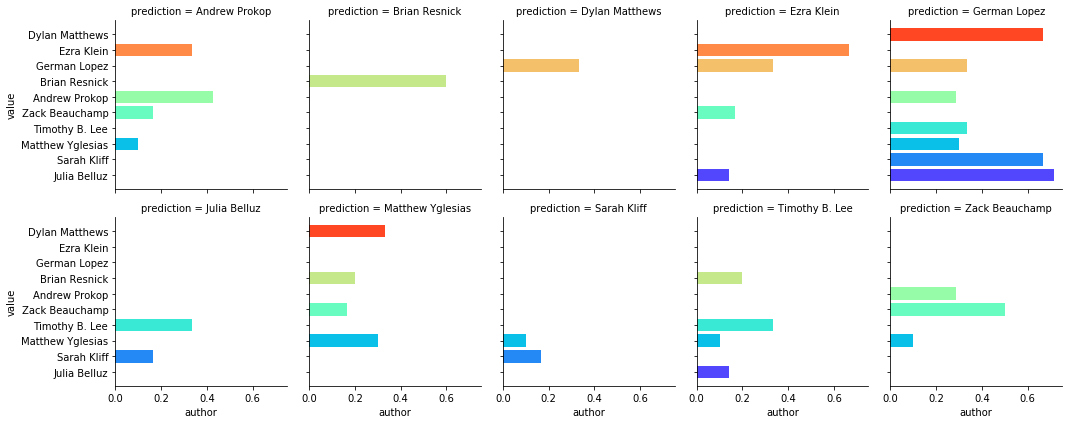

In [398]:
g = sns.FacetGrid(test_tfidf_gbcpct_long_vox, col='prediction', col_wrap=5, hue='author', palette='rainbow')
g = g.map(plt.barh, 'author', 'value')
plt.show()

doc2vec might be best here.